# Init

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_USERNAME'] = 'vegetablejuice'
os.environ['KAGGLE_KEY'] = 'SECRET'
class SkipExecution(Exception):
    def _render_traceback_(self):
        print("Skip execution")
SKIP = True
# Skip if already run once
CACHE = {}
try:
    import python_speech_features
except:
    pass            
else:
    raise SkipExecution

!pip install kaggle python_speech_features dtw fastdtw dtaidistance AudAugio pyrubberband --upgrade -q 
!apt install soundstretch rubberband-cli librubberband2 libsndfile1 > /dev/null
!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech > /dev/null
!unzip darpa-timit-acousticphonetic-continuous-speech.zip > /dev/null
# !cp "/content/drive/My Drive/dataset/TIMIT_CACHE.zip" TIMIT_CACHE.zip
# !7z x -aos TIMIT_CACHE.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 327kB 2.6MB/s 


100% 829M/829M [00:19<00:00, 44.3MB/s]


In [2]:
# packges
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
from python_speech_features import logfbank, mfcc
from matplotlib import cm
from matplotlib.pyplot import figure
from collections import Counter
import json
from time import sleep
from google.colab import drive
from numpy import dot
from numpy.linalg import norm
import cProfile
from typing import NamedTuple, List
from random import choice, sample, Random
import random
import math
import contextlib
from sklearn.model_selection import train_test_split

import soundfile as sf
import pyrubberband as pyrb
import scipy.io.wavfile as wavfile
import librosa
from IPython.display import Audio, Image, display

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from collections import namedtuple
from torchtext.data import BucketIterator, Field

import numpy as np
from os.path import join
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
from matplotlib.pyplot import figure
import json
import gc
import uuid

from pprint import pprint
from collections import OrderedDict, defaultdict
from itertools import chain

from torch.utils.data import Dataset, DataLoader
from torchtext.data import BucketIterator, RawField
from collections import namedtuple
from torchtext.data import BucketIterator, Field

from dtw import dtw, accelerated_dtw as adtw
from fastdtw import fastdtw, dtw as slowdtw
from dtaidistance import dtw as dtaidtw
from dtaidistance.dtw_ndim import warping_paths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# caching
duration_model = None
duration_cache = {}

BASE_PATH = '/content/TIMIT-PLUS'
FULL_FODLER_PATH = join(BASE_PATH, 'data')
INPUT_SIZE = 26

# WIN_STEP = 0.015
WIN_STEP = 0.010
# WIN_STEP = 0.005

WIN_SIZE = 0.025
# WIN_SIZE = 0.030
# WIN_SIZE = 0.020
# WIN_SIZE = 0.010
# WIN_SIZE = 0.015
# WIN_SIZE = 0.020

DURATION_SCALER = 256.  # duration models do not play well with 123ms bot not also with 0.1sec ...

FOUND_LABELS = dict([
  ('h#', 12600), ('ix', 11587), ('s', 10114), ('iy', 9663), ('n', 9569), ('r', 9064), 
  ('tcl', 8978), ('l', 8157), ('kcl', 7823), ('ih', 6760), ('dcl', 6585), ('k', 6488), 
  ('t', 5899), ('m', 5429), ('ae', 5404), ('eh', 5293), ('z', 5046), ('ax', 4956), ('q', 4834),
  ('d', 4793), ('axr', 4790), ('w', 4379), ('aa', 4197), ('ao', 4096), ('dh', 3879), 
  ('dx', 3649), ('pcl', 3609), ('p', 3545), ('ay', 3242), ('ah', 3185), ('f', 3128), 
  ('ey', 3088), ('b', 3067), ('sh', 3034), ('gcl', 3031), ('ow', 2913), ('er', 2846), 
  ('g', 2772), ('v', 2704), ('bcl', 2685), ('ux', 2488), ('y', 2349), ('epi', 2000), 
  ('ng', 1744), ('jh', 1581), ('hv', 1523), ('pau', 1343), ('nx', 1331), ('hh', 1313), 
  ('el', 1294), ('ch', 1081), ('th', 1018), ('en', 974), ('oy', 947), ('aw', 945), 
  ('uh', 756), ('uw', 725), ('ax-h', 493), ('zh', 225), ('em', 171), ('eng', 43), ])

TRANSFORM_MAPPING = {
    # First, the sentence-beginning and sentence-ending pause symbols /h#/ were mapped to pause (/pau/).
    'h#': 'pau',
    # Epenthetic silence (/epi/) was also mapped to pause. 
    'epi': 'pau',
    # The syllabic phonemes /em/, /en/, /eng/, and /el/ were mapped to their non-syllabic counterparts /m/, /n/, /ng/, and /l/, respectively. 
    "em" : "m",
    "en" : "n",
    "eng" : "ng",
    "el" : "l",
    # The glottal closure symbol /q/ was merged based on weird rules
    "q": None,
}

NO_BORDER_MAPPING = {
    'pau', 'pcl', 'bcl', 'tcl', 'dcl', 'kcl', 'gcl',
}


KNOWN_LABELS = list(sorted(set(TRANSFORM_MAPPING.get(k, k) for k in sorted(FOUND_LABELS.keys()) if TRANSFORM_MAPPING.get(k, k))))
KNOWN_LABELS_COUNT = len(KNOWN_LABELS)
MAP_LABELS = {
    label: (
        [int(KNOWN_LABELS.index(label) == i) for i in range(KNOWN_LABELS_COUNT)],
        KNOWN_LABELS.index(label),
    )
    for label in KNOWN_LABELS
}

class AudioCaching:
    BASE_FOLDER = '/content/TIMIT-PLUS'
    CACHE_FOLDER = BASE_FOLDER + '-CACHE'
    # AUDIO_SCALING = 32768.
    AUDIO_RATE = 16000
    
    @classmethod
    def to_file_path(cls, file_path, key):
        filename = os.path.basename(file_path)
        cache_filename = f"[{'__'.join(str(k) for k in key)}]{filename}"
        cache_path = os.path.dirname(file_path).replace(cls.BASE_FOLDER, cls.CACHE_FOLDER)
        cache_file_path = os.path.join(cache_path, cache_filename)
        return cache_file_path
    
    @classmethod
    def set(cls, file_path, key, audio):
        cache_file_path = cls.to_file_path(file_path, key)
        # cached version exists :D
        if not os.path.isfile(cache_file_path):
            os.makedirs(os.path.dirname(cache_file_path), exist_ok=True)
            sf.write(cache_file_path, audio, cls.AUDIO_RATE)
    
    @classmethod
    def get(cls, file_path, key):
        cache_file_path = cls.to_file_path(file_path, key)
        # cached version exists :D
        if os.path.isfile(cache_file_path):
            # loader = wavfile.read(cache_file_path)[1]
            # audio = audio.astype(np.float32) / audio_scaling
            print("+", cache_file_path)
            return cls.load(cache_file_path)
        else:
            print("-", file_path)
    
    @classmethod
    def load(cls, file_path):
        audio = sf.read(file_path)[0]
        return audio

class UtteranceBatch(NamedTuple):
    padded: torch.tensor
    masks: torch.tensor
    lengths: torch.tensor

class Utterance(NamedTuple):
    features: torch.tensor
    labels: torch.tensor
    transcription: torch.tensor
    label_vec: torch.tensor
    out_map: List
    out_duration: torch.tensor
    in_transcription: torch.tensor
    position: torch.tensor
    border: torch.tensor
    weight: torch.tensor

    index: int
    key: str
    audio_file: str
    label_file: str

def stack(arr, tensor):
    return [tensor(a).to(device) for a in arr]

def dedupe(tags):
    labels = []
    last = None
    for x in tags:
        if last is not None and last == x:
            continue
        last = x
        labels.append(x)
    return labels

def find_borders(output_ids, original_mapping, ms_per_step=int(WIN_STEP * 1000)):
    # add half to the border, as it is between the two frames 
    arr = (np.where(output_ids[:-1] != output_ids[1:])[0] + 0.5) * ms_per_step
    last = output_ids.shape[0] * ms_per_step
    arr = np.append(arr, last)
    flat_ids = np.array(dedupe(output_ids))
    ids = np.array([voc for voc, end in original_mapping])
    assert (ids.shape == flat_ids.shape) and (ids != flat_ids).sum() == 0, f"[error] Mapping and Output have same composition {ids.shape} {flat_ids.shape}" 
    a, b = np.array([end for voc, end in original_mapping]), arr
    
    diff = (a - b)
    return a, b, diff

class PositionalEncodingLabeler(nn.Module):
    def __init__(self, d_model, dropout=0.1, scale=1, max_len=2048):
        super().__init__()
        self.scale = scale
        self.dropout = nn.Dropout(p=dropout)
        if not self.scale:
            return
        max_len = int(max_len * scale)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        m = nn.Upsample(scale_factor=(1. / scale, 1), mode='bilinear', align_corners=True)
        shape = pe.shape
        pe = pe.view(1, 1, *shape)
        pe = m(pe).view(-1, d_model) 

        pe = pe.unsqueeze(0).transpose(0, 1).transpose(0, 1)[0]
        self.register_buffer('pe', pe)

    def forward(self, out_duration):
        durations = torch.cumsum(out_duration, dim=0) * DURATION_SCALER / ms_per_step
        return self.pe[durations.round().long()], durations
        
ms_per_step = WIN_STEP * 1000
POS_DIM = 32
POS_SCALE = 1
pos_prep = PositionalEncodingLabeler(POS_DIM, scale=POS_SCALE)
MERGE_DOUBLES = False
unholy = set()

class DirectMaskDataset(Dataset):
    base = '/content'

    @classmethod
    def load_csv(cls, prefix, sa=False):
        file_path = join(cls.base, f'{prefix}_data.csv')
        """ Filters out the files names of phonetic and sound data in pairs"""
        df = pd.read_csv(file_path, delimiter=',', nrows = None)
        df = df.sort_values(by=['path_from_data_dir'])
        # audio_mask = df.is_converted_audio == True
        audio_mask = (df.is_audio == True) & (df.is_converted_audio == True)
        phn_mask = df.filename.str.contains('.PHN') == True
        SA_mask = df.filename.str.contains('SA') == False
        df = df.loc[audio_mask | phn_mask]
        print("SA", sa)
        if not sa:
            df = df.loc[SA_mask]

        ipd.display(df.head())
        nRow, nCol = df.shape
        # print(f'There are {nRow} rows and {nCol} columns')
        A, B = df.loc[phn_mask].path_from_data_dir, df.loc[audio_mask].path_from_data_dir
        assert len(A) == len(B)
        files = list(zip(A, B))
        return files

    @staticmethod
    def get_name(file_name):
        _, a, b, name = file_name.split('/')
        name = name.split('.')[0]
        return a, b, name

    def json_to_vec(arr):
        return [np.array([MAP_LABELS[tag][0] for tag in tags]) for tags in arr]

    def process_audio(self, labels: list, length: int, step: float) -> List[List]:
        tag_ints, tag_vecs, tag_mapping, transcription = [], [], [], []

        current, prev = 0, None
        for end_ms, tag in labels:                    

            tag = TRANSFORM_MAPPING.get(tag, tag)
            q_tag = False # /q/ tag
            if tag is None:
                tag = prev
                q_tag = True
                end_ms = (current + end_ms) / 2

            if current >= end_ms:
                continue

            unholy_combination = prev in NO_BORDER_MAPPING and tag in NO_BORDER_MAPPING
            if unholy_combination:
                unholy.add((prev, tag))

            if prev == tag and MERGE_DOUBLES or unholy_combination or q_tag:
                tag_id, ems = tag_mapping[-1]
                tag_mapping[-1] = (tag_id, end_ms)

            else:
                tag_id = MAP_LABELS[tag][1]
                tag_vec = np.array(MAP_LABELS[tag][0])

                tag_mapping.append((tag_id, end_ms))
                transcription.append(tag_vec)
            
            prev = tag  # handle same tag occurence
            
            tag_ints.append(tag_id)
            tag_vecs.append(tag_vec)
            current += step

            while current < end_ms and len(tag_ints) < length:
                tag_ints.append(tag_id)
                tag_vecs.append(tag_vec)
                current += step
        
        if length > len(tag_vecs):
            tag_ints.append(tag_id)
            tag_vecs.append(tag_vec)
        
        return tag_ints, tag_vecs, tag_mapping, transcription 

    def get_set(self, key, func):
        value = CACHE.get(key)
        value = value if value is not None else func()
        CACHE[key] = value
        return value

    def __init__(self, files, limit=None, mask=None, augment=False, duplicate=1, seed="42"):

        random = Random(seed)  # init random generator
        self.counts = []

        base = self.base
        
        if limit is not None:
            files = files[:limit]

        inp, out_vec, out_int, out_map, out_dur, out_trans = [], [], [], [], [], []
        position, border, weight = [], [], []

        duplicate_set = set()
        self.files = []

        for i, (label_file, audio_file) in enumerate(files * duplicate):
            assert self.get_name(label_file) == self.get_name(audio_file)
            a, b, c = self.get_name(label_file)
            identifier = f'{a}_{b}_{c}_{i}'

            label_file = os.path.join(base, 'data', label_file)
            audio_file = os.path.join(base, 'data', audio_file)

            loader = lambda: AudioCaching.load(audio_file)
            audio = self.get_set(audio_file, loader)
            audio_scaling, rate = 32768. / 512, 16000
            audio_base_len = len(audio)

            stretch = 1
            pure_key = (audio_file, "pure_key")
            if pure_key not in duplicate_set:
                duplicate_set.add(pure_key)
            elif augment:
                # pitch = random.choice([-6, -4, -1, 1, 4, 6])
                # stretch = random.choice([0.85, 0.9, 0.95, 1.05, 1.1, 1.15])
                # pitch = random.choice([-4, -1, 1, 4])
                pitch = random.choice([-1, 0, 1])
                stretch = random.choice([0.9, 0.95, 1.05, 1.1])

                key_stretch = "time_stretch", stretch
                key_pitch = "pitch_shift", pitch, stretch
                
                duplication_key = (audio_file, key_pitch)
                if duplication_key in duplicate_set:
                    continue
                duplicate_set.add(duplication_key)

                audio_pitch_shift = lambda: pyrb.pitch_shift(audio, rate, pitch)
                
                cache_audio = AudioCaching.get(audio_file, key_pitch)
                got_pitch = cache_audio is not None
                cache_audio = cache_audio if got_pitch else AudioCaching.get(audio_file, key_stretch)
                got_stretch = cache_audio is not None

                audio = cache_audio if cache_audio is not None else audio
                
                if not got_stretch:
                    audio = pyrb.time_stretch(audio, rate, stretch)
                    AudioCaching.set(audio_file, key_stretch, audio)

                if not got_pitch:
                    audio = pyrb.pitch_shift(audio, rate, pitch)
                    AudioCaching.set(audio_file, key_pitch, audio)
                
                stretch =  len(audio) / audio_base_len

            fbank_feat = logfbank(audio, rate, winlen=WIN_SIZE, winstep=WIN_STEP, nfilt=INPUT_SIZE)  # TODO: remove scaling
            # some audio instances are too short for the audio transcription and the winlen cut :(
            fbank_feat = np.vstack([fbank_feat] + [fbank_feat[-1]] * 10)

            step_size = (WIN_STEP * 1000)
            with open(label_file) as f:
                lines = list(f.readlines())
                length = fbank_feat.shape[0]
                length_ms = length * step_size
                labels = []
                ms_samples = 16

                for line in lines:                    
                    _, end, tag = line.split()
                    end_ms = float(end) / ms_samples * stretch
                    end_ms = min(end_ms, length_ms)
                    labels.append((end_ms, tag))

                length = int((end_ms / step_size))                    

            tag_ints, tag_vecs, tag_mapping, transcription = self.process_audio(labels, length, step_size)
            fbank_feat = fbank_feat[:len(tag_ints)]
            length = fbank_feat.shape[0]
            length_ms = length * step_size
            
            w = [200. / FOUND_LABELS[KNOWN_LABELS[_pid]] for _pid, _ms in tag_mapping]
            
            if i % 150 == 0:
                print(i)
                gc.collect()
            
            if length == len(tag_vecs) and length == len(tag_ints):    
                original = stack([tag_vecs], torch.FloatTensor)[0].cpu().numpy()
                original_ids = np.argmax(original, axis=1)
                if MERGE_DOUBLES:
                    a, b, diff = find_borders(original_ids, tag_mapping)
                    d = abs(diff).max() 
                    if d > 15:
                        print(f"[DIFF-ERROR] diff is bigger {d} > 15", np.where(abs(diff) > 15), diff.shape)
                        print("\t", tag_mapping[-1], length_ms)
                        print("\t", np.round(a[-5:],0))
                        print("\t", np.round(b[-5:],0))
                        continue
                self.counts.append(length)
                tag_duration = []
                start = 0
                for _, end_ms in tag_mapping:
                    end_time = end_ms / DURATION_SCALER
                    tag_duration.append(end_time - start)
                    start = end_time  # CUMSUM vs DURATION
                
                pos, bor = pos_prep(torch.FloatTensor(tag_duration[:-1]).to(device))
                position.append(pos)
                border.append(bor)
                weight.append(w)

                out_dur.append(tag_duration)
                inp.append(fbank_feat)
                out_vec.append(tag_vecs)
                out_int.append(tag_ints)  
                out_trans.append(transcription)
                out_map.append(tag_mapping)
                self.files.append((label_file, audio_file))
            else:
                print(f"[ERROR] len not match {length} != {len(tag_vecs)} != {len(tag_ints)} \n\t - {label_file}\n\t - {audio_file}")
            
        self.inp = stack(inp, torch.FloatTensor)
        self.out_vec = stack(out_vec, torch.FloatTensor)
        self.out_int = stack(out_int, torch.LongTensor)
        self.transcription = stack(out_trans, torch.FloatTensor)
        self.out_map = out_map
        self.out_duration = stack(out_dur, torch.FloatTensor)
        self.in_transcription = stack(out_trans, torch.FloatTensor)
        self.key = [uuid.uuid4().urn for i in range(len(inp))]
        self.position = position
        self.border = border
        self.weight = stack(weight, torch.FloatTensor)

        FEATURES = RawField(postprocessing=self.features_batch_process)
        LABEL = RawField(postprocessing=self.features_batch_process)
        TRANSCRIPTION = RawField()
        LABEL_VEC = RawField()
        OUT_MAP = RawField()
        OUT_DUR = RawField(postprocessing=self.features_batch_process)
        IN_TRANS = RawField(postprocessing=self.features_batch_process)
        INDEX = RawField()
        KEY = RawField()
        POSITION = RawField(postprocessing=self.features_batch_process)
        BORDER = RawField(postprocessing=self.features_batch_process)
        WEIGHT = RawField(postprocessing=self.features_batch_process)

        setattr(FEATURES, "is_target", False)
        setattr(LABEL_VEC, "is_target", False)
        setattr(OUT_MAP, "is_target", False)
        setattr(TRANSCRIPTION, "is_target", False)
        setattr(OUT_DUR, "is_target", False)
        setattr(IN_TRANS, "is_target", False)
        setattr(LABEL, "is_target", True)
        setattr(INDEX, "is_target", False)
        setattr(KEY, "is_target", False)
        setattr(POSITION, "is_target", False)
        setattr(BORDER, "is_target", False)
        setattr(WEIGHT, "is_target", False)

        self.fields = {
            "features" : FEATURES, 
            "labels" : LABEL,
            "transcription": TRANSCRIPTION,
            "label_vec": LABEL_VEC, 
            "out_map": OUT_MAP,
            "out_duration": OUT_DUR,
            "in_transcription": IN_TRANS,
            "index": INDEX,
            "key": KEY,
            "position": POSITION,
            "border": BORDER,
            "weight": WEIGHT,
        }
    
    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx) -> Utterance:
        label_file, audio_file = self.files[idx]
        return Utterance(
            self.inp[idx], self.out_int[idx], self.transcription[idx], self.out_vec[idx],
            self.out_map[idx],
            self.out_duration[idx], self.in_transcription[idx],
            self.position[idx], self.border[idx], self.weight[idx],
            idx, self.key[idx],
            label_file, audio_file,
        )

    @staticmethod
    def features_batch_process(batch) -> UtteranceBatch:
        # this is used when a list of data items is transformed into a batch
        # TODO: could we, should we use pack_padded_sequence
        padded = nn.utils.rnn.pad_sequence(batch, batch_first=True).to(device)
        lens = torch.tensor([len(item) for item in batch]).to(device)
        b, max_len, *f = padded.shape
        return UtteranceBatch(
            padded,
            torch.arange(max_len).expand(len(lens), max_len).to(device) < lens.unsqueeze(1),
            lens
        )
    
    def batch(self, batch_size=128, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True):
        return BucketIterator(self, batch_size=batch_size, sort_key=sort_key, sort=sort, shuffle=shuffle, sort_within_batch=sort_within_batch)


limit = None  # None means unlimited

train_files = DirectMaskDataset.load_csv('train', sa=False)
test_files = DirectMaskDataset.load_csv('test', sa=False)

train_files, train_eval_files = train_test_split(train_files, test_size=500, random_state=42)

train_dataset = DirectMaskDataset(train_files, limit=limit)
train_eval_dataset = DirectMaskDataset(train_eval_files, limit=limit)

test_dataset = DirectMaskDataset(test_files, limit=limit)

toy_dataset = DirectMaskDataset(train_files, limit=1000)


boundary_counts = []
factors = []
# for utterance in chain(train_dataset, train_eval_dataset):
for utterance in test_dataset:
    utterance: Utterance = utterance
    audio_steps, _ = utterance.features.shape
    transcription_steps, _ = utterance.transcription.shape

    factor = audio_steps / transcription_steps
    factors.append(factor)

    boundary_counts.append(len(utterance.out_map))

print(len(boundary_counts), sum(boundary_counts), sum(boundary_counts) / len(boundary_counts))

factors = np.array(factors)
hist, bins = np.histogram(abs(factors))
hist = np.round(hist / len(factors) * 100, 1)

print(sum(factors) / len(factors))
print(1 / (sum(factors) / len(factors)))

POS_TRANSCRIPTION_SCALE = sum(factors) / len(factors)

for prev, tag in sorted(unholy):
    print(prev, '->', tag)

# train_augment_dataset = DirectMaskDataset(train_files, limit=None, augment=True, duplicate=3)
# !7z a TIMIT_CACHE.zip /content/data
# !cp TIMIT_CACHE.zip "/content/drive/My Drive/dataset/TIMIT_CACHE.zip"

cuda
SA False


,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
20924,20925.0,TRAIN,DR1,FCJF0,SI1027.PHN,TRAIN/DR1/FCJF0/SI1027.PHN,TRAIN\\DR1\\FCJF0\\SI1027.PHN,False,False,False,NaN,False
20943,20944.0,TRAIN,DR1,FCJF0,SI1027.WAV.wav,TRAIN/DR1/FCJF0/SI1027.WAV.wav,TRAIN\\DR1\\FCJF0\\SI1027.WAV.wav,True,True,False,NaN,False
20938,20939.0,TRAIN,DR1,FCJF0,SI1657.PHN,TRAIN/DR1/FCJF0/SI1657.PHN,TRAIN\\DR1\\FCJF0\\SI1657.PHN,False,False,False,NaN,False
20929,20930.0,TRAIN,DR1,FCJF0,SI1657.WAV.wav,TRAIN/DR1/FCJF0/SI1657.WAV.wav,TRAIN\\DR1\\FCJF0\\SI1657.WAV.wav,True,True,False,NaN,False
20907,20908.0,TRAIN,DR1,FCJF0,SI648.PHN,TRAIN/DR1/FCJF0/SI648.PHN,TRAIN\\DR1\\FCJF0\\SI648.PHN,False,False,False,NaN,False


SA False


,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
7374,7375.0,TEST,DR1,FAKS0,SI1573.PHN,TEST/DR1/FAKS0/SI1573.PHN,TEST\\DR1\\FAKS0\\SI1573.PHN,False,False,False,True,False
7355,7356.0,TEST,DR1,FAKS0,SI1573.WAV.wav,TEST/DR1/FAKS0/SI1573.WAV.wav,TEST\\DR1\\FAKS0\\SI1573.WAV.wav,True,True,False,False,False
7396,7397.0,TEST,DR1,FAKS0,SI2203.PHN,TEST/DR1/FAKS0/SI2203.PHN,TEST\\DR1\\FAKS0\\SI2203.PHN,False,False,False,True,False
7399,7400.0,TEST,DR1,FAKS0,SI2203.WAV.wav,TEST/DR1/FAKS0/SI2203.WAV.wav,TEST\\DR1\\FAKS0\\SI2203.WAV.wav,True,True,False,False,False
7362,7363.0,TEST,DR1,FAKS0,SI943.PHN,TEST/DR1/FAKS0/SI943.PHN,TEST\\DR1\\FAKS0\\SI943.PHN,False,False,False,True,False


0
150
300
450
600
750
900
1050
1200
1350
1500
1650
1800
1950
2100
2250
2400
2550
2700
2850
3000
3150
0
150
300
450
0
150
300
450
600
750
900
1050
1200
0
150
300
450
600
750
900
1344 50579 37.633184523809526
8.344777745411855
0.11983542647973126
bcl -> pau
dcl -> bcl
dcl -> dcl
dcl -> gcl
dcl -> pau
gcl -> dcl
gcl -> gcl
gcl -> pau
kcl -> bcl
kcl -> dcl
kcl -> gcl
kcl -> kcl
kcl -> pau
kcl -> tcl
pau -> bcl
pau -> dcl
pau -> gcl
pau -> kcl
pau -> pau
pau -> tcl
pcl -> gcl
pcl -> pau
pcl -> pcl
tcl -> bcl
tcl -> dcl
tcl -> gcl
tcl -> kcl
tcl -> pau
tcl -> tcl


# Augmentation

In [0]:
# !cp "/content/drive/My Drive/dataset/TIMIT_CACHE.zip" TIMIT_CACHE.zip
# !7z x -aos TIMIT_CACHE.zip

In [0]:
# train_augment_dataset = DirectMaskDataset(train_files, limit=None, augment=True, duplicate=3)

# Utils

In [1]:
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

@contextlib.contextmanager
def nullcontext():
    yield None

def load(model, path, ignore: list = None):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(path)
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and (not ignore or not any((i in k) for i in ignore))}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(model_dict)

def export_model(model, path):
    torch.save(model.state_dict(), path)

# # # # # # # # # # # # # # # # # #

dist = 2
# dist = lambda x, y: norm(x - y, ord=1)
# dist = 'cosine'


def get_aligned_result(result: np.ndarray, labels: np.ndarray) -> np.ndarray:
    step_count, feature_count = result.shape
    labelss = labels
    # result = result + np.random.random_sample(result.shape) / 5
    # labelss = labels + np.random.random_sample(labels.shape) / 5
    # distance, path = __dtw(result, labelss, dist=dist)
    distance, path = slowdtw(result, labelss, dist=dist)
    # warped_result = np.vstack([labels[index,:] for _, index in path])
    # return warped_result, None
    # if len(path) != step_count:
    #     d, cost_matrix, acc_cost_matrix, (result_to_labels, labels_to_result) = adtw(result, labelss, dist=euclidean_norm)
    #     warped_result = np.vstack([labels[index,:] for index in labels_to_result])

    # d, cost_matrix, acc_cost_matrix, (result_to_labels, labels_to_result) = adtw(result, labelss, dist='cosine')
    # warped_result = np.vstack([labels[index,:] for index in labels_to_result])
    # print(len(result_to_labels), len(labels_to_result))
    # path = list(zip(result_to_labels, labels_to_result))

    stack = [None] * step_count
    path_for_id = []
    label_ids = np.argmax(labels, axis=1)
    for index, label_id in path:            
        stack[index] = labels[label_id,:]
        path_for_id.append((index, label_ids[label_id]))

    warped_result = np.vstack(stack)
    return warped_result, path_for_id


def generate_duration_transcription(transcriptions: np.ndarray, durations: np.ndarray) -> np.ndarray:
    """Durations be scaled"""
    # durations *= DURATION_SCALER
    # return transcriptions
    ms_per_step = WIN_STEP * 1000
    stack = []
    for feature, duration in zip(transcriptions, durations):
        adj_dur = duration / ms_per_step

        steps = max((adj_dur).round().item(), 1)
        for i in range(int(steps)):
            stack.append(feature)

    transcription_with_duration = np.vstack(stack)
    return transcription_with_duration

def find_borders_pathed(path: list, original_mapping: list):
    # add 0.5 to the border, as it is between the two frames 

    borders = []
    last = path[0][1]

    for idx, label_id in path:
        if last != label_id:
            pos = idx - .5
            borders.append(pos * ms_per_step)
        last = label_id
    length = idx + 1

    # group = defaultdict(list)
    # for index, label_id in path:            
    #     group[index].append(label_id)
    
    # length = index + 1
    # for index in range(length):
    #     labels = group[index]
    #     total = len(labels)
        
    #     for i, label_id in enumerate(labels):
    #         if last != label_id:
    #             pos = index - 0.459 + (.5 / total) * i
    #             borders.append((pos) * ms_per_step)
    #         last = label_id

    # borders.append((length - 0.459) * ms_per_step)  # add last border

    borders_pred = np.array(borders)
    
    borders_truth = np.array([end for i, (voc, end) in enumerate(original_mapping) if original_mapping[min(i+1, len(original_mapping) - 1)][0] != voc])

    assert (borders_pred.shape == borders_truth.shape) , f"[error] Mapping and Output have same composition {borders_pred.shape} {borders_truth.shape}" 
    
    diff = (borders_truth - borders_pred)
    return None, None, diff


def evaluate_result(model, iterator, lower=True, duration_model=None):
    dtw_errors = []
    detection_errors = []

    print("[standard]" if (duration_model is None) else "[duration model]")
    diff_ranking = []
    diffs = []
    cache_hits = 0
    for batch in iterator:
        features_audio = batch.features.padded
        batch_s, time_s, feat_s = features_audio.shape
        masks_audio = batch.features.masks
        features_transcription = batch.in_transcription.padded
        masks_transcription = batch.in_transcription.masks
        labels = batch.labels.padded

        full_result = model(features_transcription, masks_transcription, features_audio, masks_audio)
        full_result = F.softmax(full_result, dim=2)
        
        full_result_cls = torch.argmax(full_result, dim=2)        
        full_result = full_result.cpu().detach().numpy()

        for i in range(batch_s):
            idx = batch.index[i]
            key = batch.key[i]
            length = batch.labels.lengths[i].cpu().detach().numpy()
            transcription = batch.transcription[i].cpu().detach().numpy()
            
            result = full_result[i,:length,:]
            result_cls = full_result_cls[i,:length]
            labels_cls = labels[i,:length]

            audio = features_audio[i,:length,:]
            truth = batch.label_vec[i].cpu().detach().numpy()

            if duration_model:
                if key in duration_cache:
                    cache_hits += 1
                    transcription = duration_cache[key]
                else:
                    res_batch = duration_model.forward(batch.transcription[i].unsqueeze(0), None, audio.unsqueeze(0), None)
                    prediction = (res_batch).squeeze(0).detach().cpu().numpy() * DURATION_SCALER
                    transcription = generate_duration_transcription(transcription, prediction)
                    duration_cache[key] = transcription

            # labels is a sequence of vocals in order of their creation with no duration
            warped_result, path = get_aligned_result(result, transcription)
            wmax = np.argmax(warped_result, axis=1)

            error = (labels_cls.cpu().detach().numpy() != wmax[:length]).sum()
            dtw_error = (error / length) * 100

            if dtw_error > 25:
                print(f"danger: dtw_error {dtw_error:.1f}% wrong idx:{idx}")
                print(f"- warped_result: {warped_result.shape}\n- truth:{truth.shape}")
                # f, axarr = plt.subplots(5, figsize=(24, 6))
                # axarr[0].text(5, 5, 'Audio', bbox={'facecolor': 'white', 'pad': 10})
                # axarr[0].imshow(audio.detach().cpu().numpy().T, origin="lower", aspect='auto', cmap=cm.winter)
                # axarr[1].imshow(truth.T, origin="lower", aspect='auto', cmap=cm.winter)
                # axarr[1].text(5, 5, 'truth', bbox={'facecolor': 'white', 'pad': 10})
                # axarr[2].imshow(transcription.T, origin="lower", aspect='auto', cmap=cm.winter)
                # axarr[2].text(5, 5, 'transcription', bbox={'facecolor': 'white', 'pad': 10})
                # axarr[3].imshow(warped_result.T, origin="lower", aspect='auto', cmap=cm.winter)
                # axarr[3].text(5, 5, 'warped_result', bbox={'facecolor': 'white', 'pad': 10})
                # axarr[4].imshow(result.T, origin="lower", aspect='auto', cmap=cm.winter)
                # axarr[4].text(5, 5, 'result - probs', bbox={'facecolor': 'white', 'pad': 10})
                    

            if dtw_error < 1 and lower:
                print(f"winner: dtw_error {dtw_error:.1f}% good")
            dtw_errors.append(dtw_error)
            
            error = (labels_cls != result_cls).sum().cpu().detach().numpy()
            detection_errors.append((error / length) * 100)

            try:
                if path:
                    a, b, d = find_borders_pathed(path, batch.out_map[i])
                else:
                    a, b, d = find_borders(wmax, batch.out_map[i])
            except Exception as e:
                print("[Exception]")
                # print(np.argmax(transcription, axis=1))
                print(labels_cls.shape, wmax.shape, transcription.shape, len(batch.out_map[i]))
                raise e
            diff_ranking.append((abs(d.max()), idx))
            diffs.append(d)

    diff_ranking = sorted(diff_ranking, key=lambda x: x[0])
    print(diff_ranking[-5:])
    print(f"cache_hits: {cache_hits}")
    diff = np.concatenate(diffs)
    return dtw_errors, detection_errors, diff

def display_error(errors, name=""):
    print(f"[{name}]AVERAGE ERROR: {sum(errors) / len(errors):.2f}% COUNT:{len(errors)}")

def display_diff(errors, name="", unit='ms', plotting=False):
    errors = errors.copy()
    hist, bins = np.histogram(abs(errors), bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60,65,70,75,80,85,90, 95, 100, 105, 9999])
    hist = np.round(hist / len(errors) * 100, 2)
    hist = np.cumsum(hist)

    print(f"[{name}] DIFF abs mean: {abs(errors).mean():.2f}{unit} ({errors.mean():.2f}) min:{abs(errors).min():.2f}{unit} max:{abs(errors).max():.2f}{unit}")
    rows = list(zip(hist, bins, bins[1:]))
    for R  in zip(rows[::2], rows[1::2]):
        s = ""
        for h, b, e in R:
            s += f"\t{h:.2f}%\t < {e:.0f}{unit}\t"
        print(s)

    print(*[f'{h:2.2f}' for h, b, e in rows][:-2], "", sep="% ")
    # print([e for h, b, e in rows])

    if plotting:
        f, axarr = plt.subplots(1, 2, figsize=(10, 3))
        axarr[0].bar(range(len(bins)-1), hist, )
        axarr[0].set_xticklabels(bins, fontdict=None, minor=False)
        axarr[1].hist(np.clip(errors, -70, 70), bins=5)

def draw_duration(model, dataset, index):
    model.eval()
    inp = dataset[index]
    prediction = model.forward(inp.in_transcription.unsqueeze(0), None, inp.features.unsqueeze(0), None).squeeze(0).detach().cpu().numpy() * DURATION_SCALER
    
    inputs = inp.features.detach().cpu().numpy()
    transcription_truth = dataset.out_vec[index].detach().cpu().numpy()
    truth = inp.out_duration.detach().cpu().numpy() * DURATION_SCALER
    
    total_duration = inputs.shape[0] * ms_per_step
    print(total_duration, sum(prediction))
    prediction = prediction / sum(prediction) * total_duration
    transcription_with_duration = generate_duration_transcription(inp.in_transcription.detach().cpu().numpy(), prediction)

    f, axarr = plt.subplots(4, figsize=(8, 8))
    axarr[0].title.set_text('1. Audio input')
    axarr[1].title.set_text('2. Duration predictions')
    axarr[2].title.set_text('3. Phoneme occurrence predicted by scaling transcription with durations')
    axarr[3].title.set_text('4. Phoneme occurrence ground truth')

    axarr[0].imshow(inputs.T, origin="lower", aspect='auto', cmap=cm.winter)
    axarr[1].plot(prediction, 'r', label="Predicted durations")
    axarr[1].plot(truth, 'g', label="Actual durations")
    axarr[1].legend(loc='upper left')

    axarr[2].imshow(transcription_with_duration.T, origin="lower", aspect='auto')
    axarr[3].imshow(transcription_truth.T, origin="lower", aspect='auto')

    axarr[0].set_ylabel('Audio features')
    axarr[0].set_xlabel('Audio frame index')
    axarr[1].set_ylabel('Duration in ms')
    axarr[1].set_xlabel('Phoneme index')
    axarr[2].set_xlabel('Audio frame index')
    axarr[2].set_ylabel('Phoneme one-hot encoding')
    axarr[3].set_xlabel('Audio frame index')
    axarr[3].set_ylabel('Phoneme one-hot encoding')

    f.tight_layout()

def draw_audio(model, dataset, index):
    model.eval()
    ds = dataset[index]
    features_audio = ds.features
    transcription_truth = dataset.out_vec[index].detach().cpu().numpy()

    trans = ds.in_transcription

    res_batch = model.forward(trans.unsqueeze(0), None, features_audio.unsqueeze(0), None)

    inputs = ds.features.detach().cpu().numpy()

    prediction = (res_batch).squeeze(0).detach().cpu().numpy()
    truth = (ds.out_duration).detach().cpu().numpy()  * DURATION_SCALER
    trans = trans.detach().cpu().numpy()

    f, axarr = plt.subplots(4, figsize=(10, 4))
    axarr[0].imshow(inputs.T, origin="lower", aspect='auto', cmap=cm.winter)
    axarr[1].plot(truth, 'g', label="Truth")
    axarr[1].plot(prediction, 'r', label="Prediction")
    axarr[1].legend(loc="upper right")
    axarr[2].imshow(transcription_with_duration.T, origin="lower", aspect='auto', cmap=cm.winter)
    axarr[3].imshow(transcription_truth.T, origin="lower", aspect='auto', cmap=cm.winter)

def show_audio(model, dataset, name, plot_only = False, duration_model=None):
    print(f"\n[{name}]")
    model.eval()
    ### show one
    i = 36
    inp = test_dataset[i].features
    out_vec = test_dataset.out_vec[i]
    transcription = test_dataset.in_transcription[i]
    _res = model.forward(transcription.unsqueeze(0), None, inp.unsqueeze(0), None)
    _res = F.softmax(_res, dim=2)
    result = _res[0,:,:]
    result_maximized = result.clone().detach().cpu().numpy()
    ids = np.argmax(result_maximized, axis=1)
    result_maximized = result_maximized * 0
    for t, i in enumerate(ids):
        result_maximized[t, i] = 1
    warped_result, path = get_aligned_result(result.detach().cpu().numpy(), transcription.detach().cpu().numpy())
    
    f, axarr = plt.subplots(4, figsize=(12, 12), sharex=True)
    axarr[0].imshow(inp.cpu().numpy().T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[1].imshow(result.detach().cpu().numpy().T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[2].imshow(result_maximized.T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[3].imshow(out_vec.cpu().numpy().T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[0].title.set_text('Audio input')
    axarr[1].title.set_text('CTC phoneme probabilities')
    axarr[2].title.set_text('CTC most probable phoneme')
    axarr[3].title.set_text('Phoneme ground truth')

    f, axarr = plt.subplots(3, figsize=(12, 8), sharex=True)
    axarr[0].imshow(result.detach().cpu().numpy().T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[1].imshow(warped_result.T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[2].imshow(out_vec.cpu().numpy().T, origin="lower", aspect='auto')#, cmap=cm.winter)
    axarr[0].title.set_text('CTC phoneme probabilities')
    axarr[1].title.set_text('Transcription phoneme sequence alligned over CTC result with DTW')
    axarr[2].title.set_text('Phoneme ground truth')

    if plot_only: return
    
    # # # # # #
    # difference percentages
    dataset_iter = BucketIterator(dataset, batch_size=64, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True)
    dtw_errors, detection_errors, diff = evaluate_result(model, dataset_iter, lower=False, duration_model=duration_model)
    display_error(dtw_errors, "DETECTION+DTW")
    display_error(detection_errors, "DETECTION")
    display_diff(diff, name, plotting=True)

def show_duration(model, dataset, sample_size=2000):
    model.eval()
    print("dataset len", len(dataset))
    
    # draw_duration(model, dataset, 0)
    # # # # # #
    # difference percentages
    diffs = []
    sums = []
    for i in sample(range(len(dataset)), min(len(dataset), sample_size)):
        inp = dataset[i].in_transcription
        inp_audio = dataset[i].features

        out = dataset[i].out_duration * DURATION_SCALER  # durations have been scaled with DURATION_SCALER
        res = model.forward(inp.view(1, *inp.shape), None, inp_audio.unsqueeze(0), None) * DURATION_SCALER

        resc = torch.cumsum(res, dim=1).view(-1)
        res = res.detach().view(-1).cpu().numpy()

        outc = torch.cumsum(out, dim=0)
        out = out.detach().cpu().numpy()
        
        diff = out-res
        if diff.max() > 1000:
            print(i, diff.max())
            draw_duration(model, dataset, i)
            # continue
        diffs.append(diff)
        sums.append((outc-resc).detach().cpu().numpy())

    diff = np.concatenate(diffs)
    sums = np.concatenate(sums)
    display_diff(diff, "duration", plotting=True)
    display_diff(sums, "position")

show_duration_og = show_duration

def show_position(model, dataset, duration_combined_model=None, sample_size=2000, report_error=750, skip=False):
    model.eval()
    if duration_combined_model is not None:
        duration_combined_model.eval()

    pos_map = pos_prep.pe
    c = torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1
    print("dataset len", len(dataset))
    
    diffs = []
    att = Attention(POS_DIM)

    for idx in sample(range(len(dataset)), min(len(dataset), sample_size)):
        inp: Utterance = dataset[idx]

        audio = inp.features
        transcription = inp.in_transcription
        border = inp.border

        length = audio.shape[0] + 0
        pos_feature = pos_map[:length,:]

        borders_predicted = model(transcription.unsqueeze(0), None, audio.unsqueeze(0), None)[0]

        # b = borders_predicted.detach().cpu().numpy() * ms_per_step
        # prev = 0
        # switched = False
        # for i, v in enumerate(b):
        #     if v < prev:
        #         switched = True
        #         after = b[i+1] if i + 1 < len(b) else prev + 10
        #         v = (prev + after) / 2
        #     b[i] = v                
        #     prev = v
        
        if duration_combined_model is None:
            new = borders_predicted.detach().cpu().numpy() * ms_per_step
            switched = False
            prev = 0
            for i, v in enumerate(new):
                if abs(v - prev) > 500 or  v < prev:
                    after = new[i+1] if i + 1 < len(new) else prev
                    v = (prev + after) / 2
                    switched = True
                new[i] = v                
                prev = v
            b = new
        else:
            duration = None
            prediction_position = borders_predicted.detach().cpu().numpy() * ms_per_step
            new = prediction_position.copy()
            switched = False
            prev = 0
            for i, v in enumerate(new):
                after = new[i+1] if i + 1 < len(new) else v
                if v < prev or v > after:
                    if duration is None:
                        duration = (duration_combined_model(transcription.unsqueeze(0), None, audio.unsqueeze(0), None) * DURATION_SCALER).view(-1).detach().cpu().numpy()[:-1]
                    v =  prev + duration[i - 1]
                    switched = True
                new[i] = v                
                prev = v
            b = new        

        diff = (border.detach().cpu().numpy() * ms_per_step - b)
        if np.abs(diff).max() > report_error:
            print(f"[id:{idx:3d}]  [{diff.min():5.0f} {diff.max():5.0f}]  {length:4d} {switched}")
            if skip:
                continue
        if switched and skip:
            continue

        diffs.append(diff)

    diff = np.concatenate(diffs)
    display_diff(diff, "position", plotting=True)


def location_fix(positions, truth, durations, end_of_audio):
    switched = False

    prev = 0
    difos = []
    visited = []
    for _ in range(10):
        # worst_diff, worst_index = max([abs(v - Y), i] for i, (v, Y) in enumerate(zip(positions, truth) )if i not in visited)
        worst_diff, worst_index = 0, 0
        for i, v in enumerate(positions):
            if i in visited: continue
            prev = positions[i-1] if i - 1 >= 0 else 0
            after = positions[i+1] if i + 1 < len(positions) else end_of_audio
            Y = (prev + after - 0.0001) / 2
            Y = prev + durations[i]
            diff = abs(v - Y)
            if diff > worst_diff:
                worst_diff, worst_index = diff, i

        if worst_diff < 300:
            continue
        visited.append(worst_index)
        difos.append([worst_diff, [positions[worst_index], truth[worst_index]], worst_index])
        
        i = worst_index
        v = positions[i]
        prev = positions[i-1] if i - 1 >= 0 else 0
        after = positions[i+1] if i + 1 < len(positions) else end_of_audio

        if prev < after:
            v = (prev + after - 0.0001) / 2
        else:
            v = prev + 0.001
        
        positions[worst_index] = v

    prev = 0
    for i, _ in enumerate(positions):
        v = positions[i]

        if v < prev:
            switched = True
            after = positions[i+1] if i + 1 < len(positions) else prev + 0.01

            if v < prev:
                if prev < after:
                    v = (prev + after - 0.0001) / 2
                else:
                    v = prev + 0.001 

        positions[i] = v                
        prev = v

    prev = 0
    for i, v in enumerate(positions):
        assert v >= prev, f"This should never happen! {i}"
        prev = v 
    return positions, difos

def show_position_batched(model, dataset, duration_combined_model=None, report_error=750, skip=False, plotting=False, dumb_limit=500):
    model.eval()
    if duration_combined_model is not None:
        duration_combined_model.eval()

    pos_map = pos_prep.pe
    c = torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1
    print("dataset len", len(dataset))
    
    diffs = []
    label_ids = []
    att = Attention(POS_DIM)

    for batch in dataset.batch(32):
        features_audio = batch.features.padded
        masks_audio = batch.features.masks
        
        features_transcription = batch.in_transcription.padded
        masks_transcription = batch.in_transcription.masks

        borders = batch.border.padded.cpu().detach().numpy()
        border_lengths = batch.border.lengths.cpu().detach().numpy()

        batch_s, time_s, feat_s = features_audio.shape

        borders_predicted = model(features_transcription, masks_transcription, features_audio, masks_audio).cpu().detach().numpy()
        
        if duration_combined_model is not None:
            duration_batch = (duration_combined_model(features_transcription, masks_transcription, features_audio, masks_audio) * DURATION_SCALER).detach().cpu().numpy()

        for i in range(batch_s):
            label_id = [l_id for l_id, ms in batch.out_map[i]]
            idx = batch.index[i]
            key = batch.key[i]

            length = border_lengths[i]
            
            predicted_border = borders_predicted[i,:length]
            truth_border = borders[i,:length]
            end_of_audio = length * ms_per_step

            b = predicted_border * ms_per_step

            # b, difos = location_fix(b.copy(), truth_border * ms_per_step, duration_batch[i].reshape(-1), end_of_audio)
            switched = False
            prev = 0
            if duration_combined_model is not None:
                duration = duration_batch[i].reshape(-1)

            for i, v in enumerate(b):
                v = b[i]
                if v < prev:
                    switched = True
                    after = b[i+1] if i + 1 < len(b) else end_of_audio # prev + 0.01 # end of file? end_of_audio
                    if duration_combined_model is not None:
                        v = after - duration[i - 1]

                    if v < prev:
                        if prev < after:
                            v = (prev + after - 0.0001) / 2
                        else:
                            v = prev + 0.001 
                b[i] = v                
                prev = v
            
            prev = 0
            for i, v in enumerate(b):
                assert v >= prev, f"This should never happen! {i}"
                prev = v     

            diff = (truth_border * ms_per_step - b)
            if np.abs(diff).max() > report_error:
                print(f"[id:{idx:3d}]  [{diff.min():5.0f} {diff.max():5.0f}]  {length:4d} {switched}")
                # print(*difos, sep="\n")
            #     if skip:
            #         continue
            # if switched and skip:
            #     continue

            diffs.append(diff)
            label_ids.append(label_id)

    diff = np.concatenate(diffs)
    label_ids = np.concatenate(label_ids)
    
    phoneme_map = defaultdict(list)
    for pdur, pid in zip(diff, label_ids):
        phoneme_map[pid].append(abs(pdur))

    for func in [np.max, np.mean]:
        print(func)
        mean_phoneme_dur = sorted([[f"{KNOWN_LABELS[pid].ljust(4)}", func(val) ] for pid, val in phoneme_map.items()], key=lambda x: x[1])
        print(len(mean_phoneme_dur))
        for row in zip(mean_phoneme_dur[::5], mean_phoneme_dur[1::5], mean_phoneme_dur[2::5], mean_phoneme_dur[3::5], mean_phoneme_dur[4::5]):
            for i, (p, c) in enumerate(row):
                print(f"{p} {c:5.2f}ms".ljust(20), end="", sep="")
            print()
        for i, (p, c) in enumerate(mean_phoneme_dur[-4:]):
            print(f"{p} {c:5.2f}ms".ljust(20), end="", sep="")
        print("\n.")
        figure()
        plt.plot(*zip(*[[len(val), func(val)] for pid, val in phoneme_map.items()]), 'wo')    
        for pid, val in phoneme_map.items():
            plt.annotate(KNOWN_LABELS[pid], xy=(len(val), func(val)))
        plt.xlabel('Occurence count', fontsize=13)
        plt.ylabel(f'Mean error' if func is np.mean else "Max error", fontsize=13)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%dms'))
        plt.show()

    print("TOTAL", np.abs(diff).sum())
    display_diff(diff, "position", plotting=plotting)

# + + + + ++ + + + + + + + + ++ + + + + + + + + + + + + + + + ++  +

def explore_inherit_border_error(dataset):
    print("""[PLOT] How much do the borders of processed audio transcription differ from the original timesteps?""")
    time_iter = BucketIterator(dataset, batch_size=64, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True)

    diffs = []
    for batch in time_iter:
        batch_s = len(batch.label_vec)
        for i in range(batch_s):
            original = batch.label_vec[i].cpu().numpy()
            trans = batch.transcription[i].cpu().numpy()
            original_ids = np.argmax(original, axis=1)
            mapping = batch.out_map[i]

            try:
                a, b, d = find_borders(original_ids, mapping)
                diffs.append(d)
            except Exception as e:
                print(e)
                arr = (np.where(original_ids[:-1] != original_ids[1:])[0] + 0.5) * WIN_STEP * 1000
                last = original_ids.shape[0] * WIN_STEP * 1000
                arr = np.append(arr, last)
                print(len(mapping), len(dedupe(original_ids)), arr.shape, trans.shape, original_ids[:10], original_ids[-10:])
                prev = 0
                for (voc, t), oid in zip(mapping, dedupe(original_ids)+[99, 99, 99], ):
                    print(f"{int(voc)}-{int(oid)} \t{t:.0f}\t{t - prev:.0f}")
                    prev = t

    diff = np.concatenate(diffs)
    display_diff(diff, "trans. vs. timesteps", plotting=True) 

def draw_counts(counts, name):
    print(f'[dataset rows]{name}: {len(counts)}')
    f, axarr = plt.subplots(1, 2, figsize=(10, 3))
    axarr[0].hist(counts, bins=25)
    axarr[1].hist(counts, bins=10);


# explore_inherit_border_error(train_dataset)

# draw_counts(train_dataset.counts, 'train')  # 4573
# draw_counts(test_dataset.counts, 'test')  # 1656
# [dataset rows]train: 4606 sa
# [dataset rows]train: 3684 n sa

# no changes
# 56.32% 82.07% 90.99% 94.64% 96.63% 97.78% 98.46% 98.88% 99.13% 99.30% 99.44% 99.51% 99.58% 99.62% 99.65% 99.67% 99.69% 99.71% 99.72% 99.74%
# special
# 56.14% 81.81% 90.71% 94.35% 96.32% 97.46% 98.13% 98.55% 98.80% 98.97% 99.11% 99.18% 99.25% 99.29% 99.32% 99.35% 99.37% 99.39% 99.40% 99.42%
# vanilla
# 56.32% 82.07% 90.99% 94.63% 96.61% 97.76% 98.43% 98.85% 99.11% 99.28% 99.42% 99.49% 99.56% 99.60% 99.63% 99.65% 99.67% 99.69% 99.70% 99.72% 
# activation
# 56.31% 82.06% 90.97% 94.61% 96.59% 97.74% 98.41% 98.83% 99.08% 99.25% 99.39% 99.46% 99.53% 99.57% 99.61% 99.63% 99.65% 99.67% 99.68% 99.70% 
# duration
# 56.14% 81.81% 90.71% 94.35% 96.32% 97.46% 98.13% 98.55% 98.80% 98.97% 99.11% 99.18% 99.25% 99.29% 99.32% 99.35% 99.37% 99.39% 99.40% 99.42%
# combined
# 56.31% 82.06% 90.98% 94.62% 96.60% 97.75% 98.43% 98.85% 99.11% 99.28% 99.42% 99.49% 99.57% 99.61% 99.64% 99.66% 99.68% 99.70% 99.71% 99.73%
# final
# 56.31% 82.06% 90.98% 94.62% 96.60% 97.75% 98.43% 98.85% 99.11% 99.28% 99.42% 99.49% 99.57% 99.61% 99.64% 99.66% 99.68% 99.70% 99.71% 99.73%
# for dumb in range(50, 1000, 50):
# show_position_batched(position_model.with_gradient, test_dataset, duration_combined_model=duration_combined_model, dumb_limit=250)
# show_position_batched(position_model.with_gradient, test_dataset, duration_combined_model=None, dumb_limit=250)
# show_position_batched(position_model.with_gradient, test_dataset, duration_combined_model=None, skip=True)

# show_position_batched(position_model.with_gradient, train_dataset, duration_combined_model=duration_combined_model, dumb_limit=500)

# 51.07% 78.61% 89.44% 93.93% 96.40% 97.71% 98.44% 98.90% 99.17% 99.38% 99.49% 99.57% 99.64% 99.69% 99.72% 99.75% 99.77% 99.78% 99.79% 99.80% 
show_position_batched(position_model.with_gradient, test_dataset)

NameError: ignored

# Train

In [0]:
class MaskedLoss(nn.Module):
    mse = nn.MSELoss()
    def forward(self, pred, target, mask):
        # "flatten" all logits and targets by putting all subsequences together
        # pred = torch.log1p(pred).contiguous().view(-1)
        # target = torch.log1p(target).contiguous().view(-1)
        pred = torch.log1p(pred).contiguous().view(-1)
        target = torch.log1p(target).contiguous().view(-1)
        # pred = torch.log10(1 + pred).contiguous().view(-1)
        # target = torch.log10(1 + target).contiguous().view(-1)
        mask = mask.view(-1)
        pred = (mask * pred.T).T
        return self.mse(pred, target)

class LabelSmoothingLossAudio(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target, mask):
        # print(pred.shape, target.shape, mask.shape)
        pred = pred.log_softmax(dim=self.dim)
        # pred: torch.Size([32, 512, 61]) target: torch.Size([32, 512]) Mask:torch.Size([32, 512])
        pred = (mask * pred.T).T
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

class PositionShuffleLoss(nn.Module):
    mse = nn.MSELoss()
    cos = nn.CosineSimilarity(dim=2, eps=1e-6)
    w = torch.FloatTensor([min(1.05 ** i, 10) for i in range(POS_DIM)]).to(device)

    def forward(self, pred, target, mask):
        pred = torch.mul(pred, mask.unsqueeze(2))
        idx = random.randint(0, 5)
        # idx = 8
        if idx == 0:
            return self.mse(pred, target)
        # elif idx == 1:
            # return self.mse(pred * self.w, target * self.w)
        elif idx == 2:
            return self.mse(pred, target) * (2. - self.cos(pred, target)).mean()
        else:
            return (1. - self.cos(pred, target)).mean()

class PositionMSELoss(nn.Module):
    mse = nn.MSELoss()
    w = torch.FloatTensor([min(1.05 ** i, 10) for i in range(POS_DIM)]).to(device)

    def forward(self, pred, target, mask):
        pred = torch.mul(pred, mask.unsqueeze(2))
        idx = random.randint(0, 1)
        if idx == 0:
            return self.mse(pred, target)
        elif idx == 1:
            return self.mse(pred * self.w, target * self.w)

class CosineLoss(nn.Module):
    cos = nn.CosineSimilarity(dim=2, eps=1e-6)

    def forward(self, pred, target, mask):
        pred = torch.mul(pred, mask.unsqueeze(2))
        return (1. - self.cos(pred, target)).mean()

class MaskedMSE(nn.Module):
    mse = nn.MSELoss()
    def forward(self, pred, target, mask):
        pred = torch.mul(pred, mask)
        return self.mse(pred, target)

class MaskedSoftL1(nn.Module):
    loss = nn.SmoothL1Loss()
    
    def __init__(self, factor=5):
        super().__init__()
        self.factor = factor

    def forward(self, pred, target, mask):
        pred = torch.mul(pred, mask)
        return self.loss(pred / self.factor, target / self.factor)

class LabelSmoothingLossAudio(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super().__init__()
        assert (smoothing >= 0.0 and smoothing <= 1.0)

        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target, mask):
        # print(pred.shape, target.shape, mask.shape)
        pred = pred.log_softmax(dim=self.dim)
        # pred: torch.Size([32, 512, 61]) target: torch.Size([32, 512]) Mask:torch.Size([32, 512])
        pred = (mask * pred.T).T
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


def position_encode_trainer(batch: UtteranceBatch, model: nn.Module, loss_function: nn.Module):
    features_audio = batch.features.padded
    masks_audio = batch.features.masks  
    features = batch.in_transcription.padded
    masks = batch.in_transcription.masks
    target = batch.position.padded
    target_mask = batch.position.masks

    result = model(features, masks, features_audio, masks_audio)
    return loss_function(result, target, target_mask)


def position_gradient_trainer(batch: UtteranceBatch, model: nn.Module, loss_function: nn.Module):
    features_audio = batch.features.padded
    masks_audio = batch.features.masks  
    features = batch.in_transcription.padded
    masks = batch.in_transcription.masks
    
    result = model(features, masks, features_audio, masks_audio)
    
    target = batch.border.padded
    target_mask = batch.border.masks
    return loss_function(result, target, target_mask, batch.weight.padded)

def audio_detection_trainer(batch: UtteranceBatch, model: nn.Module, loss_function: nn.Module):
    features_audio = batch.features.padded
    masks_audio = batch.features.masks
    features_transcription = batch.in_transcription.padded
    masks_transcription = batch.in_transcription.masks
    target = batch.labels.padded

    result = model(features_transcription, masks_transcription, features_audio, masks_audio)

    batch_s, time_s, feat_s = result.shape
    # "flatten" all logits and targets by putting all subsequences together
    flattened_result = result.contiguous().view(batch_s * time_s, -1)
    flattened_targets = target.contiguous().view(-1)
    flattened_masks = masks_audio.view(-1)
    
    return loss_function(flattened_result, flattened_targets, flattened_masks)


def duration_trainer(batch: UtteranceBatch, model: nn.Module, loss_function: nn.Module):
    features_audio = batch.features.padded
    masks_audio = batch.features.masks  
    features = batch.in_transcription.padded
    masks = batch.in_transcription.masks
    
    result = model(features, masks, features_audio, masks_audio)
    
    target = batch.out_duration.padded
    target_mask = batch.out_duration.masks
    return loss_function(result.squeeze(2), target, target_mask)


def train(model, num_epochs, data_iter, eval_iter=None, loss_function=CosineLoss(), train_function=position_encode_trainer, lr_decay=0.9, lr=0.001, weight_decay=1e-5, repreat=0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.ASGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    print(optimizer)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lr_decay)
    eval_iter = eval_iter or data_iter
    eval_iter = [eval_iter] if type(eval_iter) is not list else eval_iter

    for epoch in range(1, num_epochs+1):
        for e_iter in eval_iter:
            train_acc = evaluate(model, e_iter, train_function, loss_function)  

        print("Starting epoch %d, learning rate is %f" % (epoch, lr_scheduler.get_lr()[0]))        
        errors = []
        for batch in data_iter:
            model.zero_grad()
            model.train()
            optimizer.zero_grad()
            loss = train_function(batch, model, loss_function)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
            optimizer.step()
            errors.append( (loss.clone().detach().cpu().numpy(), batch) )
        
        if repreat:
            errors = list(sorted(errors, key=lambda x: x[0])[-3:])
            print("  ", *[round(s.item(), 3) for s,_ in errors])
            for i in range(repeat):
                for s, batch in errors:
                    model.zero_grad()
                    model.train()
                    optimizer.zero_grad()
                    loss = train_function(batch, model, loss_function)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
                    optimizer.step()
                
        lr_scheduler.step()   

    for e_iter in eval_iter:
        train_acc = evaluate(model, e_iter, train_function, loss_function)

def evaluate(model, data_iter, train_function=position_encode_trainer, loss_function=CosineLoss()):
    model.eval()
    total_loss = 0
    size = 0
    with torch.no_grad():
        for batch in data_iter:
            total_loss += abs(train_function(batch, model, loss_function).item())
            size += 1
    print(f"  Evaluation[{getattr(data_iter, 'prefix', '')}] - avg_loss: {total_loss/size:.7f} count:{size} Total loss:{total_loss:.7f}")


# - - - - - - - - - - - - - - 
# - - - - - - - - - - - - - - 
# - - - - - - - - - - - - - - 



# Attention

In [0]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, scale=1, max_len=2048):
        super(PositionalEncoding, self).__init__()
        self.scale = scale
        self.dropout = nn.Dropout(p=dropout)
        if not self.scale:
            return
        max_len = int(max_len * scale)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        m = nn.Upsample(scale_factor=(1. / scale, 1), mode='bilinear', align_corners=True)
        shape = pe.shape
        pe = pe.view(1, 1, *shape)
        pe = m(pe).view(-1, d_model) 

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        # print("Dropout", self.dropout)

    def forward(self, x):
        if not self.scale:
            return x
        x = x.transpose(0, 1)
        x = x + self.pe[:x.size(0), :]
        x = x.transpose(0, 1)
        return self.dropout(x)

class Attention(nn.Module):
    r"""
    https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py
    Applies an attention mechanism on the output features from the decoder.
    .. math::
            \begin{array}{ll}
            x = context*output \\
            attn = exp(x_i) / sum_j exp(x_j) \\
            output = \tanh(w * (attn * context) + b * output)
            \end{array}
    Args:
        dim(int): The number of expected features in the output
    Inputs: output, context
        - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
        - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
    Outputs: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
        - **attn** (batch, output_len, input_len): tensor containing attention weights.
    Attributes:
        linear_out (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
        mask (torch.Tensor, optional): applies a :math:`-inf` to the indices specified in the `Tensor`.
    Examples::
         >>> attention = seq2seq.models.Attention(256)
         >>> context = Variable(torch.randn(5, 3, 256))
         >>> output = Variable(torch.randn(5, 5, 256))
         >>> output, attn = attention(output, context)
    """
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.dim = dim
        if self.dim:
            self.linear_out = nn.Linear(dim * 2, dim)

    def forward(self, output, context, mask = None):
        # https://arxiv.org/abs/1706.03762
        # context & mask is what we attend to
        batch_size, hidden_size, input_size = output.size(0), output.size(2), context.size(1)
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        # matrix by matrix product https://pytorch.org/docs/stable/torch.html#torch.bmm
        attn = torch.bmm(output, context.transpose(1, 2))
        # TODO: scale step missing?
        
        if mask is not None:
            attn.data.masked_fill_(~mask.unsqueeze(1), -float('inf'))

        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)
        if not self.dim:
            return attn

        mix = torch.bmm(attn, context)  # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        combined = torch.cat((mix, output), dim=2)  # concat -> (batch, out_len, 2*dim)

        # output -> (batch, out_len, dim)
        output = torch.tanh(self.linear_out(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)
        return output, attn

class Attention(nn.Module):
    r"""
    https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py
    Applies an attention mechanism on the output features from the decoder.
    .. math::
            \begin{array}{ll}
            x = context*output \\
            attn = exp(x_i) / sum_j exp(x_j) \\
            output = \tanh(w * (attn * context) + b * output)
            \end{array}
    Args:
        dim(int): The number of expected features in the output
    Inputs: output, context
        - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
        - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
    Outputs: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
        - **attn** (batch, output_len, input_len): tensor containing attention weights.
    Attributes:
        linear_out (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
        mask (torch.Tensor, optional): applies a :math:`-inf` to the indices specified in the `Tensor`.
    Examples::
         >>> attention = seq2seq.models.Attention(256)
         >>> context = Variable(torch.randn(5, 3, 256))
         >>> output = Variable(torch.randn(5, 5, 256))
         >>> output, attn = attention(output, context)
    """
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.dim = dim
        if self.dim:
            self.linear_out = nn.Linear(dim * 2, dim)

    def forward(self, output, mask_output, context, mask_context):
        # https://arxiv.org/abs/1706.03762
        # context & mask is what we attend to
        batch_size, hidden_size, input_size = output.size(0), output.size(2), context.size(1)
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        # matrix by matrix product https://pytorch.org/docs/stable/torch.html#torch.bmm
        attn = torch.bmm(output, context.transpose(1, 2))
        # TODO: scale step missing?
        
        if mask_context is not None:
            if mask_output is not None:
                attn = attn.transpose(1, 2)
                attn.data.masked_fill_(~mask_output.unsqueeze(1), 0)
                attn = attn.transpose(1, 2)

            attn.data.masked_fill_(~mask_context.unsqueeze(1), -float('inf'))

        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)
        if not self.dim:
            return attn

        mix = torch.bmm(attn, context)  # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        combined = torch.cat((mix, output), dim=2)  # concat -> (batch, out_len, 2*dim)

        # output -> (batch, out_len, dim)
        output = torch.tanh(self.linear_out(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)
        return output, attn

class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers=2, dropout=0.1, time_scale=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attention(hidden_size)

        self.pos_encode = PositionalEncoding(hidden_size, dropout, scale=time_scale)
        
    def forward(self, previous, mask_trans, hidden_state, encoder_outputs, mask_audio):
        rnn_output, hidden_state = self.gru(previous, hidden_state)

        rnn_output = self.pos_encode(rnn_output)

        # print(rnn_output.shape if rnn_output is not None else rnn_output)
        # print(mask_trans.shape if mask_trans is not None else mask_trans)
        # print(encoder_outputs.shape if encoder_outputs is not None else encoder_outputs)
        # print(mask_audio.shape if mask_audio is not None else mask_audio)
        output, attn = self.attn(rnn_output, mask_trans, encoder_outputs, mask_audio)
        output = self.out(output)
        return output, hidden_state

class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding_size, out_dim=None, num_layers=2, dropout=0.1, time_scale=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.batchnorm = nn.BatchNorm1d(embedding_size)
        # Embedding layer that will be shared with Decoder
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, out_dim or hidden_size)   

        self.pos_encode = PositionalEncoding(out_dim or hidden_size, dropout, scale=time_scale)
    
    def forward(self, x, *ignore, skip_pos_encode=False):
        x = x.permute(0, 2, 1).contiguous()
        x = self.batchnorm(x)
        x = x.permute(0, 2, 1).contiguous()
        x, hidden = self.gru(x)
        # remove bi directional artifacts
        hidden = hidden[:2,:,:] + hidden[2:,:,:]
        x = self.fc(x)
        # x = F.tanh(x) # # # # # # #  # # # #  # # # # #  # # #  # # # # #  # # # # # TODO
        # x = torch.log1p(F.relu(x))
        if not skip_pos_encode:
            x = self.pos_encode(x)
        return x, hidden

# Duration: multy context attention


  Evaluation[] - avg_loss: 0.0036881 count:8 Total loss:0.0295050
dataset len 1344
816 1124.7092
3210.0 [3210.]
173 1707.1392
7570.0 [7570.0005]
[duration] DIFF abs mean: 19.59ms (0.07) min:0.00ms max:1707.14ms
	20.10%	 < 5ms		38.63%	 < 10ms	
	54.23%	 < 15ms		66.27%	 < 20ms	
	75.28%	 < 25ms		81.70%	 < 30ms	
	86.44%	 < 35ms		89.66%	 < 40ms	
	91.99%	 < 45ms		93.79%	 < 50ms	
	95.06%	 < 55ms		96.04%	 < 60ms	
	96.74%	 < 65ms		97.33%	 < 70ms	
	97.74%	 < 75ms		98.10%	 < 80ms	
	98.36%	 < 85ms		98.57%	 < 90ms	
	98.73%	 < 95ms		98.87%	 < 100ms	
	99.00%	 < 105ms		99.99%	 < 9999ms	
20.10% 38.63% 54.23% 66.27% 75.28% 81.70% 86.44% 89.66% 91.99% 93.79% 95.06% 96.04% 96.74% 97.33% 97.74% 98.10% 98.36% 98.57% 98.73% 98.87% 
[position] DIFF abs mean: 71.81ms (-18.73) min:0.00ms max:1707.14ms
	6.77%	 < 5ms		12.84%	 < 10ms	
	18.14%	 < 15ms		23.17%	 < 20ms	
	28.34%	 < 25ms		33.11%	 < 30ms	
	37.48%	 < 35ms		41.81%	 < 40ms	
	45.88%	 < 45ms		49.80%	 < 50ms	
	53.52%	 < 55ms		56.96%	 < 60ms	
	60.16%	 < 65ms		6

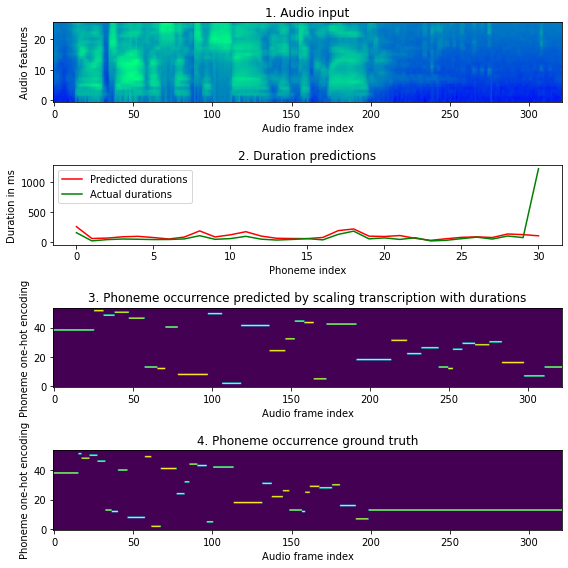

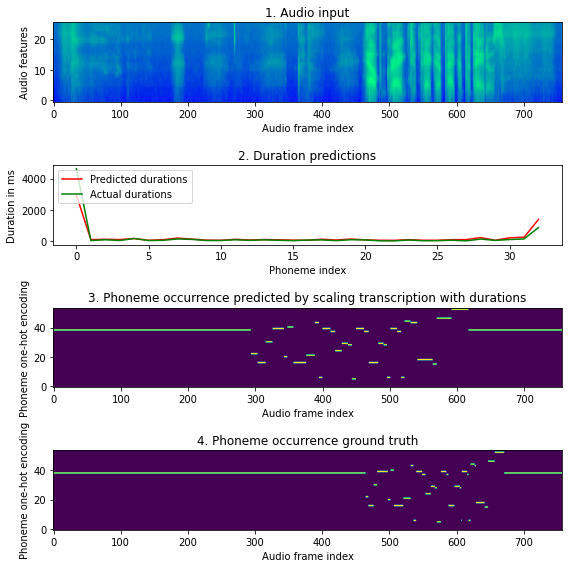

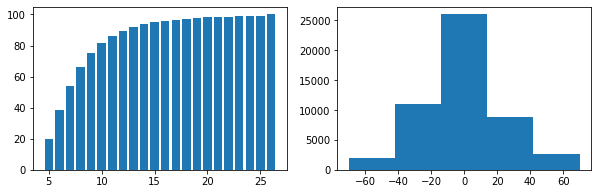

In [11]:
class MultyContextAttention(nn.Module):
    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size

        self.encoder = Encoder(hidden_size=embedding_size, embedding_size=embedding_size, num_layers=2, dropout=dropout, time_scale=None)

        self.encoder_transcription = Encoder(hidden_size=hidden_size, embedding_size=embedding_size, num_layers=2, dropout=dropout, time_scale=None)          
        self.decoder_transcription = Decoder(embedding_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=None)
        
        self.encoder_audio = Encoder(hidden_size=hidden_size, embedding_size=embedding_audio_size, num_layers=2, dropout=dropout, time_scale=None)
        self.decoder_audio = Decoder(embedding_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=None)
        
        self.direct = nn.Linear(embedding_size, hidden_size)
        self.fast = nn.Linear(hidden_size * 2, hidden_size)
        self.chain = nn.Linear(hidden_size, embedding_size)
        self.shuffle = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        
        self.device = device
        self.mode = "fast"
        # load(self, "/content/drive/My Drive/dataset/multy-attention-duration-derp2.pth", ignore=['pos_encode'])#, ignore='pos_encode;direct;out;shuffle'.split(';'))
        load(self, "/content/drive/My Drive/dataset/multy-attention-duration-normalized-3-[10-25].pth")
        # load(self,  "/content/drive/My Drive/dataset/multy-attention-duration-final-[5-25].pth")
        
    def forward(self, input_sequence, mask, features_audio, masks_audio):
        batch_size, out_seq_len, *features = input_sequence.shape

        encoded_inputs, hidden = self.encoder(input_sequence)

        if self.mode not in ['direct', 'audio']:
            encoder_transcription_outputs, hidden_transcription = self.encoder_transcription(input_sequence)

        if self.mode not in ['direct', 'trans']:
            encoder_audio_outputs, hidden_audio = self.encoder_audio(features_audio)
        
        if self.mode == "direct":
            output = self.direct(encoded_inputs)
        elif self.mode == "audio":
            output, hidden_audio = self.decoder_audio(encoded_inputs, hidden_audio, encoder_audio_outputs, masks_audio)
        elif self.mode == "trans":
            output, hidden_transcription = self.decoder_transcription(encoded_inputs, hidden_transcription, encoder_transcription_outputs, mask)

        elif self.mode == "fast":
            output_transcription, hidden_transcription = self.decoder_transcription(encoded_inputs, mask, hidden_transcription, encoder_transcription_outputs, mask)
            output_audio, hidden_audio = self.decoder_audio(encoded_inputs, mask, hidden_audio, encoder_audio_outputs, masks_audio)
            output = torch.cat((output_transcription, output_audio), 2)
            output = self.fast(output)
        
        elif self.mode == "chain":
            output_audio, hidden_audio = self.decoder_audio(encoded_inputs, hidden_audio, encoder_audio_outputs, masks_audio)
            # mangle the output to be acceptable for one more pass through the encoders
            output_audio, hidden_audio = self.chain(output_audio), hidden_audio + hidden_transcription
            # pass hidden audio as a hint
            output, hidden_transcription = self.decoder_transcription(output_audio, hidden_audio, encoder_transcription_outputs, mask)

        elif self.mode == "iter":
            output = torch.zeros(batch_size, out_seq_len, self.vocab_size).to(self.device) # tensor to store decoder outputs
            for t in range(out_seq_len):
                decoder_input = encoded_inputs[:,t:(t+1),:]

                output_transcription, hidden_transcription = self.decoder_transcription(decoder_input, hidden_transcription, encoder_transcription_outputs, mask)
                output_audio, hidden_audio = self.decoder_audio(decoder_input, hidden_audio, encoder_audio_outputs, masks_audio)

                out = torch.cat((output_transcription, output_audio), 2)
                output[:,t:(t+1),:] = self.out(out) 
            return F.relu(output)

        else:
            raise Exception("wrong mode")

        output = torch.log1p(F.relu(output))
        output = self.shuffle(output) 
        output = F.relu(output)
        output = self.out(output)
        output = F.relu(output)

        total_duration = masks_audio.sum(1) * ms_per_step if masks_audio is not None else features_audio.shape[1] * ms_per_step
        if mask is not None:
            # print(output.shape, mask.shape)
            # output = torch.bmm(output, mask.unsqueeze(2).float())
            output = (output * mask.unsqueeze(2).float())

        current_dur = (output.sum(1) * DURATION_SCALER).squeeze(1)
        # print(total_duration.shape, current_dur.shape)
    
        current_duration_scalers = total_duration / (current_dur)

        # print(current_duration_scalers.shape, current_duration_scalers)
        output = (output.squeeze(2) * current_duration_scalers.unsqueeze(1)).unsqueeze(2)
        # print(output.shape)
        # print((output.sum(1) * DURATION_SCALER).squeeze(1))
        # print(total_duration.shape, total_duration)
        # print(output.sum(1).shape, )
        # output = output * (total_duration / output.sum(1))
        # raise Exception
        return output

duration_combined_model = MultyContextAttention(KNOWN_LABELS_COUNT, INPUT_SIZE, 256, 1, device).to(device).eval()
evaluate(duration_combined_model, train_eval_dataset.batch(64), loss_function=MaskedLoss(), train_function=duration_trainer)
show_duration_og(duration_combined_model, test_dataset, sample_size=2000)
torch.cuda.empty_cache()
#  Evaluation on train - avg_loss: 0.0064 count:58 Total loss:0.3695
"""
[duration scaled] DIFF abs mean: 22.21ms (14.83) min:0.00ms max:3443.59ms
	38.2%	 < 10ms
	63.0%	 < 20ms
	77.4%	 < 30ms
	85.6%	 < 40ms
	90.4%	 < 50ms
	94.4%	 < 65ms
	97.0%	 < 85ms
	98.4%	 < 110ms
	99.2%	 < 140ms

[duration] DIFF abs mean: 22.15ms (14.53) min:0.00ms max:3456.12ms
	20.6%	 < 5ms		38.7%	 < 10ms	
	52.6%	 < 15ms		63.5%	 < 20ms	
	71.8%	 < 25ms		78.0%	 < 30ms	
	82.5%	 < 35ms		86.2%	 < 40ms	
	88.9%	 < 45ms		91.0%	 < 50ms	
	92.6%	 < 55ms		93.8%	 < 60ms	
	94.8%	 < 65ms		95.7%	 < 70ms	
	96.3%	 < 75ms		96.8%	 < 80ms	
	97.3%	 < 85ms		97.7%	 < 90ms	
	97.9%	 < 95ms		98.1%	 < 100ms	
	98.3%	 < 105ms		100.0%	 < 9999ms	
20.55% 38.66% 52.65% 63.49% 71.78% 78.00% 82.47% 86.16% 88.88% 90.98% 92.59% 93.85% 94.85% 95.68% 96.29% 96.81% 97.32% 97.66% 97.89% 98.09%
[position] DIFF abs mean: 284.06ms (276.45) min:0.01ms max:4280.40ms
	2.7%	 < 5ms		5.2%	 < 10ms	
	7.6%	 < 15ms		9.7%	 < 20ms	
	11.8%	 < 25ms		13.6%	 < 30ms	
	15.5%	 < 35ms		17.2%	 < 40ms	
	18.7%	 < 45ms		20.3%	 < 50ms	
	21.7%	 < 55ms		23.1%	 < 60ms	
	24.5%	 < 65ms		25.8%	 < 70ms	
	27.2%	 < 75ms		28.4%	 < 80ms	
	29.6%	 < 85ms		30.8%	 < 90ms	
	31.9%	 < 95ms		33.0%	 < 100ms	
	34.0%	 < 105ms		100.0%	 < 9999ms	
2.68% 5.23% 7.58% 9.69% 11.78% 13.65% 15.46% 17.16% 18.74% 20.29% 21.74% 23.13% 24.50% 25.82% 27.18% 28.41% 29.58% 30.80% 31.88% 33.02%

=====  AFTER SCALING
[duration] DIFF abs mean: 19.59ms (0.00) min:0.00ms max:1616.81ms
	20.4%	 < 5ms		39.1%	 < 10ms	
	54.5%	 < 15ms		66.5%	 < 20ms	
	75.4%	 < 25ms		81.9%	 < 30ms	
	86.4%	 < 35ms		89.8%	 < 40ms	
	92.1%	 < 45ms		93.7%	 < 50ms	
	95.0%	 < 55ms		96.0%	 < 60ms	
	96.7%	 < 65ms		97.2%	 < 70ms	
	97.7%	 < 75ms		98.0%	 < 80ms	
	98.3%	 < 85ms		98.5%	 < 90ms	
	98.7%	 < 95ms		98.8%	 < 100ms	
	98.9%	 < 105ms		100.0%	 < 9999ms	
20.37% 39.06% 54.51% 66.53% 75.40% 81.89% 86.43% 89.76% 92.07% 93.74% 95.00% 96.00% 96.69% 97.24% 97.65% 97.98% 98.27% 98.47% 98.67% 98.82% 
[position] DIFF abs mean: 71.81ms (-10.80) min:0.00ms max:1616.81ms
	8.1%	 < 5ms		13.3%	 < 10ms	
	18.5%	 < 15ms		23.4%	 < 20ms	
	28.5%	 < 25ms		33.1%	 < 30ms	
	37.7%	 < 35ms		42.1%	 < 40ms	
	46.2%	 < 45ms		50.0%	 < 50ms	
	53.7%	 < 55ms		57.1%	 < 60ms	
	60.2%	 < 65ms		63.1%	 < 70ms	
	65.8%	 < 75ms		68.3%	 < 80ms	
	70.7%	 < 85ms		73.0%	 < 90ms	
	75.2%	 < 95ms		77.0%	 < 100ms	
	78.8%	 < 105ms		100.0%	 < 9999ms	
8.06% 13.26% 18.49% 23.43% 28.47% 33.12% 37.68% 42.06% 46.24% 50.02% 53.69% 57.05% 60.17% 63.12% 65.76% 68.33% 70.73% 73.04% 75.16% 76.99%
""";



In [0]:
# loss_function = MaskedSoftL1(5)
# loss_function = MaskedMSE()
loss_function = MaskedLoss()
# loss_function = DivMaskedMSE(5)

train_batch_size = 64
if WIN_STEP < 0.010:
    train_batch_size = 16

train(duration_combined_model, 4, train_dataset.batch(train_batch_size), [train_eval_dataset.batch(64)], loss_function=loss_function, train_function=duration_trainer, lr_decay=0.98, lr=0.000015, weight_decay=1e-05)

# export_model(duration_combined_model, "/content/drive/My Drive/dataset/multy-attention-duration-normalized-3-[10-25].pth")
show_duration_og(duration_combined_model, test_dataset, sample_size=2000)
duration_combined_model.eval()
torch.cuda.empty_cache()

In [0]:
# draw_duration(duration_combined_model, test_dataset, 36)
# export_model(duration_combined_model, "/content/drive/My Drive/dataset/multy-attention-duration-final-[5-25].pth")


# POS = new

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


scale: 8.344777745411855
dataset len 1344
[id:933]  [  -15   781]    33 False
[id:848]  [ -770    81]    58 True
<function amax at 0x7fbcaf2a5bf8>
hh   32.98ms        oy   37.13ms        th   41.04ms        g    61.68ms        
nx   64.83ms        hv   65.73ms        sh   74.84ms        uw   82.26ms        
zh   85.11ms        v    87.53ms        ch   88.44ms        uh   93.80ms        
r    97.37ms        ng   103.88ms       aa   105.22ms       aw   109.03ms       
ao   112.37ms       ux   119.99ms       ow   123.67ms       gcl  131.27ms       
f    174.05ms       d    183.00ms       ae   209.37ms       z    216.32ms       
tcl  228.92ms       dcl  230.06ms       bcl  231.58ms       p    232.63ms       
ay   245.28ms       pcl  249.86ms       w    260.77ms       b    264.08ms       
ax   270.96ms       ah   282.43ms       dh   295.60ms       t    299.68ms       
m    304.65ms       eh   305.74ms       ix   312.43ms       y    333.21ms       
iy   338.35ms       l    341.65ms       kcl

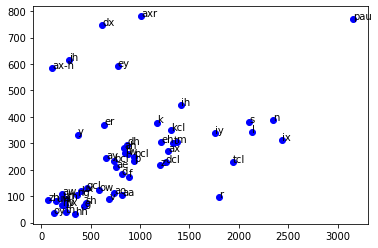

<function mean at 0x7fbcaf2ab950>
oy    5.28ms        ao    6.30ms        ux    6.34ms        w     6.37ms        
z     6.41ms        ng    6.42ms        r     6.44ms        hh    6.46ms        
ch    6.48ms        sh    6.57ms        pcl   6.59ms        m     6.60ms        
dcl   6.67ms        hv    6.67ms        iy    6.69ms        aa    6.71ms        
v     6.74ms        gcl   6.76ms        l     6.77ms        ax    6.79ms        
nx    6.79ms        th    6.82ms        t     6.84ms        bcl   6.85ms        
b     6.86ms        tcl   6.86ms        ae    6.94ms        ah    7.01ms        
ow    7.02ms        f     7.02ms        uw    7.04ms        g     7.04ms        
uh    7.06ms        pau   7.09ms        s     7.10ms        k     7.13ms        
aw    7.14ms        ix    7.20ms        y     7.21ms        p     7.26ms        
n     7.27ms        ey    7.30ms        kcl   7.32ms        d     7.34ms        
dh    7.37ms        er    7.38ms        eh    7.39ms        zh    7.43ms   

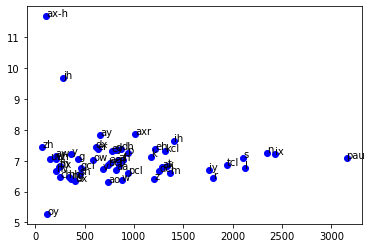

TOTAL 344564.47
[position] DIFF abs mean: 7.00ms (-0.40) min:0.00ms max:780.91ms
	55.98%	 < 5ms		81.91%	 < 10ms	
	90.88%	 < 15ms		94.60%	 < 20ms	
	96.60%	 < 25ms		97.78%	 < 30ms	
	98.47%	 < 35ms		98.86%	 < 40ms	
	99.15%	 < 45ms		99.34%	 < 50ms	
	99.47%	 < 55ms		99.56%	 < 60ms	
	99.63%	 < 65ms		99.65%	 < 70ms	
	99.68%	 < 75ms		99.70%	 < 80ms	
	99.72%	 < 85ms		99.74%	 < 90ms	
	99.75%	 < 95ms		99.77%	 < 100ms	
	99.79%	 < 105ms		99.99%	 < 9999ms	
55.98% 81.91% 90.88% 94.60% 96.60% 97.78% 98.47% 98.86% 99.15% 99.34% 99.47% 99.56% 99.63% 99.65% 99.68% 99.70% 99.72% 99.74% 99.75% 99.77% 
dataset len 3196
<function amax at 0x7fbcaf2a5bf8>
zh   24.97ms        nx   27.89ms        oy   28.53ms        hh   29.60ms        
ow   30.12ms        ch   32.20ms        aw   32.78ms        uw   33.06ms        
g    34.22ms        ae   34.53ms        z    34.61ms        r    34.94ms        
uh   35.01ms        d    35.17ms        ay   36.36ms        hv   36.86ms        
y    36.98ms        sh   37.41ms     

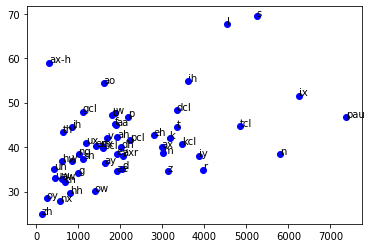

<function mean at 0x7fbcaf2ab950>
nx    4.86ms        ae    5.05ms        oy    5.07ms        pcl   5.16ms        
w     5.18ms        hh    5.20ms        r     5.21ms        bcl   5.22ms        
v     5.22ms        gcl   5.23ms        eh    5.24ms        hv    5.26ms        
ao    5.27ms        z     5.27ms        ay    5.28ms        m     5.30ms        
iy    5.32ms        k     5.32ms        uh    5.33ms        s     5.33ms        
dx    5.34ms        ix    5.34ms        t     5.34ms        n     5.35ms        
tcl   5.35ms        ow    5.35ms        g     5.35ms        aw    5.35ms        
er    5.36ms        d     5.36ms        jh    5.37ms        ax    5.38ms        
pau   5.38ms        dh    5.38ms        ng    5.39ms        ih    5.40ms        
ux    5.41ms        th    5.41ms        ah    5.42ms        aa    5.42ms        
uw    5.43ms        b     5.43ms        f     5.44ms        p     5.46ms        
l     5.47ms        axr   5.51ms        ch    5.51ms        kcl   5.52ms   

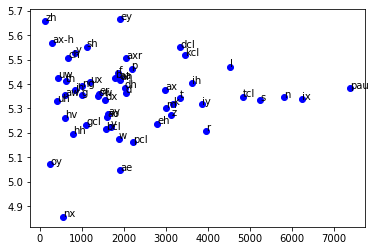

TOTAL 631228.06
[position] DIFF abs mean: 5.35ms (0.11) min:0.00ms max:69.44ms
	59.73%	 < 5ms		85.91%	 < 10ms	
	94.75%	 < 15ms		97.89%	 < 20ms	
	99.23%	 < 25ms		99.72%	 < 30ms	
	99.91%	 < 35ms		99.97%	 < 40ms	
	99.99%	 < 45ms		100.00%	 < 50ms	
	100.00%	 < 55ms		100.00%	 < 60ms	
	100.00%	 < 65ms		100.00%	 < 70ms	
	100.00%	 < 75ms		100.00%	 < 80ms	
	100.00%	 < 85ms		100.00%	 < 90ms	
	100.00%	 < 95ms		100.00%	 < 100ms	
	100.00%	 < 105ms		100.00%	 < 9999ms	
59.73% 85.91% 94.75% 97.89% 99.23% 99.72% 99.91% 99.97% 99.99% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 
 -  -  -  -  -  - WITHOUT -  -  -  -  -  - 
dataset len 1344
[id:933]  [  -15   781]    33 False
[id:848]  [ -770    81]    58 True
<function amax at 0x7fbcaf2a5bf8>
hh   32.98ms        oy   37.13ms        th   41.04ms        g    61.68ms        
nx   64.83ms        hv   65.73ms        sh   74.84ms        uw   82.26ms        
zh   85.11ms        v    87.53ms        ch   88.44ms        uh

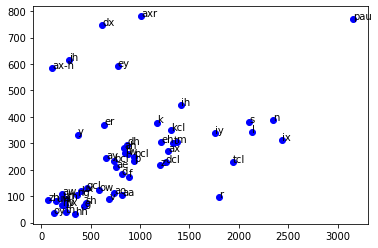

<function mean at 0x7fbcaf2ab950>
oy    5.28ms        ao    6.30ms        ux    6.34ms        w     6.37ms        
z     6.41ms        ng    6.42ms        r     6.45ms        hh    6.46ms        
ch    6.48ms        sh    6.57ms        pcl   6.59ms        m     6.60ms        
dcl   6.67ms        hv    6.67ms        iy    6.69ms        aa    6.71ms        
v     6.74ms        gcl   6.76ms        l     6.77ms        ax    6.79ms        
nx    6.79ms        th    6.82ms        t     6.84ms        bcl   6.85ms        
b     6.86ms        tcl   6.86ms        ae    6.94ms        ah    7.01ms        
ow    7.02ms        f     7.02ms        uw    7.04ms        g     7.04ms        
uh    7.06ms        pau   7.09ms        s     7.10ms        k     7.13ms        
aw    7.14ms        ix    7.20ms        y     7.21ms        p     7.26ms        
n     7.27ms        ey    7.30ms        kcl   7.32ms        d     7.34ms        
dh    7.37ms        er    7.38ms        eh    7.39ms        zh    7.43ms   

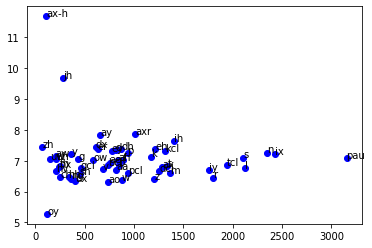

TOTAL 344595.2
[position] DIFF abs mean: 7.00ms (-0.40) min:0.00ms max:780.91ms
	55.98%	 < 5ms		81.91%	 < 10ms	
	90.88%	 < 15ms		94.60%	 < 20ms	
	96.60%	 < 25ms		97.78%	 < 30ms	
	98.47%	 < 35ms		98.85%	 < 40ms	
	99.14%	 < 45ms		99.33%	 < 50ms	
	99.46%	 < 55ms		99.55%	 < 60ms	
	99.63%	 < 65ms		99.65%	 < 70ms	
	99.68%	 < 75ms		99.70%	 < 80ms	
	99.72%	 < 85ms		99.74%	 < 90ms	
	99.75%	 < 95ms		99.77%	 < 100ms	
	99.79%	 < 105ms		99.99%	 < 9999ms	
55.98% 81.91% 90.88% 94.60% 96.60% 97.78% 98.47% 98.85% 99.14% 99.33% 99.46% 99.55% 99.63% 99.65% 99.68% 99.70% 99.72% 99.74% 99.75% 99.77% 
dataset len 3196
<function amax at 0x7fbcaf2a5bf8>
zh   24.97ms        nx   27.89ms        oy   28.53ms        hh   29.60ms        
ow   30.12ms        ch   32.20ms        aw   32.78ms        uw   33.06ms        
g    34.22ms        ae   34.53ms        z    34.61ms        r    34.94ms        
uh   35.01ms        d    35.17ms        ay   36.36ms        hv   36.86ms        
y    36.98ms        sh   37.41ms      

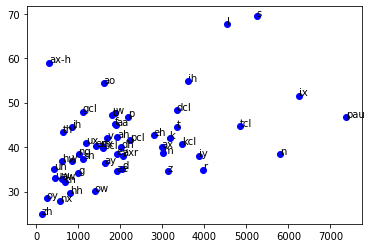

<function mean at 0x7fbcaf2ab950>
nx    4.86ms        ae    5.05ms        oy    5.07ms        pcl   5.16ms        
w     5.18ms        hh    5.20ms        r     5.21ms        bcl   5.22ms        
v     5.22ms        gcl   5.23ms        eh    5.24ms        hv    5.26ms        
ao    5.27ms        z     5.27ms        ay    5.28ms        m     5.30ms        
iy    5.32ms        k     5.32ms        uh    5.33ms        s     5.33ms        
dx    5.34ms        ix    5.34ms        t     5.34ms        n     5.35ms        
tcl   5.35ms        ow    5.35ms        g     5.35ms        aw    5.35ms        
er    5.36ms        d     5.36ms        jh    5.37ms        ax    5.38ms        
pau   5.38ms        dh    5.38ms        ng    5.39ms        ih    5.40ms        
ux    5.41ms        th    5.41ms        ah    5.42ms        aa    5.42ms        
uw    5.43ms        b     5.43ms        f     5.44ms        p     5.46ms        
l     5.47ms        axr   5.51ms        ch    5.51ms        kcl   5.52ms   

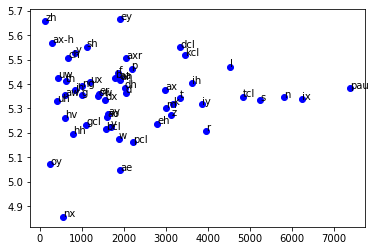

TOTAL 631228.06
[position] DIFF abs mean: 5.35ms (0.11) min:0.00ms max:69.44ms
	59.73%	 < 5ms		85.91%	 < 10ms	
	94.75%	 < 15ms		97.89%	 < 20ms	
	99.23%	 < 25ms		99.72%	 < 30ms	
	99.91%	 < 35ms		99.97%	 < 40ms	
	99.99%	 < 45ms		100.00%	 < 50ms	
	100.00%	 < 55ms		100.00%	 < 60ms	
	100.00%	 < 65ms		100.00%	 < 70ms	
	100.00%	 < 75ms		100.00%	 < 80ms	
	100.00%	 < 85ms		100.00%	 < 90ms	
	100.00%	 < 95ms		100.00%	 < 100ms	
	100.00%	 < 105ms		100.00%	 < 9999ms	
59.73% 85.91% 94.75% 97.89% 99.23% 99.72% 99.91% 99.97% 99.99% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 
Fri May 15 08:48:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|     

In [14]:
class PositionSimple(nn.Module):
    class Mode:
        weights = "weights"
        position = "position"
        gradient = "gradient"
        argmax = "argmax"

    def __getattr__(self, item):
        cleaned = item.replace("is_", "").replace("with_", "")
        if hasattr(self.Mode, cleaned):
            mode = getattr(self.Mode, cleaned)
            if "is_" in item:
                return self.mode == mode
            elif "with_" in item:
                self.mode = mode
                return self
        return super().__getattr__(item)

    def __dir__(self):
        return super().__dir__() + [f"is_{k}" for k in self.Mode.keys] + [f"with_{k}" for k in self.Mode.keys]

    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, attention_size=None, dropout=0.35):
        super().__init__()
        out_dim = hidden_size # vocab_size
        self.encoder_transcription = Encoder(hidden_size, embedding_size, out_dim=out_dim, num_layers=2, dropout=dropout, time_scale=POS_TRANSCRIPTION_SCALE)

        self.encoder_audio = Encoder(hidden_size, embedding_audio_size, out_dim=out_dim, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
 
        # self.encoder_transcription_2 = Encoder(hidden_size, out_dim, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=None)
        # self.encoder_audio_2 = Encoder(hidden_size, out_dim, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)

        self.attn = Attention(None)
        self.gradient = (torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1).cuda()
        self.zero = torch.zeros(256, 2048, vocab_size).to(device)
        self.pos_encode = PositionalEncoding(vocab_size, dropout, scale=POS_SCALE)

        print("scale:", POS_TRANSCRIPTION_SCALE)
        self.vocab_size = vocab_size
        self.device = device
        self.to(device)
        self.mode = self.Mode.gradient
        self.flags = {}
        self.use_iter = True
        self.use_pos_encode = True

        self.t_transformer = nn.Sequential(
            nn.Linear(embedding_size, 32),
            nn.Sigmoid(),
            nn.Linear(32, embedding_size),
            nn.Sigmoid()
        ).to(device)

        self.a_transformer = nn.Sequential(
            nn.Linear(embedding_audio_size, 32),
            nn.Sigmoid(),
            nn.Linear(32, embedding_audio_size),
            nn.Sigmoid()
        ).to(device)


    def weights_to_positions(self, weights, argmax=False):
        batch_size, audio_size, input_size = weights.shape

        batch, trans_len, seq_len = weights.shape
        if argmax:
            return weights.max(2)[1][:,:-1]
        positions = (self.gradient[:seq_len] * weights.transpose(1, 2)).sum(1)[:,:-1]
        return positions

    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
        features_transcription = features_transcription.clone()
        features_transcription[:,:-1] += features_transcription[:,1:] * 0.55

        features_transcription = self.t_transformer(features_transcription)
        features_audio = self.a_transformer(features_audio)

        encoder_transcription_outputs, _ = self.encoder_transcription(features_transcription, skip_pos_encode=not self.use_pos_encode) # # # #

        encoder_audio_outputs, _ = self.encoder_audio(features_audio, skip_pos_encode=not self.use_pos_encode)
        

        # w = self.attn(F.tanh(encoder_transcription_outputs), mask_transcription, F.tanh(encoder_audio_outputs), mask_audio)

        if "iter" and True:
            encoder_transcription_outputs = F.relu(encoder_transcription_outputs)
            encoder_audio_outputs = F.relu(encoder_audio_outputs)
            # tensor to store decoder outputs
            batch_size, out_seq_len, _ = features_transcription.shape
            w = torch.zeros(batch_size, out_seq_len, features_audio.shape[1]).to(self.device)
            
            w_masks, w_mask, iter_mask_audio = [], None, mask_audio
            for t in range(out_seq_len):
                iter_input = encoder_transcription_outputs[:,t:(t+1),:]
                iter_memory = encoder_audio_outputs

                if len(w_masks) > 1:
                    w_mask = w_masks[0]
                    w_mask_b = w_masks[1]

                    w_mask = torch.clamp(w_mask, min=0.0, max=1)
                    w_mask[w_mask < 0.1] = 0
                    w_mask[w_mask > 0.1] = 1

                    w_mask_b = torch.clamp(w_mask_b, min=0.0, max=1)
                    w_mask_b[w_mask_b < 0.1] = 0

                    pad = 0.00
                    a, b = torch.split(iter_memory, 128, dim=2)
                    a = a * (w_mask.unsqueeze(2) * (1 - pad) + pad)
                    b = b * (w_mask_b.unsqueeze(2) * (1 - pad) + pad)
                    iter_memory = torch.cat([a, b], dim=2)
                    iter_mask_audio = mask_audio * ( w_mask > 0.1) if mask_audio is not None else w_mask > 0.1

                    # iter_memory = iter_memory * (w_mask.unsqueeze(2) * (1 - pad) + pad)
                # print(iter_input.shape, mask_transcription.shape, (iter_memory).shape, iter_mask_audio.shape)
                iter_mask_transcription = mask_transcription[:,t:(t+1)] if mask_transcription is not None else None
                w_slice = self.attn(iter_input, iter_mask_transcription, (iter_memory), iter_mask_audio)

                if w_mask is not None:
                    w[:,t:(t+1), :] = w_slice * w_mask.unsqueeze(1)
                else:
                    w[:,t:(t+1), :] = w_slice

                w_mask = w_slice.squeeze(1).clone()
                w_mask = torch.cumsum(w_mask, dim=1).detach()
                w_masks.append(w_mask)
                w_masks = w_masks[-2:]


        # elif self.use_iter:
        #     encoder_transcription_outputs = F.tanh(encoder_transcription_outputs)
        #     encoder_audio_outputs = F.tanh(encoder_audio_outputs)
        #     # tensor to store decoder outputs
        #     batch_size, out_seq_len, _ = features_transcription.shape
        #     w = torch.zeros(batch_size, out_seq_len, features_audio.shape[1]).to(self.device)
            
        #     w_masks, w_mask, iter_mask_audio = [], None, mask_audio
        #     for t in range(out_seq_len):
        #         iter_input = encoder_transcription_outputs[:,t:(t+1),:]
        #         iter_memory = encoder_audio_outputs

        #         if len(w_masks) > 1:
        #             w_mask = w_masks[0]
        #             w_mask_b = w_masks[1]

        #             # w_mask = torch.clamp(w_mask, min=0.0, max=1)
        #             # w_mask[w_mask < 0.45] = 0
        #             w_mask[w_mask > 0.1] = 1
        #             # TODO: combine masks of previos two

        #             # w_mask_b = torch.clamp(w_mask_b, min=0.0, max=1)
        #             # w_mask_b[w_mask_b < 0.1] = 0

        #             pad = 0.0
        #             # a, b = torch.split(iter_memory, 128, dim=2)
        #             # a = a * (w_mask.unsqueeze(2) * (1 - pad) + pad)
        #             # b = b * (w_mask_b.unsqueeze(2) * (1 - pad) + pad)
        #             # iter_memory = torch.cat([a, b], dim=2)
        #             low = 0.1
        #             iter_mask_audio = mask_audio * (w_mask > low) if mask_audio is not None else w_mask > low

        #             iter_memory = iter_memory * (w_mask.unsqueeze(2) * (1 - pad) + pad)

        #         w_slice = self.attn(iter_input, mask_transcription[:,t:(t+1)], iter_memory, iter_mask_audio)

        #         if w_mask is not None and 0:
        #             w[:,t:(t+1), :] = w_slice * w_mask.unsqueeze(1)
        #         else:
        #             w[:,t:(t+1), :] = w_slice

        #         w_mask = w_slice.squeeze(1).clone()
        #         w_mask = torch.cumsum(w_mask, dim=1).detach()
        #         w_masks.append(w_mask)
        #         w_masks = w_masks[-2:]

        if self.is_weights:
            return w

        if self.is_gradient or self.is_argmax:
            return self.weights_to_positions(w, argmax=self.is_argmax)

        batch, seq_len, dimensions = encoder_audio_outputs.shape
        processsed_audio = self.zero[:batch,:seq_len,:self.vocab_size]
        pos = self.pos_encode(processsed_audio)
        position_encodes = torch.bmm(w, pos)

        if self.is_position:
            return position_encodes[:,:-1]
        

position_model = PositionSimple(KNOWN_LABELS_COUNT, INPUT_SIZE, 256, POS_DIM, device).to(device)
# train(position_model, 10, toy_dataset.batch(64), toy_dataset.batch(128), loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.91, lr=0.00151)
# load(position_model, "/content/drive/My Drive/dataset/position_model-reforged-repeat-10.pth") # 7 is ok, 8, 10 is cool, 
# load(position_model, "/content/drive/My Drive/dataset/position_model-normalized-2.pth") # 7 is ok, 8, 10 is cool,  1.5
# load(position_model, "/content/drive/My Drive/dataset/position_model-pure-6.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-pure-derp.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-pure-12.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-revive-2.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-simple-final.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-final.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-final-2.pth")
# load(position_model, "/content/drive/My Drive/dataset/position_model-final-3.pth")
load(position_model, "/content/drive/My Drive/dataset/position_model-final-4.pth")

# load(position_model, "/content/drive/My Drive/dataset/position_model-derp.pth")

"""
load(position_model, "/content/drive/My Drive/dataset/position_model-final-4.pth")
TOTAL 344903.16
[position] DIFF abs mean: 7.01ms (-0.39) min:0.00ms max:780.91ms
	55.97%	 < 5ms		81.93%	 < 10ms	
	90.88%	 < 15ms		94.61%	 < 20ms	
	96.62%	 < 25ms		97.79%	 < 30ms	
	98.48%	 < 35ms		98.87%	 < 40ms	
	99.15%	 < 45ms		99.35%	 < 50ms	
	99.48%	 < 55ms		99.57%	 < 60ms	
	99.65%	 < 65ms		99.67%	 < 70ms	
	99.70%	 < 75ms		99.72%	 < 80ms	
	99.74%	 < 85ms		99.76%	 < 90ms	
	99.77%	 < 95ms		99.79%	 < 100ms	
	99.81%	 < 105ms		100.01%	 < 9999ms	
55.97% 81.93% 90.88% 94.61% 96.62% 97.79% 98.48% 98.87% 99.15% 99.35% 99.48% 99.57% 99.65% 99.67% 99.70% 99.72% 99.74% 99.76% 99.77% 99.79%
"""
position_model.with_gradient

def eval_border_agreement(duration_combined_model=None):
    show_position_batched(position_model.with_gradient, test_dataset, duration_combined_model=duration_combined_model)
    show_position_batched(position_model.with_gradient, train_dataset, duration_combined_model=duration_combined_model)
    if duration_combined_model is not None:
        print(" -  -  -  -  -  - WITHOUT -  -  -  -  -  - ")
        show_position_batched(position_model.with_gradient, test_dataset)
        show_position_batched(position_model.with_gradient, train_dataset)

# evaluate(position_model, train_dataset.batch(64), loss_function=MaskedMSE(), train_function=position_gradient_trainer) # 0.15
# evaluate(position_model, test_dataset.batch(64), loss_function=MaskedMSE(), train_function=position_gradient_trainer) # 2.1
eval_border_agreement(duration_combined_model=duration_combined_model)
torch.cuda.empty_cache()
!nvidia-smi

## Training

CUTOFF 1.5
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 9.701860000000001e-08
    weight_decay: 0.00014000000000000001
)
  Evaluation[] - avg_loss: 0.0083098 count:21 Total loss:0.1745065
  Evaluation[] - avg_loss: 0.0052727 count:8 Total loss:0.0421818
Starting epoch 1, learning rate is 0.000000


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


  Evaluation[] - avg_loss: 0.0082983 count:21 Total loss:0.1742646
  Evaluation[] - avg_loss: 0.0052510 count:8 Total loss:0.0420083
Starting epoch 2, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082922 count:21 Total loss:0.1741355
  Evaluation[] - avg_loss: 0.0052390 count:8 Total loss:0.0419121
Starting epoch 3, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082651 count:21 Total loss:0.1735674
  Evaluation[] - avg_loss: 0.0052380 count:8 Total loss:0.0419043
Starting epoch 4, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0083673 count:21 Total loss:0.1757133
  Evaluation[] - avg_loss: 0.0052633 count:8 Total loss:0.0421063
Starting epoch 5, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0083331 count:21 Total loss:0.1749946
  Evaluation[] - avg_loss: 0.0052291 count:8 Total loss:0.0418324
Starting epoch 6, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082515 count:21 Total loss:0.1732813
  Evaluation[] - avg_loss: 0.0052344 count:8 Tot

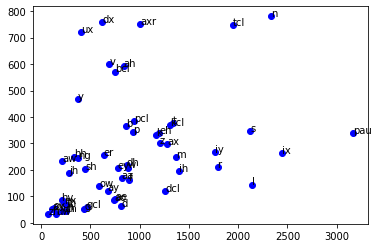

<function mean at 0x7fded7647950>
uw    5.49ms        ao    6.00ms        ch    6.13ms        ax-h  6.22ms        
ow    6.25ms        d     6.41ms        g     6.41ms        aa    6.45ms        
gcl   6.49ms        sh    6.51ms        zh    6.52ms        ae    6.57ms        
l     6.60ms        ay    6.65ms        kcl   6.65ms        ey    6.68ms        
r     6.69ms        dh    6.70ms        th    6.74ms        dcl   6.76ms        
f     6.77ms        hv    6.78ms        ih    6.79ms        t     6.80ms        
s     6.83ms        m     6.87ms        eh    6.88ms        pcl   6.89ms        
p     6.93ms        z     6.98ms        tcl   7.00ms        pau   7.01ms        
k     7.04ms        axr   7.11ms        iy    7.13ms        bcl   7.15ms        
b     7.17ms        nx    7.19ms        ix    7.22ms        ng    7.24ms        
er    7.26ms        w     7.27ms        oy    7.29ms        uh    7.36ms        
ax    7.36ms        ah    7.37ms        hh    7.42ms        aw    7.61ms   

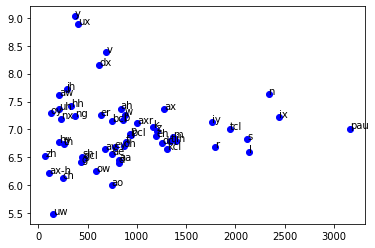

TOTAL 344080.88
[position] DIFF abs mean: 6.99ms (-0.42) min:0.00ms max:780.38ms
	56.15%	 < 5ms		81.95%	 < 10ms	
	90.94%	 < 15ms		94.65%	 < 20ms	
	96.65%	 < 25ms		97.79%	 < 30ms	
	98.46%	 < 35ms		98.86%	 < 40ms	
	99.14%	 < 45ms		99.32%	 < 50ms	
	99.48%	 < 55ms		99.55%	 < 60ms	
	99.63%	 < 65ms		99.65%	 < 70ms	
	99.68%	 < 75ms		99.70%	 < 80ms	
	99.73%	 < 85ms		99.75%	 < 90ms	
	99.76%	 < 95ms		99.78%	 < 100ms	
	99.80%	 < 105ms		100.00%	 < 9999ms	
56.15% 81.95% 90.94% 94.65% 96.65% 97.79% 98.46% 98.86% 99.14% 99.32% 99.48% 99.55% 99.63% 99.65% 99.68% 99.70% 99.73% 99.75% 99.76% 99.78% 
dataset len 3196
<function amax at 0x7fded7641bf8>
uh   25.04ms        hh   30.52ms        ae   30.73ms        oy   30.74ms        
jh   31.32ms        nx   31.34ms        g    31.56ms        ao   31.66ms        
sh   33.09ms        uw   33.24ms        hv   33.39ms        b    33.69ms        
zh   33.85ms        ch   34.08ms        er   34.13ms        aw   34.21ms        
d    34.26ms        th   35.16ms    

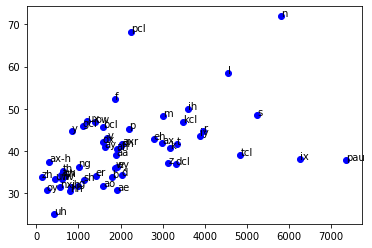

<function mean at 0x7fded7647950>
dcl   5.06ms        d     5.11ms        w     5.14ms        sh    5.16ms        
ey    5.16ms        uh    5.17ms        g     5.17ms        ax-h  5.18ms        
z     5.18ms        ng    5.19ms        m     5.21ms        jh    5.21ms        
ao    5.24ms        pau   5.24ms        aa    5.26ms        hh    5.26ms        
th    5.26ms        ux    5.29ms        b     5.30ms        ix    5.32ms        
er    5.32ms        kcl   5.32ms        v     5.32ms        dx    5.32ms        
ae    5.33ms        ax    5.33ms        t     5.33ms        l     5.34ms        
axr   5.35ms        r     5.35ms        k     5.35ms        f     5.35ms        
tcl   5.35ms        ih    5.35ms        pcl   5.39ms        iy    5.39ms        
ch    5.40ms        s     5.40ms        ah    5.42ms        dh    5.42ms        
n     5.43ms        hv    5.45ms        bcl   5.46ms        ow    5.48ms        
eh    5.49ms        ay    5.51ms        aw    5.54ms        zh    5.55ms   

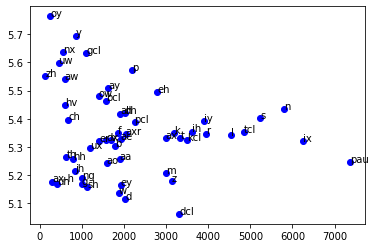

TOTAL 628654.3
[position] DIFF abs mean: 5.33ms (0.11) min:0.00ms max:71.96ms
	59.87%	 < 5ms		85.99%	 < 10ms	
	94.83%	 < 15ms		97.92%	 < 20ms	
	99.23%	 < 25ms		99.72%	 < 30ms	
	99.90%	 < 35ms		99.95%	 < 40ms	
	99.97%	 < 45ms		99.98%	 < 50ms	
	99.98%	 < 55ms		99.98%	 < 60ms	
	99.98%	 < 65ms		99.98%	 < 70ms	
	99.98%	 < 75ms		99.98%	 < 80ms	
	99.98%	 < 85ms		99.98%	 < 90ms	
	99.98%	 < 95ms		99.98%	 < 100ms	
	99.98%	 < 105ms		99.98%	 < 9999ms	
59.87% 85.99% 94.83% 97.92% 99.23% 99.72% 99.90% 99.95% 99.97% 99.98% 99.98% 99.98% 99.98% 99.98% 99.98% 99.98% 99.98% 99.98% 99.98% 99.98% 


In [0]:
torch.cuda.empty_cache()

class DivMaskedMSE(nn.Module):
    mse = nn.MSELoss()
    l1 = nn.L1Loss()
    def __init__(self, cutoff, flip=False):
        super().__init__()
        self.cutoff = cutoff
        self.flip = flip
        print("CUTOFF", cutoff)
    
    def forward(self, pred, target, mask, weight):
        # print(weight.shape)
        diff = torch.abs(pred - target)
        if not self.flip:
            diff = diff > (self.cutoff or random.randint(0, 3))
        else:
            diff = diff < (self.cutoff or random.randint(0, 3))

        pred = pred * weight[:,:-1]
        target = target * weight[:,:-1]

        mask_diff = mask & diff
        pred = torch.mul(pred, mask_diff)
        target = torch.mul(target, mask_diff)
        mse = self.mse(pred, target)
        # return mse

        mask_diff = mask & ~diff
        pred = torch.mul(pred, mask_diff)
        target = torch.mul(target, mask_diff)
        l1 = self.l1(pred, target)

        return mse + l1

class MaskedL1(nn.Module):
    l1 = nn.L1Loss()
    
    def forward(self, pred, target, mask):
        pred = torch.mul(pred, mask)
        target = torch.mul(target, mask)
        l1 = self.l1(pred, target)

        return l1


class MaskedThing(nn.Module):
    l1 = nn.L1Loss()
    mse = nn.MSELoss()
    
    def forward(self, pred, target, mask):
        pred = torch.log1p(F.relu(pred))
        target = torch.log1p(F.relu(target))
        pred = torch.mul(pred, mask)
        target = torch.mul(target, mask)
        l1 = self.mse(pred, target)

        return l1

# toy_dataset = DirectMaskDataset(train_files, limit=2043)
work_dataset = train_dataset
# work_dataset = train_augment_dataset

evaluation = [toy_dataset.batch(64)]
evaluation = [test_dataset.batch(64), train_eval_dataset.batch(64)]

train_batch_size = 32
if WIN_STEP < 0.010:
    train_batch_size = 16

f = .35
n = 1
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_gradient, int(10 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.951, lr= f * 0.000161 * 0.131 * .10, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_position, int(8 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=CosineLoss(), train_function=position_encode_trainer, lr_decay=0.93, lr= f * 0.000051 * 0.005)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_gradient, int(8 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.991, lr= f * 0.000161 * 0.131 * 3.1 * 0.01, weight_decay=1e-05 * 14)

# export_model(position_model, "/content/drive/My Drive/dataset/position_model-pure-derp.pth") 
# show_position_batched(position_model, toy_dataset, report_error=750)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# NORMAL
# train(position_model.with_gradient, int(10 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .01, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_gradient, int(9 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(10, flip=True), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .05, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_gradient, int(30 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(13, flip=False), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_gradient, int(30 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(5, flip=False), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)

# train(position_model.with_gradient, int(30 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(21, flip=False), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)


# torch.cuda.empty_cache()
# for i in range(10, 0, -1):
#     f = .25
#     # n= 0.8
#     load(position_model, "/content/drive/My Drive/dataset/position_model-final-3.pth")
#     train(position_model.with_gradient, int(5 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(i, flip=False), train_function=position_gradient_trainer, lr_decay=0.985, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
#     eval_border_agreement(duration_combined_model=duration_combined_model)

torch.cuda.empty_cache()
f = .023
n= 1.8
# load(position_model, "/content/drive/My Drive/dataset/position_model-final-3.pth")
train(position_model.with_gradient, int(5 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(1.5, flip=False), train_function=position_gradient_trainer, lr_decay=0.985, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
# train(position_model.with_gradient, int(5 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.985, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
eval_border_agreement(duration_combined_model=None)
# export_model(position_model, "/content/drive/My Drive/dataset/position_model-derp.pth") 

# SIMPLE
# train(position_model.with_gradient, int(30 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * 3.1, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)
# train(position_model.with_gradient, int(10 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(5), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .1, weight_decay=1e-05 * 14)
# eval_border_agreement(duration_combined_model=duration_combined_model)
# train(position_model.with_gradient, int(10 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(5), train_function=position_gradient_trainer, lr_decay=0.98, lr= f * 0.000161 * 0.131 * .1, weight_decay=1e-05 * 14)
# train(position_model.with_position, int(30 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=CosineLoss(), train_function=position_encode_trainer, lr_decay=0.93, lr= f * 0.000051 * 0.03)
# eval_border_agreement(duration_combined_model=duration_combined_model)

torch.cuda.empty_cache()

# 49.97% 77.86% 89.11% 93.87% 96.27% 97.61% 98.35% 98.84% 99.13% 99.33% 99.46% 99.57% 99.61% 99.69% 99.73% 99.75% 99.77% 99.78% 99.79% 99.81% 
# 56.05% 81.85% 90.93% 94.65% 96.66% 97.77% 98.47% 98.88% 99.16% 99.34% 99.49% 99.54% 99.62% 99.65% 99.68% 99.70% 99.72% 99.74% 99.75% 99.77%
# % % % % % % % % % % % % % % % % % % % % 
# 55.97% 81.93% 90.88% 94.61% 96.62% 97.79% 98.48% 98.87% 99.15% 99.35% 99.48% 99.57% 99.65% 99.67% 99.70% 99.72% 99.74% 99.76% 99.77% 99.79%

CUTOFF 1.5
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 9.701860000000001e-08
    weight_decay: 0.00014000000000000001
)
  Evaluation[] - avg_loss: 0.0082186 count:21 Total loss:0.1725910
  Evaluation[] - avg_loss: 0.0052283 count:8 Total loss:0.0418265
Starting epoch 1, learning rate is 0.000000


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


  Evaluation[] - avg_loss: 0.0082846 count:21 Total loss:0.1739764
  Evaluation[] - avg_loss: 0.0052280 count:8 Total loss:0.0418237
Starting epoch 2, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082668 count:21 Total loss:0.1736022
  Evaluation[] - avg_loss: 0.0052117 count:8 Total loss:0.0416938
Starting epoch 3, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082858 count:21 Total loss:0.1740021
  Evaluation[] - avg_loss: 0.0052002 count:8 Total loss:0.0416017
Starting epoch 4, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0083323 count:21 Total loss:0.1749791
  Evaluation[] - avg_loss: 0.0052155 count:8 Total loss:0.0417239
Starting epoch 5, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082972 count:21 Total loss:0.1742406
  Evaluation[] - avg_loss: 0.0052176 count:8 Total loss:0.0417405
Starting epoch 6, learning rate is 0.000000
  Evaluation[] - avg_loss: 0.0082159 count:21 Total loss:0.1725329
  Evaluation[] - avg_loss: 0.0052197 count:8 Tot

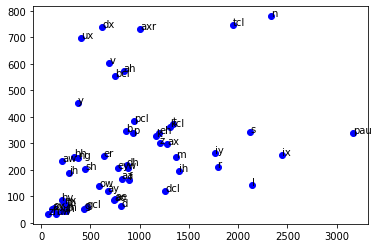

<function mean at 0x7fded7647950>
uw    5.49ms        ao    6.00ms        ch    6.14ms        ax-h  6.22ms        
ow    6.25ms        d     6.41ms        g     6.41ms        aa    6.45ms        
gcl   6.49ms        sh    6.52ms        zh    6.53ms        ae    6.56ms        
l     6.59ms        kcl   6.65ms        ay    6.65ms        ey    6.69ms        
r     6.69ms        dh    6.71ms        th    6.74ms        dcl   6.76ms        
f     6.77ms        hv    6.79ms        t     6.79ms        ih    6.80ms        
s     6.83ms        m     6.87ms        eh    6.88ms        pcl   6.89ms        
p     6.92ms        z     6.98ms        tcl   7.00ms        pau   7.01ms        
k     7.04ms        axr   7.09ms        bcl   7.11ms        iy    7.13ms        
b     7.15ms        nx    7.19ms        ix    7.22ms        ng    7.24ms        
er    7.25ms        w     7.26ms        oy    7.28ms        ah    7.35ms        
uh    7.36ms        ax    7.37ms        hh    7.42ms        aw    7.61ms   

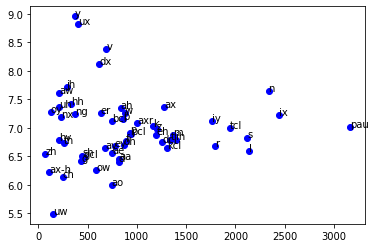

TOTAL 343909.16
[position] DIFF abs mean: 6.99ms (-0.43) min:0.00ms max:780.02ms
	56.16%	 < 5ms		81.97%	 < 10ms	
	90.93%	 < 15ms		94.64%	 < 20ms	
	96.65%	 < 25ms		97.79%	 < 30ms	
	98.47%	 < 35ms		98.86%	 < 40ms	
	99.15%	 < 45ms		99.33%	 < 50ms	
	99.48%	 < 55ms		99.56%	 < 60ms	
	99.64%	 < 65ms		99.66%	 < 70ms	
	99.70%	 < 75ms		99.72%	 < 80ms	
	99.74%	 < 85ms		99.76%	 < 90ms	
	99.77%	 < 95ms		99.78%	 < 100ms	
	99.80%	 < 105ms		100.00%	 < 9999ms	
56.16% 81.97% 90.93% 94.64% 96.65% 97.79% 98.47% 98.86% 99.15% 99.33% 99.48% 99.56% 99.64% 99.66% 99.70% 99.72% 99.74% 99.76% 99.77% 99.78% 
dataset len 3196
<function amax at 0x7fded7641bf8>
uh   25.15ms        hh   30.69ms        ae   30.75ms        oy   30.81ms        
jh   31.35ms        nx   31.70ms        ao   31.75ms        g    32.09ms        
sh   33.03ms        uw   33.47ms        b    33.63ms        hv   33.85ms        
zh   33.89ms        ch   34.14ms        d    34.27ms        aw   34.41ms        
er   34.49ms        th   35.45ms    

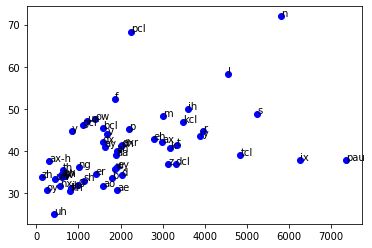

<function mean at 0x7fded7647950>
dcl   5.06ms        d     5.12ms        w     5.14ms        sh    5.16ms        
ey    5.17ms        uh    5.17ms        g     5.17ms        ax-h  5.18ms        
z     5.18ms        ng    5.19ms        m     5.21ms        jh    5.21ms        
ao    5.24ms        pau   5.25ms        aa    5.26ms        hh    5.26ms        
th    5.27ms        ux    5.30ms        b     5.30ms        ix    5.32ms        
er    5.32ms        v     5.32ms        kcl   5.32ms        dx    5.32ms        
ae    5.33ms        ax    5.33ms        t     5.33ms        l     5.34ms        
axr   5.35ms        r     5.35ms        k     5.35ms        f     5.35ms        
tcl   5.35ms        ih    5.36ms        pcl   5.39ms        iy    5.39ms        
ch    5.40ms        s     5.41ms        ah    5.42ms        dh    5.42ms        
n     5.44ms        hv    5.45ms        bcl   5.47ms        ow    5.48ms        
eh    5.50ms        ay    5.51ms        aw    5.54ms        zh    5.56ms   

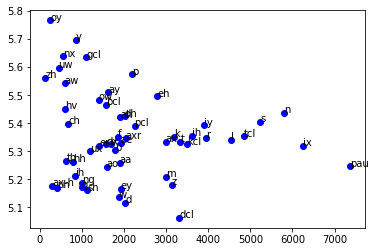

TOTAL 628895.0
[position] DIFF abs mean: 5.34ms (0.09) min:0.00ms max:71.97ms
	59.83%	 < 5ms		85.98%	 < 10ms	
	94.81%	 < 15ms		97.92%	 < 20ms	
	99.24%	 < 25ms		99.74%	 < 30ms	
	99.92%	 < 35ms		99.97%	 < 40ms	
	99.99%	 < 45ms		100.00%	 < 50ms	
	100.00%	 < 55ms		100.00%	 < 60ms	
	100.00%	 < 65ms		100.00%	 < 70ms	
	100.00%	 < 75ms		100.00%	 < 80ms	
	100.00%	 < 85ms		100.00%	 < 90ms	
	100.00%	 < 95ms		100.00%	 < 100ms	
	100.00%	 < 105ms		100.00%	 < 9999ms	
59.83% 85.98% 94.81% 97.92% 99.24% 99.74% 99.92% 99.97% 99.99% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 100.00% 


In [0]:
train(position_model.with_gradient, int(5 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(1.5, flip=False), train_function=position_gradient_trainer, lr_decay=0.985, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
# train(position_model.with_gradient, int(5 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=MaskedMSE(), train_function=position_gradient_trainer, lr_decay=0.985, lr= f * 0.000161 * 0.131 * .2, weight_decay=1e-05 * 14)
eval_border_agreement(duration_combined_model=None)

In [0]:
                                                            work_dataset = train_augment_dataset
train(position_model.with_gradient, int(10 * n), work_dataset.batch(train_batch_size), evaluation, loss_function=DivMaskedMSE(5, flip=False), train_function=position_gradient_trainer, lr_decay=0.985, lr= f * 0.000161 * 0.131 * .1, weight_decay=1e-05 * 14)
eval_border_agreement(duration_combined_model=duration_combined_model)

In [0]:
# export_model(position_model, "/content/drive/My Drive/dataset/position_model-final-4.pth") 

# eval_border_agreement(duration_combined_model=duration_combined_model)
# export_model(position_model, "/content/drive/My Drive/dataset/position_model-simple-final.pth") 

### Simple model scores

In [0]:
# [position] DIFF abs mean: 8.30ms (-2.00) min:0.00ms max:748.36ms
# 	57.3%	 < 5ms		82.1%	 < 10ms	
# 	90.6%	 < 15ms		94.0%	 < 20ms	
# 	95.8%	 < 25ms		96.8%	 < 30ms	
# 	97.5%	 < 35ms		98.0%	 < 40ms	
# 	98.3%	 < 45ms		98.5%	 < 50ms	
# 	98.6%	 < 55ms		98.8%	 < 60ms	
# 	98.8%	 < 65ms		98.9%	 < 70ms	
# 	99.0%	 < 75ms		99.0%	 < 80ms	
# 	99.0%	 < 85ms		99.1%	 < 90ms	
# 	99.1%	 < 95ms		99.1%	 < 100ms	
# 	99.2%	 < 105ms		100.0%	 < 9999ms	
# 57.28% 82.07% 90.56% 94.00% 95.77% 96.85% 97.54% 97.99% 98.29% 98.50% 98.64% 98.77% 98.85% 98.91% 98.96% 99.01% 99.05% 99.08% 99.12% 99.15% 
# dataset len 3196
# [position] DIFF abs mean: 5.75ms (-0.25) min:0.00ms max:313.08ms
# 	60.6%	 < 5ms		85.6%	 < 10ms	
# 	93.6%	 < 15ms		96.7%	 < 20ms	
# 	98.2%	 < 25ms		98.9%	 < 30ms	
# 	99.3%	 < 35ms		99.6%	 < 40ms	
# 	99.7%	 < 45ms		99.8%	 < 50ms	
# 	99.8%	 < 55ms		99.8%	 < 60ms	
# 	99.9%	 < 65ms		99.9%	 < 70ms	
# 	99.9%	 < 75ms		99.9%	 < 80ms	
# 	99.9%	 < 85ms		99.9%	 < 90ms	
# 	99.9%	 < 95ms		99.9%	 < 100ms	
# 	99.9%	 < 105ms		100.0%	 < 9999ms	
# 60.61% 85.58% 93.64% 96.72% 98.17% 98.91% 99.34% 99.56% 99.69% 99.76% 99.81% 99.85% 99.87% 99.88% 99.89% 99.90% 99.91% 99.92% 99.92% 99.93% 
#  -  -  -  -  -  - WITHOUT -  -  -  -  -  - 
# dataset len 1344
# [id:173]  [  -18  2302]    32 True
# [position] DIFF abs mean: 7.32ms (0.32) min:0.00ms max:2302.34ms
# 	57.5%	 < 5ms		82.5%	 < 10ms	
# 	91.0%	 < 15ms		94.5%	 < 20ms	
# 	96.3%	 < 25ms		97.4%	 < 30ms	
# 	98.1%	 < 35ms		98.5%	 < 40ms	
# 	98.8%	 < 45ms		99.1%	 < 50ms	
# 	99.2%	 < 55ms		99.3%	 < 60ms	
# 	99.4%	 < 65ms		99.5%	 < 70ms	
# 	99.5%	 < 75ms		99.6%	 < 80ms	
# 	99.6%	 < 85ms		99.6%	 < 90ms	
# 	99.6%	 < 95ms		99.7%	 < 100ms	
# 	99.7%	 < 105ms		100.0%	 < 9999ms	
# 57.55% 82.51% 91.05% 94.54% 96.32% 97.40% 98.08% 98.55% 98.84% 99.06% 99.21% 99.33% 99.42% 99.48% 99.53% 99.56% 99.59% 99.60% 99.62% 99.65% 
# dataset len 3196
# [id:953]  [  -24   802]    49 True
# [id:2217]  [  -14   768]    64 True
# [id:2836]  [  -10   784]    36 True
# [position] DIFF abs mean: 6.02ms (0.35) min:0.00ms max:801.98ms
# 	60.6%	 < 5ms		85.6%	 < 10ms	
# 	93.6%	 < 15ms		96.7%	 < 20ms	
# 	98.1%	 < 25ms		98.9%	 < 30ms	
# 	99.3%	 < 35ms		99.5%	 < 40ms	
# 	99.7%	 < 45ms		99.7%	 < 50ms	
# 	99.8%	 < 55ms		99.8%	 < 60ms	
# 	99.8%	 < 65ms		99.8%	 < 70ms	
# 	99.9%	 < 75ms		99.9%	 < 80ms	
# 	99.9%	 < 85ms		99.9%	 < 90ms	
# 	99.9%	 < 95ms		99.9%	 < 100ms	
# 	99.9%	 < 105ms		100.0%	 < 9999ms	
# 60.60% 85.56% 93.61% 96.69% 98.15% 98.89% 99.32% 99.54% 99.67% 99.74% 99.79% 99.82% 99.84% 99.85% 99.86% 99.87% 99.87% 99.87% 99.87% 99.87% 

In [0]:
# OTHER ?????
# scale: 8.344777745411855
#   Evaluation[] - avg_loss: 0.3700718 count:50 Total loss:18.5035897
#   Evaluation[] - avg_loss: 3.0839038 count:21 Total loss:64.7619789
# dataset len 1344
# [id:696]  [ -922    12]    53 True
# [id:848]  [-1497    79]    58 True
# [id:202]  [ -813    13]    51 True
# [id:933]  [  -13   760]    33 False
# [position] DIFF abs mean: 8.85ms (-2.27) min:0.00ms max:1496.71ms
# 	56.2%	 < 5ms		81.8%	 < 10ms	
# 	90.7%	 < 15ms		94.4%	 < 20ms	
# 	96.3%	 < 25ms		97.5%	 < 30ms	
# 	98.1%	 < 35ms		98.5%	 < 40ms	
# 	98.8%	 < 45ms		99.0%	 < 50ms	
# 	99.1%	 < 55ms		99.2%	 < 60ms	
# 	99.3%	 < 65ms		99.3%	 < 70ms	
# 	99.3%	 < 75ms		99.4%	 < 80ms	
# 	99.4%	 < 85ms		99.4%	 < 90ms	
# 	99.4%	 < 95ms		99.4%	 < 100ms	
# 	99.4%	 < 105ms		100.0%	 < 9999ms	
# 56.17% 81.83% 90.74% 94.36% 96.32% 97.46% 98.13% 98.55% 98.80% 98.97% 99.11% 99.19% 99.26% 99.30% 99.33% 99.36% 99.38% 99.40% 99.41% 99.43% 
# dataset len 3196
# [position] DIFF abs mean: 5.34ms (0.13) min:0.00ms max:550.61ms
# 	60.4%	 < 5ms		86.6%	 < 10ms	
# 	95.2%	 < 15ms		98.2%	 < 20ms	
# 	99.4%	 < 25ms		99.8%	 < 30ms	
# 	99.9%	 < 35ms		100.0%	 < 40ms	
# 	100.0%	 < 45ms		100.0%	 < 50ms	
# 	100.0%	 < 55ms		100.0%	 < 60ms	
# 	100.0%	 < 65ms		100.0%	 < 70ms	
# 	100.0%	 < 75ms		100.0%	 < 80ms	
# 	100.0%	 < 85ms		100.0%	 < 90ms	
# 	100.0%	 < 95ms		100.0%	 < 100ms	
# 	100.0%	 < 105ms		100.0%	 < 9999ms	
# 60.38% 86.56% 95.19% 98.19% 99.40% 99.80% 99.91% 99.95% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 99.96% 
#  -  -  -  -  -  - WITHOUT -  -  -  -  -  - 
# dataset len 1344
# [id:696]  [ -922    23]    53 True
# [id:173]  [  -13  2300]    32 True
# [id:848]  [-1160    79]    58 True
# [id:202]  [ -813   379]    51 True
# [id:933]  [  -13   760]    33 False
# [position] DIFF abs mean: 7.80ms (-0.17) min:0.00ms max:2299.52ms
# 	56.3%	 < 5ms		82.0%	 < 10ms	
# 	90.9%	 < 15ms		94.5%	 < 20ms	
# 	96.5%	 < 25ms		97.6%	 < 30ms	
# 	98.3%	 < 35ms		98.7%	 < 40ms	
# 	99.0%	 < 45ms		99.1%	 < 50ms	
# 	99.3%	 < 55ms		99.3%	 < 60ms	
# 	99.4%	 < 65ms		99.5%	 < 70ms	
# 	99.5%	 < 75ms		99.5%	 < 80ms	
# 	99.5%	 < 85ms		99.5%	 < 90ms	
# 	99.6%	 < 95ms		99.6%	 < 100ms	
# 	99.6%	 < 105ms		100.0%	 < 9999ms	
# 56.27% 81.96% 90.87% 94.49% 96.46% 97.61% 98.28% 98.70% 98.96% 99.13% 99.27% 99.34% 99.41% 99.45% 99.48% 99.50% 99.52% 99.54% 99.55% 99.57% 
# dataset len 3196
# [id:953]  [  -22   803]    49 True
# [id:2217]  [  -19   768]    64 True
# [id:2836]  [  -13   788]    36 True
# [position] DIFF abs mean: 5.65ms (0.68) min:0.00ms max:802.68ms
# 	60.3%	 < 5ms		86.5%	 < 10ms	
# 	95.1%	 < 15ms		98.1%	 < 20ms	
# 	99.3%	 < 25ms		99.7%	 < 30ms	
# 	99.8%	 < 35ms		99.8%	 < 40ms	
# 	99.9%	 < 45ms		99.9%	 < 50ms	
# 	99.9%	 < 55ms		99.9%	 < 60ms	
# 	99.9%	 < 65ms		99.9%	 < 70ms	
# 	99.9%	 < 75ms		99.9%	 < 80ms	
# 	99.9%	 < 85ms		99.9%	 < 90ms	
# 	99.9%	 < 95ms		99.9%	 < 100ms	
# 	99.9%	 < 105ms		100.0%	 < 9999ms	
# 60.33% 86.48% 95.09% 98.09% 99.30% 99.70% 99.81% 99.85% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 99.86% 
# Sat May  9 02:44:37 2020    

# PLOTS

## Intro

In [0]:
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def showTensor(aTensor, title=None, figsize=(12, 9), hide_x=False, labels=None, cmap=None, fig=True):
    # print(aTensor.shape, aTensor.sum())
    if len(aTensor.shape) > 2:
        aTensor = aTensor[0]

    if hasattr(aTensor, 'detach'): aTensor = aTensor.detach()
    if hasattr(aTensor, 'cpu'): aTensor = aTensor.cpu()
    if hasattr(aTensor, 'numpy'): aTensor = aTensor.numpy()

    fig and plt.figure(figsize=figsize)
    plt.imshow(aTensor.T, cmap=cmap)
    title and plt.title(title)
    hide_x and plt.xticks([])
    if labels:
        for x, y, label in labels:
            plt.annotate(f"{label}",xy=(x + 2, y), color='white')
            
    plt.show()


def duration_to_encoding(durations, pos_map):
    return pos_map[durations.long()]

def separation(num=5):
    print((" - " * 32 +  "\n") * num)

ms_per_step = WIN_STEP * 1000


In [9]:
FOUND_LABELS = dict([
  ('h#', 12600), ('ix', 11587), ('s', 10114), ('iy', 9663), ('n', 9569), ('r', 9064), 
  ('tcl', 8978), ('l', 8157), ('kcl', 7823), ('ih', 6760), ('dcl', 6585), ('k', 6488), 
  ('t', 5899), ('m', 5429), ('ae', 5404), ('eh', 5293), ('z', 5046), ('ax', 4956), ('q', 4834),
  ('d', 4793), ('axr', 4790), ('w', 4379), ('aa', 4197), ('ao', 4096), ('dh', 3879), 
  ('dx', 3649), ('pcl', 3609), ('p', 3545), ('ay', 3242), ('ah', 3185), ('f', 3128), 
  ('ey', 3088), ('b', 3067), ('sh', 3034), ('gcl', 3031), ('ow', 2913), ('er', 2846), 
  ('g', 2772), ('v', 2704), ('bcl', 2685), ('ux', 2488), ('y', 2349), ('epi', 2000), 
  ('ng', 1744), ('jh', 1581), ('hv', 1523), ('pau', 1343), ('nx', 1331), ('hh', 1313), 
  ('el', 1294), ('ch', 1081), ('th', 1018), ('en', 974), ('oy', 947), ('aw', 945), 
  ('uh', 756), ('uw', 725), ('ax-h', 493), ('zh', 225), ('em', 171), ('eng', 43), ])

total_phonemes = sorted(FOUND_LABELS.items(), key=lambda x:-x[1])

for row in zip(total_phonemes[::3], total_phonemes[1::3], total_phonemes[2::3]):
    for i, (p, c) in enumerate(row):
        print(i and "\t\t" or "", f"{p}\t{c}", end="", sep="")
    print()
for i, (p, c) in enumerate(total_phonemes[-1:]):
    print(i and "\t\t" or "", f"{p}\t{c}", end="", sep="")
print("\n")

h#	12600		ix	11587		s	10114
iy	9663		n	9569		r	9064
tcl	8978		l	8157		kcl	7823
ih	6760		dcl	6585		k	6488
t	5899		m	5429		ae	5404
eh	5293		z	5046		ax	4956
q	4834		d	4793		axr	4790
w	4379		aa	4197		ao	4096
dh	3879		dx	3649		pcl	3609
p	3545		ay	3242		ah	3185
f	3128		ey	3088		b	3067
sh	3034		gcl	3031		ow	2913
er	2846		g	2772		v	2704
bcl	2685		ux	2488		y	2349
epi	2000		ng	1744		jh	1581
hv	1523		pau	1343		nx	1331
hh	1313		el	1294		ch	1081
th	1018		en	974		oy	947
aw	945		uh	756		uw	725
ax-h	493		zh	225		em	171
eng	43



In [4]:
list(sorted([(test_dataset[i].features.shape[0], i) for i in range(1300)]))[:10]
all_datasets = [train_dataset, train_eval_dataset, test_dataset]
for ds in all_datasets:print(len(ds))
audio_durations = np.array(sum([[inp.features.shape[0] * ms_per_step for inp in dataset] for dataset in all_datasets], []))

3196
500
1344


[] DIFF abs mean: 3058.57ms (3058.57) min:910.00ms max:7780.00ms
	2.7%	 < 1597ms		19.2%	 < 2284ms	
	53.3%	 < 2971ms		76.9%	 < 3658ms	
	89.0%	 < 4345ms		96.9%	 < 5032ms	
	99.1%	 < 5719ms		99.8%	 < 6406ms	
	100.0%	 < 7093ms		100.1%	 < 7780ms	


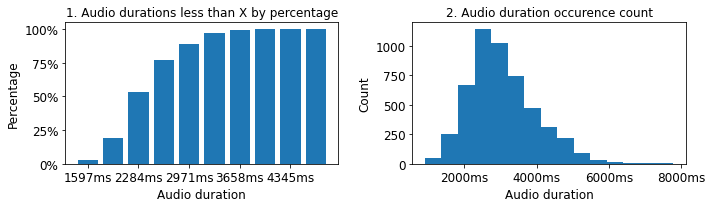

In [7]:
def display_histogram(errors, name="", unit='ms', plotting=False):
    errors = errors.copy()
    hist, bins = np.histogram(abs(errors))
    hist = np.round(hist / len(errors) * 100, 1)
    hist = np.cumsum(hist)

    print(f"[{name}] DIFF abs mean: {abs(errors).mean():.2f}{unit} ({errors.mean():.2f}) min:{abs(errors).min():.2f}{unit} max:{abs(errors).max():.2f}{unit}")
    rows = list(zip(hist, bins, bins[1:]))
    for R  in zip(rows[::2], rows[1::2]):
        s = ""
        for h, b, e in R:
            s += f"\t{h:.1f}%\t < {e:.0f}{unit}\t"
        print(s)

    f, axarr = plt.subplots(1, 2, figsize=(10, 3))
    axarr[0].bar(range(len(bins)-1), np.round(hist).astype(int))
    axarr[0].set_xticklabels([f"{x:.0f}{unit}" for x in bins], fontdict=None, minor=False)
    axarr[0].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))

    axarr[1].hist(errors, bins=15)
    axarr[1].xaxis.set_major_formatter(FormatStrFormatter(f'%d{unit}'))
    return [f, *axarr]

f, ax1, ax2 = display_histogram(audio_durations, plotting=True)
ax1.title.set_text("1. Audio durations less than X by percentage")
ax2.title.set_text("2. Audio duration occurence count")
ax1.set_xlabel('Audio duration', fontsize=12)
ax1.set_ylabel('Percentage', fontsize=12)
ax1.tick_params(axis='both', which='both', labelsize=12)
ax2.set_xlabel('Audio duration', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.tick_params(axis='both', which='both', labelsize=12)
f.tight_layout()


185242
[] DIFF abs mean: 36.75 (36.75) min:9.00 max:73.00
	2.1%	 < 15		8.3%	 < 22	
	24.8%	 < 28		47.6%	 < 35	
	67.5%	 < 41		80.5%	 < 47	
	88.3%	 < 54		96.2%	 < 60	
	99.4%	 < 67		99.9%	 < 73	


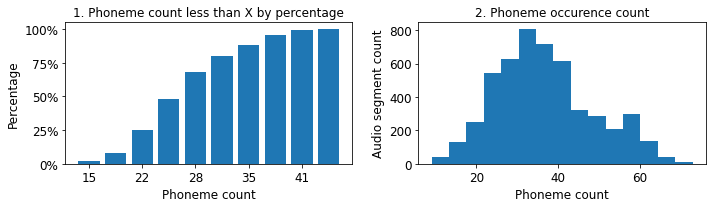

In [8]:
audio_phoneme_count = np.array(sum([[inp.border.shape[0] for inp in dataset] for dataset in all_datasets], []))
print(sum(audio_phoneme_count))
f, ax1, ax2 = display_histogram(audio_phoneme_count, plotting=True, unit='')

ax1.title.set_text("1. Phoneme count less than X by percentage")
ax2.title.set_text("2. Phoneme occurence count")
ax1.set_xlabel('Phoneme count', fontsize=12)
ax1.set_ylabel('Percentage', fontsize=12)
ax1.tick_params(axis='both', which='both', labelsize=12)
ax2.set_xlabel('Phoneme count', fontsize=12)
ax2.set_ylabel('Audio segment count', fontsize=12)
ax2.tick_params(axis='both', which='both', labelsize=12)
f.tight_layout()

In [12]:
inps = sum([[inp for inp in dataset] for dataset in all_datasets], [])
phoneme_map = defaultdict(list)
for inp in inps:
    phoneme_ids = np.argmax(inp.in_transcription.cpu(), axis=1).tolist()
    phoneme_durs = (inp.out_duration.cpu()* DURATION_SCALER).tolist()
    for pid, pdur in zip(phoneme_ids, phoneme_durs):
        phoneme_map[pid].append(pdur)



mean_phoneme_dur = sorted([[KNOWN_LABELS[pid], np.mean(val) ] for pid, val in phoneme_map.items()], key=lambda x: x[1])
# mean_phoneme_dur = (zip(*mean_phoneme_dur))
# plt.figure(figsize=(24, 6))
# plt.bar(*mean_phoneme_dur)
print(len(mean_phoneme_dur))
for row in zip(mean_phoneme_dur[::3], mean_phoneme_dur[1::3], mean_phoneme_dur[2::3]):
    for i, (p, c) in enumerate(row):
        print(i and "\t\t" or "", f"{p}\t{c:.0f}ms", end="", sep="")
    print()
for i, (p, c) in enumerate(mean_phoneme_dur[-2:]):
    print(i and "\t\t" or "", f"{p}\t{c:.0f}ms", end="", sep="")
print("\n.")

54
b	18ms		d	25ms		g	27ms
dx	29ms		nx	29ms		ax-h	34ms
dh	36ms		p	44ms		t	49ms
ax	50ms		k	52ms		ix	53ms
gcl	55ms		y	56ms		dcl	57ms
r	58ms		n	58ms		tcl	59ms
v	61ms		kcl	61ms		jh	62ms
w	63ms		ng	64ms		bcl	65ms
hh	65ms		m	66ms		l	68ms
hv	71ms		pcl	72ms		uh	77ms
axr	79ms		ih	80ms		zh	83ms
z	86ms		ch	87ms		th	91ms
ah	92ms		eh	95ms		iy	97ms
ux	99ms		f	103ms		uw	109ms
s	114ms		sh	119ms		er	123ms
ao	127ms		aa	127ms		ey	131ms
ow	132ms		ae	139ms		ay	159ms
aw	169ms		oy	175ms		pau	178ms
oy	175ms		pau	178ms
.


-0.057281494140625 0.081085205078125
-1877 2657
32768.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


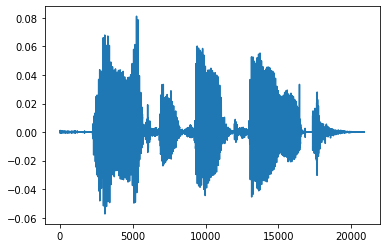

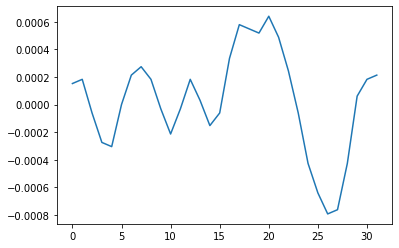

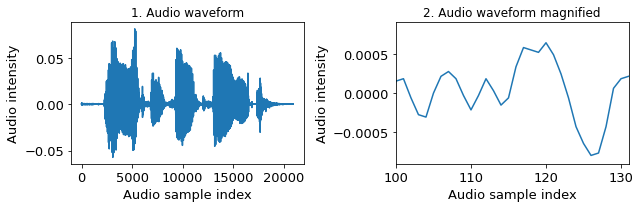

In [0]:
inp: Utterance = test_dataset[36]
audio_file = inp.label_file
audio = sf.read(audio_file)[0]
plt.figure()
plt.plot(audio, '-', );
plt.figure()
plt.plot(audio[100:132], '-', );

s, audio2 = wavfile.read(audio_file)
print(audio.min(), audio.max())
print(audio2.min(), audio2.max())
print((audio2[:3] / audio[:3]).mean())


fig = plt.figure(figsize=(9, 3), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(audio, '-', )
ax1.title.set_text("1. Audio waveform")
ax1.set_xlabel('Audio sample index', fontsize=13)
ax1.set_ylabel('Audio intensity', fontsize=13)
ax1.tick_params(axis='both', which='both', labelsize=13)

ax2.plot(audio, '-', )
ax2.title.set_text("2. Audio waveform magnified")
ax2.set_xlabel('Audio sample index', fontsize=13)
ax2.set_ylabel('Audio intensity', fontsize=13)
ax2.tick_params(axis='both', which='both', labelsize=13)
ax2.set_xlim([100, 131])
ax2.set_ylim([-0.0009, 0.0009])

fig.tight_layout()

tensor([ 14,  18,  22,  26,  29,  32,  35,  37,  42,  48,  51,  57,  61,  69,
         72,  74,  81,  86,  93,  98, 104, 108, 115], device='cuda:0')


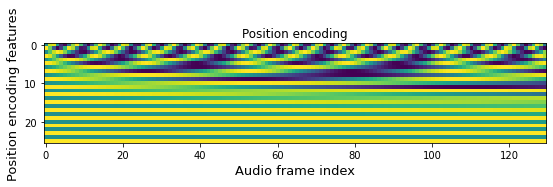

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 



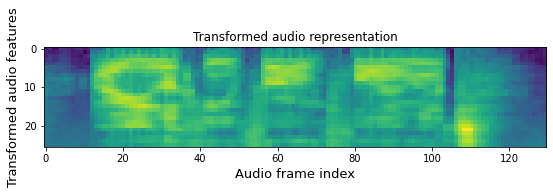

We can see the border at 57


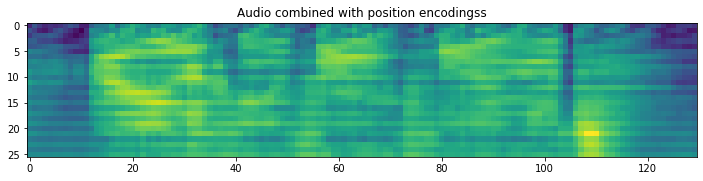

In [0]:
pos = PositionalEncoding(26, 0.0, scale=1)
pos_map = pos.pe.transpose(0, 1)[0]

inp: Utterance = test_dataset[36]

audio = inp.features
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
pos_feature = pos_map[:length,:]
print(actual_borders.long())

combined = pos_feature + audio.cpu() / 2

highlighted = torch.zeros(length, 8)
highlighted[actual_borders.long()] = 1

plt.figure(figsize=(9, 4))
plt.xlabel('Audio frame index', fontsize=13)
plt.ylabel('Position encoding features', fontsize=13)
showTensor(pos_feature, 'Position encoding', fig=False)
separation()

plt.figure(figsize=(9, 4))
plt.xlabel('Audio frame index', fontsize=13)
plt.ylabel('Transformed audio features', fontsize=13)
showTensor(audio.cpu(), 'Transformed audio representation', fig=False)
print("We can see the border at 57")


showTensor(combined, 'Audio combined with position encodingss')

['pau', 'aa', 'r', 'y', 'ix', 'l', 'uh', 'kcl', 'k', 'iy', 'n', 'f', 'r', 'ow', 'm', 'pcl', 'p', 'l', 'oy', 'm', 'ih', 'tcl', 't', 'pau'] 24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


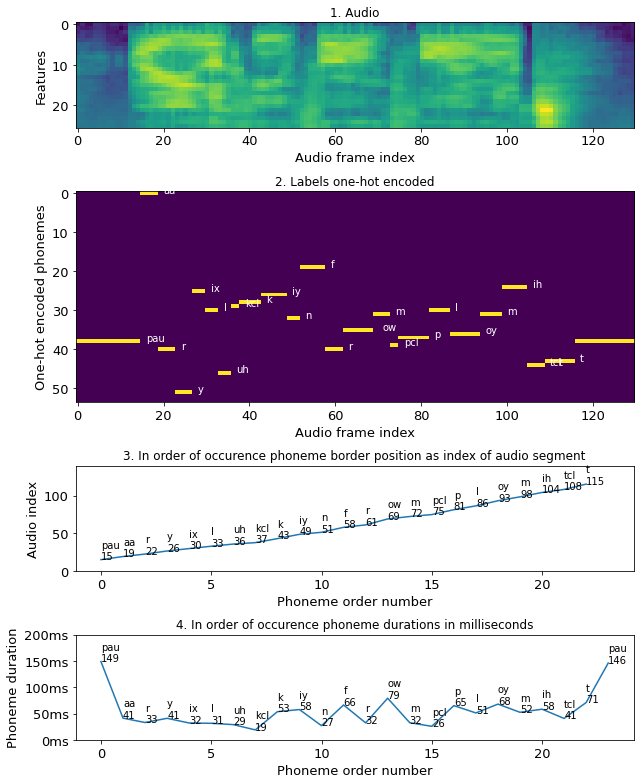

In [0]:
labels_ids = np.argmax(inp.in_transcription.cpu(), axis=1).tolist()
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = inp.border.long().cpu().tolist()
print(labels, len(labels))

def show_numbers(numbers, labels, title):
    plt.figure(figsize=(12, 3))
    plt.plot(numbers, '-', );
    for i,j in enumerate(numbers):
        plt.annotate(f"{labels[i]}\n{j:.0f}",xy=(i-1,j-1))
    plt.title(title)
    plt.show()

# showTensor(audio.cpu(), 'Audio')
# showTensor(label_vec.cpu(), 'Labels one-hot encoded', labels=zip(labels_pos, labels_ids, labels), figsize=(12, 6))
# show_numbers(inp.border.cpu().tolist(), labels, 'In order of occurence phoneme border position as index of audio segment');
# show_numbers((inp.out_duration * DURATION_SCALER).cpu().tolist(), labels, 'In order of occurence phoneme durations in milliseconds');

fig = plt.figure(figsize=(9, 11), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=4, height_ratios=[3, 6, 3, 3])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3], sharex=ax3)


ax1.imshow(audio.cpu().numpy().T, aspect='auto')
ax1.title.set_text("1. Audio")
ax1.set_xlabel('Audio frame index', fontsize=13)
ax1.set_ylabel('Features', fontsize=13)
ax1.tick_params(axis='both', which='both', labelsize=13)

ax2.imshow(label_vec.cpu().numpy().T, aspect='auto')
ax2.title.set_text("2. Labels one-hot encoded")
ax2.set_xlabel('Audio frame index', fontsize=13)
ax2.set_ylabel('One-hot encoded phonemes', fontsize=13)
ax2.tick_params(axis='both', which='both', labelsize=13)
for x, y, label in zip(labels_pos, labels_ids, labels):
    ax2.annotate(f"{label}",xy=(x + 2, y), color='white')
ax2.annotate(f"{label}",xy=(x - 3, y + 1), color='white')

numbers =inp.border.cpu().tolist()
ax3.plot(numbers, '-', );
for i,j in enumerate(numbers):
    ax3.annotate(f"{labels[i]}\n{j:.0f}",xy=(i,j))

ax3.title.set_text("3. In order of occurence phoneme border position as index of audio segment")
ax3.set_xlabel('Phoneme order number', fontsize=13)
ax3.set_ylabel('Audio index', fontsize=13)
ax3.tick_params(axis='both', which='both', labelsize=13)
ax3.set_ylim([0, 140])

numbers = (inp.out_duration * DURATION_SCALER).cpu().tolist()
ax4.plot(numbers, '-', );
for i,j in enumerate(numbers):
    ax4.annotate(f"{labels[i]}\n{j:.0f}",xy=(i,j))

ax4.title.set_text("4. In order of occurence phoneme durations in milliseconds")
ax4.set_xlabel('Phoneme order number', fontsize=13)
ax4.set_ylabel('Phoneme duration', fontsize=13)
ax4.tick_params(axis='both', which='both', labelsize=13)
ax4.yaxis.set_major_formatter(FormatStrFormatter('%dms'))
ax4.set_ylim([0, 200])
fig.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


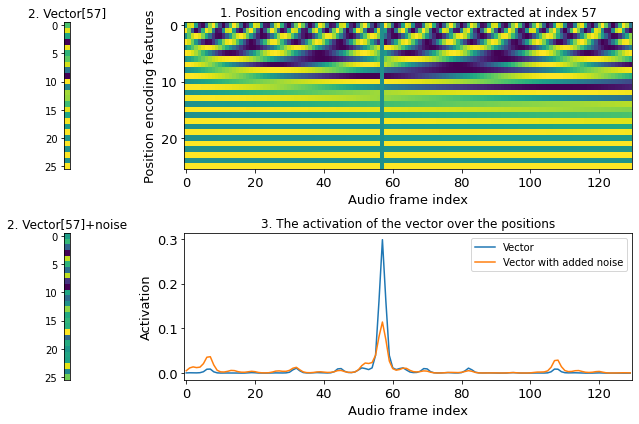

In [0]:
vec = pos_feature[57].clone()
pos_feature_high = pos_feature.clone()
pos_feature_high[57] = 0
# showTensor(pos_feature_high, 'Position encoding with border position')
# print("Highlighted section on the positon encoding matchin the temporal positon. Extracted as a vector to the left.")

vec_noised = (torch.rand_like(vec) * 1 + vec) / 2

# showTensor(vec.unsqueeze(0), 'Vector', figsize=(12, 3), hide_x=True)
# showTensor(vec_noised.unsqueeze(0), 'Vector\'', figsize=(12, 3), hide_x=True)

attn = F.softmax(torch.bmm(vec.unsqueeze(0).unsqueeze(0), pos_feature.unsqueeze(0).transpose(1, 2)).transpose(1, 2).squeeze(0), dim=0)
attn_noised = F.softmax(torch.bmm(vec_noised.unsqueeze(0).unsqueeze(0), pos_feature.unsqueeze(0).transpose(1, 2)).transpose(1, 2).squeeze(0), dim=0)


# fig = plt.figure(figsize=(12, 6)) 
# gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[5, 1], hspace=0.01) 

# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1], sharex=ax1)
# # plt.setp(ax1.get_xticklabels(), visible=False)

# # plt.setp([ax1, ax2], title='Test')
# # fig.suptitle('An overall title', size=20)


# # fig, a =  plt.subplots(nrows=2, figsize=, gridspec_kw={'hspace': 0., 'wspace': 0.}, sharex=True)
# ax1.imshow(pos_feature_high.numpy().T)
# ax1.title.set_text("Position encoding with a single vector extracted")
# ax2.plot(attn.numpy(), label='Vector')
# ax2.title.set_text("The activation of the vector over the positions")
# ax2.plot(attn_noised.numpy(), label='Vector with added noise')
# ax2.title.set_text("The activation of the vector over the positions")
# ax2.legend()


fig = plt.figure(figsize=(9, 6), constrained_layout=True,)
gs = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[1, 10], height_ratios=[5, 5])

ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])

ax3.title.set_text("2. Vector[57]")
ax3.imshow(vec.unsqueeze(0).cpu().numpy().T)
ax3.set_xticks([57])

vec_noised = (torch.rand_like(vec) + vec) / 2
ax4.title.set_text("2. Vector[57]+noise")
ax4.imshow(vec_noised.unsqueeze(0).cpu().numpy().T)
ax4.set_xticks([57])

ax1.imshow(pos_feature_high.numpy().T, aspect='auto')
ax1.title.set_text("1. Position encoding with a single vector extracted at index 57")
ax1.set_xlabel('Audio frame index', fontsize=13)
ax1.set_ylabel('Position encoding features', fontsize=13)
ax1.tick_params(axis='both', which='both', labelsize=13)

ax2.title.set_text("3. The activation of the vector over the positions")
ax2.plot(attn.numpy(), label='Vector')
ax2.plot(attn_noised.numpy(), label='Vector with added noise')
ax2.tick_params(axis='both', which='both', labelsize=13)
ax2.set_xlabel('Audio frame index', fontsize=13)
ax2.set_ylabel('Activation', fontsize=13)
ax2.legend()

fig.tight_layout()


In [0]:
durations = torch.cumsum(inp.out_duration, dim=0) * DURATION_SCALER / ms_per_step

target = pos_map[durations.long()]

showTensor(pos_feature[:100])

showTensor(target[:100])
showTensor(audio.cpu())

att = Attention(POS_DIM)
new_map, weights = att(target.unsqueeze(0), None, pos_feature.unsqueeze(0), None)
showTensor(weights.transpose(1, 2))
showTensor(label_vec.cpu())

## Models

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


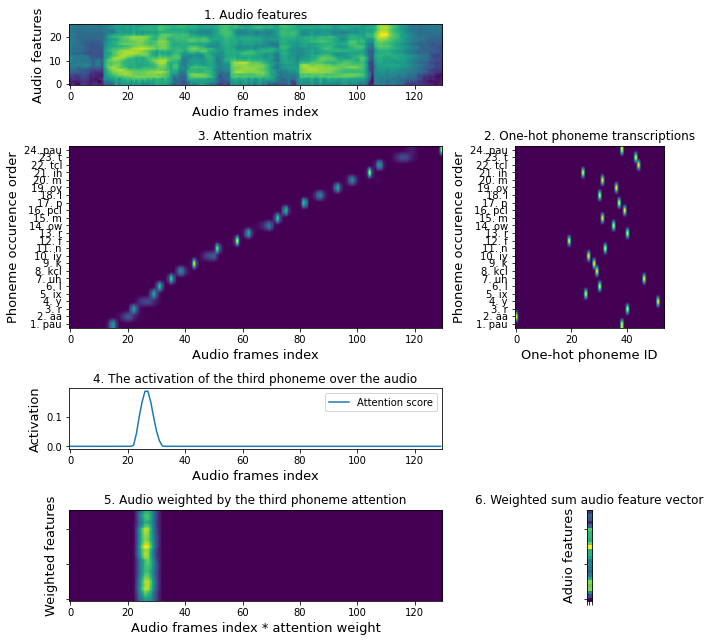

In [0]:
inp: Utterance = test_dataset[36]

audio = inp.features
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription

labels_ids = np.argmax(transcription.cpu(), axis=1).tolist()
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = actual_borders.cpu().tolist()
 
attention = position_model.with_weights(transcription.unsqueeze(0), None, audio.unsqueeze(0), None).detach().squeeze(0)

audio = audio.clone()
audio -= audio.min()
audio /= audio.max()

fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=4, height_ratios=[2, 6, 2, 3], width_ratios=[5, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharey=ax2)
ax5 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[3, 1], sharey=ax5)

ax1.imshow(audio.cpu().numpy().T, origin="lower", aspect='auto')
ax1.title.set_text("1. Audio features")
ax1.set_ylabel('Audio features', fontsize=13)
ax1.set_xlabel('Audio frames index', fontsize=13)

ax2.imshow(attention.cpu().numpy(), origin="lower", aspect='auto')
ax2.title.set_text("3. Attention matrix")
ax2.set_xlabel('Audio frames index', fontsize=13)
ax2.set_ylabel('Phoneme occurence order', fontsize=13)
# ax2.tick_params(axis='both', which='both', labelsize=12)
ax2.set_yticks(range(len(labels)))
ax2.set_yticklabels([f"{i+1}. {p}" for i, p in enumerate(labels)])

ax3.plot(attention[3].cpu().numpy(), label='Attention score')
ax3.title.set_text("4. The activation of the third phoneme over the audio")
ax3.set_xlabel('Audio frames index', fontsize=13)
ax3.set_ylabel('Activation', fontsize=13)
ax3.legend()

ax4.imshow(transcription.cpu().numpy(), origin="lower", aspect='auto')
ax4.title.set_text("2. One-hot phoneme transcriptions")
ax4.set_ylabel('Phoneme occurence order', fontsize=13)
ax4.set_xlabel('One-hot phoneme ID', fontsize=13)

ax5.imshow((attention[3] * audio.T).cpu().numpy(), origin="lower", aspect='auto')
ax5.title.set_text("5. Audio weighted by the third phoneme attention")
ax5.set_xlabel('Audio frames index * attention weight', fontsize=13)
ax5.set_ylabel('Weighted features', fontsize=13)

ax6.imshow((attention[3] * audio.T).sum(1).unsqueeze(0).cpu().numpy().T, origin="lower", aspect=0.65)
# ax6.title.set_text("6. Vector of weighted sum of the audio features")
ax6.title.set_text("6. Weighted sum audio feature vector")
ax6.set_xticklabels([], minor=False)
ax6.set_yticklabels([], minor=False)
ax6.set_ylabel('Aduio features', fontsize=13)

fig.tight_layout()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


[]

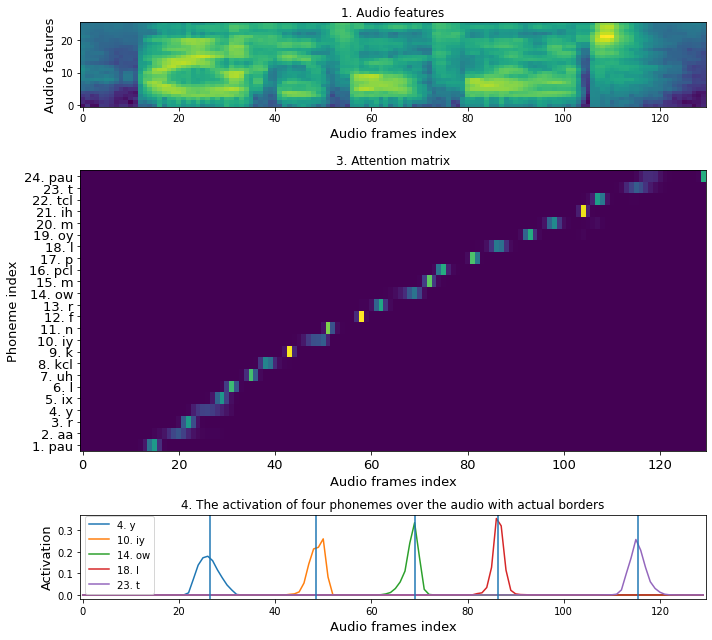

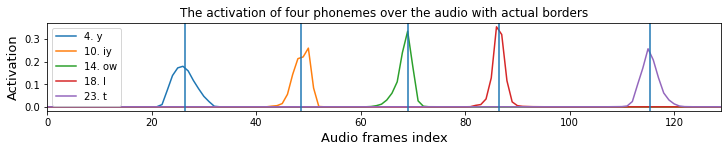

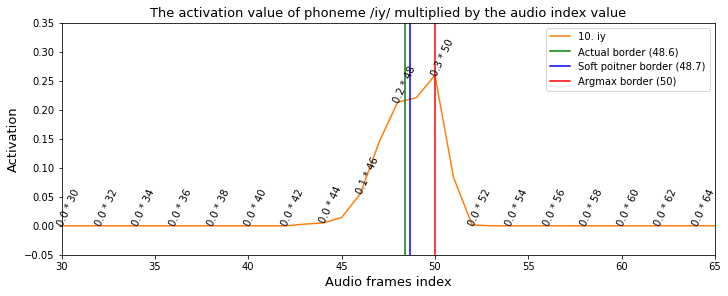

In [0]:
inp: Utterance = test_dataset[ 36  ]  # 36  1168 933

audio = inp.features.clone()
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription
t_count, t_features = transcription.shape


# audio = (audio + audio * torch.rand_like(audio) * 3) / 3
attention = position_model.with_weights(transcription.unsqueeze(0), None, audio.unsqueeze(0), None).detach().squeeze(0)

audio = audio.clone()
audio -= audio.min()
audio /= audio.max()

labels_ids = np.argmax(transcription.cpu(), axis=1).tolist()
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = actual_borders.cpu().tolist()

fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[3, 10, 3])#, width_ratios=[5, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
# ax4 = fig.add_subplot(gs[1, 1], sharey=ax2)

ax1.imshow(audio.cpu().numpy().T, origin="lower", aspect='auto')
ax1.title.set_text("1. Audio features")
ax1.set_ylabel('Audio features', fontsize=13)
ax1.set_xlabel('Audio frames index', fontsize=13)


ax2.imshow(attention.cpu().numpy(), origin="lower", aspect='auto')
ax2.title.set_text("3. Attention matrix")
ax2.set_xlabel('Audio frames index', fontsize=13)
ax2.set_ylabel('Phoneme index', fontsize=13)
ax2.tick_params(axis='both', which='both', labelsize=13)
ax2.set_yticks(list( range(t_count)))
ax2.set_yticklabels([f"{i+1}. {p}{(i%2 == 6) * ' - - '}" for i, p in enumerate(labels)])

ax3.plot(attention[3].cpu().numpy(), label=f'4. {labels[3]}')
ax3.plot(attention[10 - 1].cpu().numpy(), label=f'10. {labels[9]}')
ax3.plot(attention[14 - 1].cpu().numpy(), label=f'14. {labels[13]}')
ax3.plot(attention[18 - 1].cpu().numpy(), label=f'18. {labels[17]}')
ax3.plot(attention[23 - 1].cpu().numpy(), label=f'23. {labels[22]}')
for border in actual_borders[[3, 9, 13, 17, 22]]:
    ax3.axvline(x=border)

ax3.title.set_text("4. The activation of four phonemes over the audio with actual borders")
ax3.set_xlabel('Audio frames index', fontsize=13)
ax3.set_ylabel('Activation', fontsize=13)
ax3.legend()

# ax4.imshow(transcription.cpu().numpy())
# ax4.title.set_text("2. One-hot phoneme transcriptions transposed")
# ax4.set_ylabel('Phoneme index', fontsize=13)
# ax4.set_xlabel('One-hot phoneme ID', fontsize=13)
fig.tight_layout()


fig = plt.figure(figsize=(10, 2), constrained_layout=True)
plt.plot(attention[3].cpu().numpy(), label=f'4. {labels[3]}')
plt.plot(attention[10 - 1].cpu().numpy(), label=f'10. {labels[9]}')
plt.plot(attention[14 - 1].cpu().numpy(), label=f'14. {labels[13]}')
plt.plot(attention[18 - 1].cpu().numpy(), label=f'18. {labels[17]}')
plt.plot(attention[23 - 1].cpu().numpy(), label=f'23. {labels[22]}')
for border in actual_borders[[3, 9, 13, 17, 22]]:
    plt.axvline(x=border)
plt.xlim([0, length-1])
plt.title("The activation of four phonemes over the audio with actual borders")
plt.xlabel('Audio frames index', fontsize=13)
plt.ylabel('Activation', fontsize=13)
plt.legend()
plt.plot()


index = 9
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
att_local = attention[index].cpu().numpy()
predicted_border = (np.arange(length) * attention[index].cpu().numpy()).sum()

plt.plot(att_local, label=f'{index+1}. {labels[index]}', color=[ax2._get_patches_for_fill.get_next_color() for c in '123'][1])
# for border in actual_borders[[9]]:
#     plt.axvline(x=border, c='g')

s, e = 30, 65
for i, y in list(enumerate(att_local))[s:e:2]:
    plt.text(i-0.3, y, f'{y:.1f} * {i}', rotation=65)


plt.xlim([s, e])
plt.ylim([-0.05, 0.35])

plt.axvline(x=actual_borders[index]-0.15, c='g', label=f'Actual border ({actual_borders[index]:.1f})')
plt.axvline(x=predicted_border, c='b', label=f'Soft poitner border ({predicted_border:.1f})')
plt.axvline(x=50, c='r', label='Argmax border (50)')


plt.title("The activation value of phoneme /iy/ multiplied by the audio index value", fontsize=13)
plt.xlabel('Audio frames index', fontsize=13)
plt.ylabel('Activation', fontsize=13)
plt.legend()
# plt.text(21, 0.1, 'Actual attention', bbox={'facecolor': 'white', 'pad': 2})
plt.plot()




[]

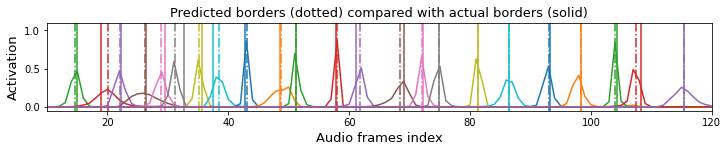

In [0]:
inp: Utterance = test_dataset[36]

audio = inp.features.clone()
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription
t_count, t_features = transcription.shape


# audio = (audio + audio * torch.rand_like(audio) * 3) / 3
attention = position_model.with_weights(transcription.unsqueeze(0), None, audio.unsqueeze(0), None).detach()
positions = position_model.weights_to_positions(attention).detach().squeeze(0).cpu().numpy()
attention = attention.squeeze(0)

audio = audio.clone()
audio -= audio.min()
audio /= audio.max()

labels_ids = np.argmax(transcription.cpu(), axis=1).tolist()[:-1]
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = actual_borders.cpu().tolist()
label_colors = [ax2._get_patches_for_fill.get_next_color() for c in labels_ids]

fig = plt.figure(figsize=(10, 2), constrained_layout=True)
for i in range(0, len(labels_ids), 1):
    c = label_colors[i]
    plt.plot(attention[i].cpu().numpy(), label=f'{i+1}. {labels[i]}', c=c)
    plt.axvline(x=labels_pos[i], c=c, linestyle='-')
    plt.axvline(x=positions[i], c=c, linestyle='-.')

plt.xlim([10, 120])
plt.ylim([-0.05, 1.1])

plt.title("Predicted borders (dotted) compared with actual borders (solid)", fontsize=13)
plt.xlabel('Audio frames index', fontsize=13)
plt.ylabel('Activation', fontsize=13)
# plt.legend()
plt.plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


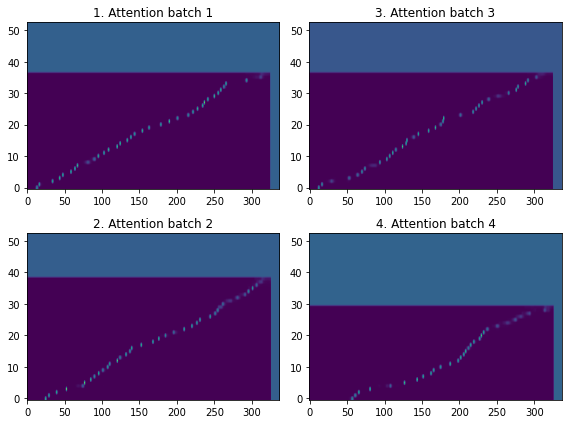

In [0]:
inp_batch: UtteranceBatch = next(b for b in train_dataset.batch(128))


position_model.eval()
attention = position_model.with_weights(
    inp_batch.in_transcription.padded, inp_batch.in_transcription.masks, 
    inp_batch.features.padded, 
    inp_batch.features.masks).detach().cpu().numpy()


batched_att = []
for i in range(64, 128, 8):
    ts, fs = (inp_batch.in_transcription.lengths[i], inp_batch.features.lengths[i])
    attention[i,ts:] = 0.25
    attention[i,:, fs:] = 0.25
    batched_att.append(attention[i])

    # plt.axvline(x=fs)
    # plt.axhline(y=ts)
    # plt.imshow(attention[i], origin="lower", aspect='auto')
    # plt.show()


fig = plt.figure(figsize=(8, 6), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2)#, height_ratios=[3, 10, 3])#, width_ratios=[5, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharey=ax2, sharex=ax3)

index = -1
ax1.imshow(batched_att[index], origin="lower", aspect='auto')
ax1.title.set_text("1. Attention batch 1")
index = -2
ax2.imshow(batched_att[index], origin="lower", aspect='auto')
ax2.title.set_text("2. Attention batch 2")
index = -3
ax3.imshow(batched_att[index], origin="lower", aspect='auto')
ax3.title.set_text("3. Attention batch 3")
index = -4
ax4.imshow(batched_att[index], origin="lower", aspect='auto')
ax4.title.set_text("4. Attention batch 4")

fig.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


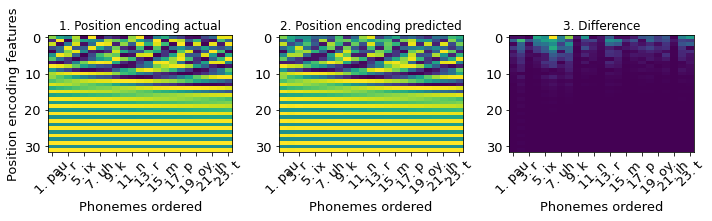

In [0]:
inp: Utterance = test_dataset[36]

audio = inp.features.clone()
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription
t_count, t_features = transcription.shape

pos_encoding_out = position_model.with_position(transcription.unsqueeze(0), None, audio.unsqueeze(0), None).detach().cpu().squeeze(0)


fig = plt.figure(figsize=(10, 3), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=1)

labels_ids = np.argmax(transcription.cpu(), axis=1).tolist()
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = actual_borders.cpu().tolist()

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)

ax1.imshow(inp.position.cpu().numpy().T, aspect='auto')
ax1.title.set_text("1. Position encoding actual")
ax1.set_xlabel('Phonemes ordered', fontsize=13)
ax1.set_ylabel('Position encoding features', fontsize=13)
ax1.tick_params(axis='both', which='both', labelsize=13)
ax1.set_xticks(list(range(t_count - 1))[::2])
ax1.set_xticklabels([f"{i+1}. {p}{(i%2 == 6) * ' - - '}" for i, p in enumerate(labels)][::2], rotation=45)

ax2.imshow(pos_encoding_out.cpu().numpy().T, aspect='auto')
ax2.title.set_text("2. Position encoding predicted")
ax2.set_xlabel('Phonemes ordered', fontsize=13)
ax2.tick_params(axis='both', which='both', labelsize=13)
ax2.set_xticks(list(range(t_count - 1))[::2])
ax2.set_xticklabels([f"{i+1}. {p}{(i%2 == 6) * ' - - '}" for i, p in enumerate(labels)][::2], rotation=45)

ax3.imshow((pos_encoding_out - inp.position).abs().cpu().numpy().T, aspect='auto')
ax3.title.set_text("3. Difference")
ax3.set_xlabel('Phonemes ordered', fontsize=13)
ax3.tick_params(axis='both', which='both', labelsize=13)
ax3.set_xticks(list(range(t_count - 1))[::2])
ax3.set_xticklabels([f"{i+1}. {p}{(i%2 == 6) * ' - - '}" for i, p in enumerate(labels)][::2], rotation=45)



fig.tight_layout()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


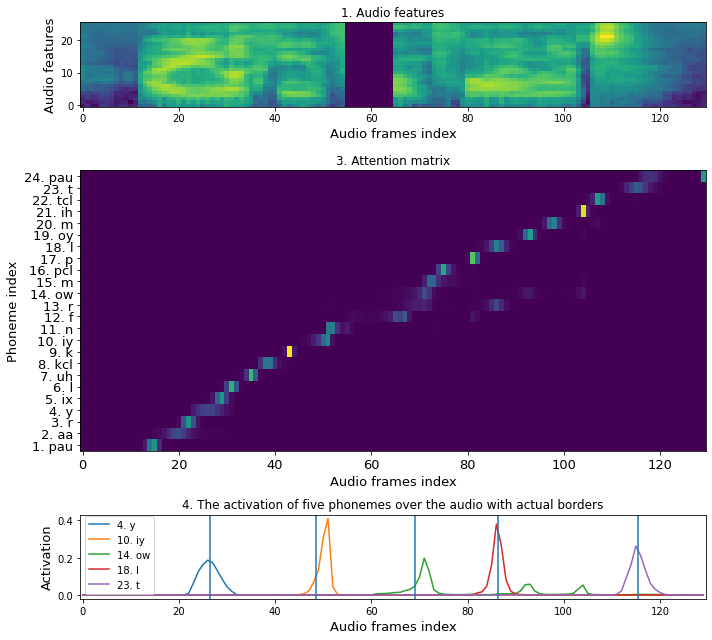

In [0]:
inp: Utterance = test_dataset[ 36  ]  # 36  1168 933

audio = inp.features.clone()
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription
t_count, t_features = transcription.shape

n = 15
audio[40 + n:50 + n] = audio.min()

# audio = (audio + audio * torch.rand_like(audio) * 3) / 3
attention = position_model.with_weights(transcription.unsqueeze(0), None, audio.unsqueeze(0), None).detach().squeeze(0)

audio = audio.clone()
audio -= audio.min()
audio /= audio.max()

labels_ids = np.argmax(transcription.cpu(), axis=1).tolist()
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = actual_borders.cpu().tolist()

fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[3, 10, 3])#, width_ratios=[5, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
# ax4 = fig.add_subplot(gs[1, 1], sharey=ax2)

ax1.imshow(audio.cpu().numpy().T, origin="lower", aspect='auto')
ax1.title.set_text("1. Audio features")
ax1.set_ylabel('Audio features', fontsize=13)
ax1.set_xlabel('Audio frames index', fontsize=13)


ax2.imshow(attention.cpu().numpy(), origin="lower", aspect='auto')
ax2.title.set_text("3. Attention matrix")
ax2.set_xlabel('Audio frames index', fontsize=13)
ax2.set_ylabel('Phoneme index', fontsize=13)
ax2.tick_params(axis='both', which='both', labelsize=13)
ax2.set_yticks(list( range(t_count)))
ax2.set_yticklabels([f"{i+1}. {p}{(i%2 == 6) * ' - - '}" for i, p in enumerate(labels)])

ax3.plot(attention[3].cpu().numpy(), label=f'4. {labels[3]}')
ax3.plot(attention[10 - 1].cpu().numpy(), label=f'10. {labels[9]}')
ax3.plot(attention[14 - 1].cpu().numpy(), label=f'14. {labels[13]}')
ax3.plot(attention[18 - 1].cpu().numpy(), label=f'18. {labels[17]}')
ax3.plot(attention[23 - 1].cpu().numpy(), label=f'23. {labels[22]}')
for border in actual_borders[[3, 9, 13, 17, 22]]:
    ax3.axvline(x=border)

ax3.title.set_text("4. The activation of five phonemes over the audio with actual borders")
ax3.set_xlabel('Audio frames index', fontsize=13)
ax3.set_ylabel('Activation', fontsize=13)
ax3.legend()

# ax4.imshow(transcription.cpu().numpy())
# ax4.title.set_text("2. One-hot phoneme transcriptions transposed")
# ax4.set_ylabel('Phoneme index', fontsize=13)
# ax4.set_xlabel('One-hot phoneme ID', fontsize=13)
fig.tight_layout()




(130,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


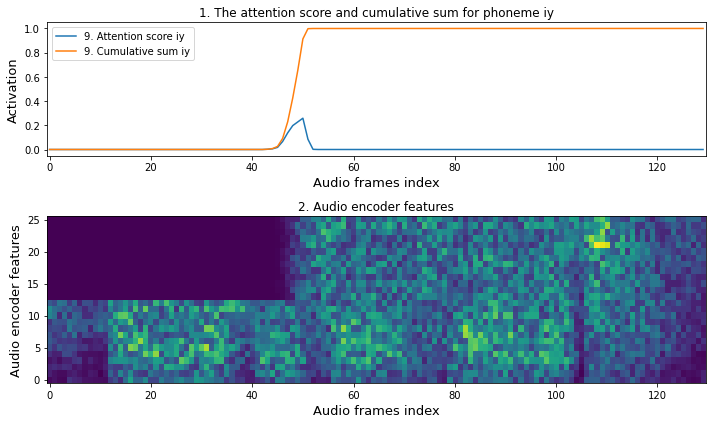

In [0]:
inp: Utterance = test_dataset[ 36  ]  # 36  1168 933

audio = inp.features.clone()
length = audio.shape[0]

label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription
t_count, t_features = transcription.shape

# audio = (audio + audio * torch.rand_like(audio) * 3) / 3
attention = position_model.with_weights(transcription.unsqueeze(0), None, audio.unsqueeze(0), None).detach().squeeze(0)

audio = audio.clone()
audio -= audio.min()
audio /= audio.max()

labels_ids = np.argmax(transcription.cpu(), axis=1).tolist()
labels = [KNOWN_LABELS[lab] for lab in labels_ids]
labels_pos = actual_borders.cpu().tolist()

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4, 5])#, width_ratios=[5, 2])

ax2 = fig.add_subplot(gs[1])
ax1 = fig.add_subplot(gs[0], sharex=ax2)


audio = (audio + audio * torch.rand_like(audio) * 3) / 3
a = audio.cpu().numpy()
a[:,13:] *= np.cumsum(vec).reshape(-1, 1)

ax2.imshow(a.T, origin="lower", aspect='auto')
ax2.title.set_text("2. Audio encoder features")
ax2.set_ylabel('Audio encoder features', fontsize=13)
ax2.set_xlabel('Audio frames index', fontsize=13)


vec = attention[9].cpu().numpy()
print(vec.shape)
ax1.plot(vec, label=f'9. Attention score {labels[9]}')
ax1.plot(np.cumsum(vec), label=f'9. Cumulative sum {labels[9]}')
ax1.title.set_text(f"1. The attention score and cumulative sum for phoneme {labels[9]}")
ax1.set_xlabel('Audio frames index', fontsize=13)
ax1.set_ylabel('Activation', fontsize=13)
ax1.legend()

fig.tight_layout()


## Duration

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


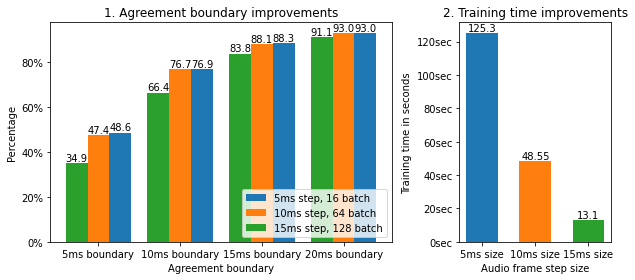

In [0]:
inp: Utterance = test_dataset[36]

audio = inp.features
length = audio.shape[0]
label_vec = inp.label_vec
actual_borders = inp.border
transcription = inp.in_transcription
 


        # f, axarr = plt.subplots(1, 2, figsize=(13, 3))
        # axarr[0].bar(range(len(bins)-1), np.round(hist).astype(int))
        # axarr[0].set_xticklabels([f"{x:.0f}{unit}" for x in bins], fontdict=None, minor=False)
        # axarr[0].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
        # axarr[1].hist(errors, bins=15)
        # axarr[1].xaxis.set_major_formatter(FormatStrFormatter(f'%d{unit}'))


# 10ms b-64  97
ms_10 = [
    [5, 47.4],
    [10, 76.7],
    [15, 88.1],
    [20, 93.0],
]

# 5ms  b 16  250.6
ms_5 = [
    [5, 48.6],
    [10, 76.9],
    [15, 88.3],
    [20, 93.0],
]

# 15ms b 128 = 26.2
ms_15 = [
    [5, 34.9],
    [10, 66.4],
    [15, 83.8],
    [20, 91.1],
]

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        



fig = plt.figure(figsize=(9, 4), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[18, 8])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


x = np.arange(4) * 1.5
width = 0.4  # the width of the bars
rects1 = ax1.bar(x + width * 1, [e[1] for e in ms_5], width, label='5ms step, 16 batch')
rects2 = ax1.bar(x + width * 0, [e[1] for e in ms_10], width, label='10ms step, 64 batch')
rects3 = ax1.bar(x - width * 1, [e[1] for e in ms_15], width, label='15ms step, 128 batch')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Agreement boundary')
ax1.set_title('1. Agreement boundary improvements')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{e[0]}ms boundary" for e in ms_15])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax1.legend(loc="lower right")
autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax1)

print()

rects1 = ax2.bar([5, 10, 15], [250.6 / 2, 97.1 / 2, 26.2 / 2], 3, color=[ax2._get_patches_for_fill.get_next_color() for c in '123'])
# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Training time in seconds')
ax2.set_xlabel('Audio frame step size')
ax2.set_title('2. Training time improvements')
ax2.set_xticks([5, 10, 15])
ax2.set_xticklabels([f"{e}ms size" for e in [5, 10, 15]])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%dsec'))
autolabel(rects1, ax2)

fig.tight_layout()

# Audio: prediction

In [0]:
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)

showTensor(target.detach())
showTensor(input.detach())

ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

In [0]:
class LightLSTM(nn.Module):
    def __init__(self, feature_dim, out_dim, dropout_prob=0.05, with_hidden=False):
        super().__init__()
        self.batchnorm = nn.BatchNorm1d(feature_dim)
        self.hidden_size = 128
        self.rnn = nn.LSTM(feature_dim, self.hidden_size, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout_prob)
        self.fc = nn.Linear(self.hidden_size * 2, out_dim)              
        self.with_hidden = with_hidden
        load(self, "/content/drive/My Drive/dataset/lstm-audio-final.pth") 

    def forward(self, features, masks, features_audio, masks_audio):
        x = features_audio
        x = x.permute(0, 2, 1).contiguous()
        x = self.batchnorm(x)
        x = x.permute(0, 2, 1).contiguous()
        x, (hidden, _) = self.rnn(x)
        x = self.fc(x)
        if self.with_hidden:
            hidden = hidden[:2,:,:] + hidden[2:,:,:]
            return x, hidden
        return x



audio_lstm = LightLSTM(INPUT_SIZE, KNOWN_LABELS_COUNT).to(device)
# load(audio_lstm, "/content/drive/My Drive/dataset/lstm-audio-final.pth") 
show_audio(audio_lstm, test_dataset, "test", plot_only=True)
"""
with generated transcript
[DETECTION+DTW]AVERAGE ERROR: 12.09% COUNT:1674
[DETECTION]AVERAGE ERROR: 27.55% COUNT:1674
[test] DIFF mean: 14.1ms min:0.00ms max:460.00ms
	43.9%	 < 10ms
	79.0%	 < 20ms
	91.6%	 < 30ms
	96.0%	 < 40ms
	97.9%	 < 50ms
""";

In [0]:
# work_dataset = train_dataset
# evaluation = [test_dataset.batch(64), train_eval_dataset.batch(64)]
# train(audio_lstm, 8, work_dataset.batch(32), evaluation, loss_function=LabelSmoothingLossAudio(KNOWN_LABELS_COUNT), train_function=audio_detection_trainer, lr_decay=0.98, lr=0.000161 * 0.131 * .1)
# show_audio(audio_lstm, test_dataset, "test")
# export_model(audio_lstm, "/content/drive/My Drive/dataset/lstm-audio-final.pth") 

# Audio detection

In [0]:
class MultyContextAttentionAudio(nn.Module):
    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        
        # self.encoder = Encoder(embedding_audio_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=None)
        self.encoder = LightLSTM(embedding_audio_size, vocab_size, with_hidden=True).to(device)
        # load(self.encoder, "/content/drive/My Drive/dataset/lstm-audio.pth") 

        self.encoder_transcription = Encoder(hidden_size, embedding_size, num_layers=2, dropout=dropout, time_scale=None)          
        self.decoder_transcription = Decoder(vocab_size, hidden_size, vocab_size, num_layers=2, dropout=dropout, time_scale=None)
        
        self.encoder_audio = Encoder(hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=1)
        self.decoder_audio = Decoder(vocab_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=1)

        self.out = nn.Linear(hidden_size * 2, vocab_size)
        self.out_single = nn.Linear(hidden_size, vocab_size)
        self.out_chain = nn.Linear(hidden_size, vocab_size)
        self.out_direct = nn.Linear(vocab_size, vocab_size)

        self.fix_hidden = nn.Linear(self.encoder.hidden_size, hidden_size)
        self.pos_encode = PositionalEncoding(vocab_size, dropout, scale=1)

        self.device = device

        self.mode = "chain"
        # load(self, "/content/drive/My Drive/dataset/multy-attention-audio-7.pth", ignore=['pos_encode'])  # without pos encode
        # load(self, "/content/drive/My Drive/dataset/multy-attention-audio-pos-6-half.pth", ignore=['pos_encode'])  # with pos encode
        load(self, "/content/drive/My Drive/dataset/CTC-audio-final.pth")
        
    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
        features_audio = features_audio * 32768.0
        batch_size, audio_len, *features = features_audio.shape
        batch_size, out_seq_len, *features = features_transcription.shape

        # if mask_transcription is None: mask_transcription = torch.ones(batch_size, out_seq_len).bool().to(device)
        # if mask_audio is None: mask_audio = torch.ones(batch_size, audio_len).bool().to(device)

        encoded_inputs, hidden = self.encoder(features_transcription, mask_transcription, features_audio, mask_audio)


        if self.mode == "direct":
            return encoded_inputs

        encoded_inputs = self.pos_encode(encoded_inputs)
        hidden = self.fix_hidden(hidden)
        encoder_transcription_outputs, hidden_transcription = self.encoder_transcription(features_transcription)

        if self.mode == "single":
            output_transcription, hidden_transcription = self.decoder_transcription(encoded_inputs, mask_audio, hidden_transcription + hidden, encoder_transcription_outputs, mask_transcription)
            # return self.out_single(output_transcription)
            return output_transcription

        encoder_audio_outputs, hidden_audio = self.encoder_audio(features_audio)

        if self.mode == "fast":
            output_transcription, hidden_transcription = self.decoder_transcription(encoded_inputs, hidden_transcription, encoder_transcription_outputs, mask_transcription)
            output_audio, hidden_audio = self.decoder_audio(encoded_inputs, hidden_audio, encoder_audio_outputs, mask_audio)
            output = torch.cat((output_transcription, output_audio), 2)
            return self.out(output) 

        if self.mode == "chain":
            output_transcription, hidden_transcription = self.decoder_transcription(
                # previous, mask_trans, hidden_state, encoder_outputs, mask_audio
                encoded_inputs, mask_audio, hidden_transcription + hidden, encoder_transcription_outputs, mask_transcription,
            )
            # encoded_inputs = encoded_inputs + self.out_single(output_transcription)
            # hidden_audio = hidden_audio + hidden_transcription + hidden
            output_audio, hidden_audio = self.decoder_audio(output_transcription, mask_audio , hidden_audio, encoder_audio_outputs, mask_audio)
            return self.out_chain(output_audio)      

        # # elif self.mode == "iter":
        # #     outputs = torch.zeros(batch_size, out_seq_len, self.vocab_size).to(self.device) # tensor to store decoder outputs
        # #     output = outputs[:,:1].clone()

        # #     for t in range(out_seq_len):
        # #         decoder_input = encoded_inputs[:,t:(t+1),:]

        # #         output_transcription, hidden_transcription = self.decoder_transcription(decoder_input, hidden_transcription, encoder_transcription_outputs, mask)
        # #         output_audio, hidden_audio = self.decoder_audio(decoder_input, hidden_audio, encoder_audio_outputs, masks_audio)

        # #         output = torch.cat((output_transcription, output_audio), 2)
        # #         output = self.out(output) 
        # #         outputs[:,t:(t+1),:] = output
        # else:
        #     raise Exception("wrong mode")
    
        return outputs

multy_context_audio_model = MultyContextAttentionAudio(KNOWN_LABELS_COUNT, INPUT_SIZE, 256, KNOWN_LABELS_COUNT, device).to(device);
# toy_dataset = DirectMaskDataset('train', limit=127)
# train_iter = BucketIterator(train_dataset, batch_size=64, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True)
# evaluate_audio("train", train_iter, multy_context_audio_model)
#  Evaluation on train - avg_loss: 0.158870 count:72 Total loss:11.438619658350945
show_audio(multy_context_audio_model, test_dataset, "test", plot_only=True)

In [0]:
def old_audio_model():
    class PositionalEncoding(nn.Module):
        def __init__(self, d_model, dropout=0.1, scale=1, max_len=2048):
            super(PositionalEncoding, self).__init__()
            self.scale = scale
            self.dropout = nn.Dropout(p=dropout)
            if not self.scale:
                return
            max_len = int(max_len * scale)

            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            
            m = nn.Upsample(scale_factor=(1. / scale, 1), mode='bilinear', align_corners=True)
            shape = pe.shape
            pe = pe.view(1, 1, *shape)
            pe = m(pe).view(-1, d_model) 

            pe = pe.unsqueeze(0).transpose(0, 1)
            self.register_buffer('pe', pe)

        def forward(self, x):
            if not self.scale:
                return x
            x = x.transpose(0, 1)
            x = x + self.pe[:x.size(0), :]
            x = x.transpose(0, 1)
            return x
            # return self.dropout(x)

    class Attention(nn.Module):
        r"""
        https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py
        Applies an attention mechanism on the output features from the decoder.
        .. math::
                \begin{array}{ll}
                x = context*output \\
                attn = exp(x_i) / sum_j exp(x_j) \\
                output = \tanh(w * (attn * context) + b * output)
                \end{array}
        Args:
            dim(int): The number of expected features in the output
        Inputs: output, context
            - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
            - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
        Outputs: output, attn
            - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
            - **attn** (batch, output_len, input_len): tensor containing attention weights.
        Attributes:
            linear_out (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
            mask (torch.Tensor, optional): applies a :math:`-inf` to the indices specified in the `Tensor`.
        Examples::
            >>> attention = seq2seq.models.Attention(256)
            >>> context = Variable(torch.randn(5, 3, 256))
            >>> output = Variable(torch.randn(5, 5, 256))
            >>> output, attn = attention(output, context)
        """
        def __init__(self, dim):
            super(Attention, self).__init__()
            self.linear_out = nn.Linear(dim * 2, dim)

        def forward(self, output, context, mask = None):
            # https://arxiv.org/abs/1706.03762
            # context & mask is what we attend to
            batch_size, hidden_size, input_size = output.size(0), output.size(2), context.size(1)
            # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
            # matrix by matrix product https://pytorch.org/docs/stable/torch.html#torch.bmm
            attn = torch.bmm(output, context.transpose(1, 2))
            # TODO: scale step missing?
            
            if mask is not None:
                attn.data.masked_fill_(~mask.unsqueeze(1), -float('inf'))

            attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)
            mix = torch.bmm(attn, context)  # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
            combined = torch.cat((mix, output), dim=2)  # concat -> (batch, out_len, 2*dim)

            # output -> (batch, out_len, dim)
            output = torch.tanh(self.linear_out(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)
            return output, attn


    class Decoder(nn.Module):
        def __init__(self, embedding_size, hidden_size, output_size, num_layers=2, dropout=0.1, time_scale=1):
            super().__init__()
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.num_layers = num_layers
            self.dropout = dropout
            self.gru = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)
            self.attn = Attention(hidden_size)

            self.pos_encode = PositionalEncoding(hidden_size, dropout, scale=time_scale)
            
        def forward(self, previous, hidden_state, encoder_outputs, mask):
            rnn_output, hidden_state = self.gru(previous, hidden_state)

            rnn_output = self.pos_encode(rnn_output)

            output, attn = self.attn(rnn_output, encoder_outputs, mask)
            output = self.out(output)
            return output, hidden_state

    class Encoder(nn.Module):
        def __init__(self, hidden_size, embedding_size, out_dim=None, num_layers=2, dropout=0.1, time_scale=1):
            super().__init__()
            self.hidden_size = hidden_size
            self.embedding_size = embedding_size
            self.num_layers = num_layers
            self.dropout = dropout
            self.batchnorm = nn.BatchNorm1d(embedding_size)
            # Embedding layer that will be shared with Decoder
            self.gru = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=True, batch_first=True)
            self.fc = nn.Linear(hidden_size * 2, out_dim or hidden_size)   

            self.pos_encode = PositionalEncoding(out_dim or hidden_size, dropout, scale=time_scale)
        
        def forward(self, x, *ignore):
            x = x.permute(0, 2, 1).contiguous()
            x = self.batchnorm(x)
            x = x.permute(0, 2, 1).contiguous()
            x, hidden = self.gru(x)
            # remove bi directional artifacts
            hidden = hidden[:2,:,:] + hidden[2:,:,:]
            x = self.fc(x)
            x = self.pos_encode(x)
            return x, hidden

    class LightLSTM(nn.Module):
        def __init__(self, feature_dim, out_dim, dropout_prob=0.05, with_hidden=False):
            super().__init__()
            self.batchnorm = nn.BatchNorm1d(feature_dim)
            self.hidden_size = 128
            self.rnn = nn.LSTM(feature_dim, self.hidden_size, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout_prob)
            self.fc = nn.Linear(self.hidden_size * 2, out_dim)              
            self.with_hidden = with_hidden

        def forward(self, features, masks, features_audio, masks_audio):
            x = features_audio
            x = x.permute(0, 2, 1).contiguous()
            x = self.batchnorm(x)
            x = x.permute(0, 2, 1).contiguous()
            x, (hidden, _) = self.rnn(x)
            x = self.fc(x)
            if self.with_hidden:
                hidden = hidden[:2,:,:] + hidden[2:,:,:]
                return x, hidden
            return x

    class MultyContextAttentionAudio(nn.Module):
        def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=0.1):
            super().__init__()
            self.vocab_size = vocab_size
            
            self.encoder = LightLSTM(embedding_audio_size, vocab_size, with_hidden=True).to(device)

            self.encoder_transcription = Encoder(hidden_size, embedding_size, num_layers=2, dropout=dropout, time_scale=None)          
            self.decoder_transcription = Decoder(vocab_size, hidden_size, vocab_size, num_layers=2, dropout=dropout, time_scale=None)
            
            self.encoder_audio = Encoder(hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=1)
            self.decoder_audio = Decoder(vocab_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=1)

            self.out = nn.Linear(hidden_size * 2, vocab_size)
            self.out_single = nn.Linear(hidden_size, vocab_size)
            self.out_chain = nn.Linear(hidden_size, vocab_size)
            self.out_direct = nn.Linear(vocab_size, vocab_size)

            self.fix_hidden = nn.Linear(self.encoder.hidden_size, hidden_size)
            self.pos_encode = PositionalEncoding(vocab_size, dropout, scale=1)

            self.device = device

            self.mode = "chain"
            # load(self, "/content/drive/My Drive/dataset/multy-attention-audio-pos-8.pth", ignore=['pos_encode'])  # with pos encode
            load(self, "/content/drive/My Drive/dataset/multy-attention-audio-pos-pure.pth")
            
        def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
            features_audio = features_audio * 32768.0
            batch_size, out_seq_len, *features = features_transcription.shape

            encoded_inputs, hidden = self.encoder(features_transcription, mask_transcription, features_audio, mask_audio)
            encoded_inputs = self.pos_encode(encoded_inputs)
            hidden = self.fix_hidden(hidden)

            if self.mode == "direct":
                return encoded_inputs

            encoder_transcription_outputs, hidden_transcription = self.encoder_transcription(features_transcription)
            if self.mode == "single":
                output_transcription, hidden_transcription = self.decoder_transcription(encoded_inputs, hidden_transcription + hidden, encoder_transcription_outputs, mask_transcription)
                # return self.out_single(output_transcription)
                return output_transcription

            encoder_audio_outputs, hidden_audio = self.encoder_audio(features_audio)

            if self.mode == "fast":
                output_transcription, hidden_transcription = self.decoder_transcription(encoded_inputs, hidden_transcription, encoder_transcription_outputs, mask_transcription)
                output_audio, hidden_audio = self.decoder_audio(encoded_inputs, hidden_audio, encoder_audio_outputs, mask_audio)
                output = torch.cat((output_transcription, output_audio), 2)
                return self.out(output) 

            if self.mode == "chain":
                output_transcription, hidden_transcription = self.decoder_transcription(encoded_inputs, hidden_transcription + hidden, encoder_transcription_outputs, mask_transcription)
                output_audio, hidden_audio = self.decoder_audio(output_transcription, hidden_audio, encoder_audio_outputs, mask_audio)
                return self.out_chain(output_audio)      

            return outputs

    multy_context_audio_model = MultyContextAttentionAudio(KNOWN_LABELS_COUNT, INPUT_SIZE, 256, KNOWN_LABELS_COUNT, device).to(device);
    return multy_context_audio_model
    
multy_context_audio_model = old_audio_model()

In [0]:
# duration_model = duration_combined_model
torch.cuda.empty_cache()
work_dataset = train_dataset
evaluation = [test_dataset.batch(64), train_eval_dataset.batch(64)]
from time import time
for i in range(1):
	start = time()
	train(multy_context_audio_model, 8, work_dataset.batch(16), evaluation, loss_function=LabelSmoothingLossAudio(KNOWN_LABELS_COUNT), train_function=audio_detection_trainer, lr_decay=0.98, lr=0.000161 * 0.131 * 3.6)
	print(time()-start)
 
"""
[DETECTION+DTW]AVERAGE ERROR: 8.67% COUNT:1338
[DETECTION]AVERAGE ERROR: 9.99% COUNT:1338
[test] DIFF abs mean: 7.25ms (0.14) min:0.02ms max:278.61ms
	79.5%	 < 10ms
	93.1%	 < 20ms
	96.8%	 < 30ms
	98.3%	 < 40ms
	99.0%	 < 50ms
	99.5%	 < 65ms
	99.8%	 < 85ms
	99.9%	 < 110ms
	100.0%	 < 140ms
""";

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 7.592760000000001e-05
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 0.2556019 count:21 Total loss:5.3676401
  Evaluation[] - avg_loss: 0.1762774 count:8 Total loss:1.4102188
Starting epoch 1, learning rate is 0.000076


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


  Evaluation[] - avg_loss: 0.2586626 count:21 Total loss:5.4319143
  Evaluation[] - avg_loss: 0.1807657 count:8 Total loss:1.4461259
Starting epoch 2, learning rate is 0.000073
  Evaluation[] - avg_loss: 0.2625913 count:21 Total loss:5.5144165
  Evaluation[] - avg_loss: 0.1863854 count:8 Total loss:1.4910831
Starting epoch 3, learning rate is 0.000071
  Evaluation[] - avg_loss: 0.2568572 count:21 Total loss:5.3940006
  Evaluation[] - avg_loss: 0.1793436 count:8 Total loss:1.4347488
Starting epoch 4, learning rate is 0.000070
  Evaluation[] - avg_loss: 0.2642256 count:21 Total loss:5.5487369
  Evaluation[] - avg_loss: 0.1835806 count:8 Total loss:1.4686452
Starting epoch 5, learning rate is 0.000069
  Evaluation[] - avg_loss: 0.2594389 count:21 Total loss:5.4482163
  Evaluation[] - avg_loss: 0.1816793 count:8 Total loss:1.4534344
Starting epoch 6, learning rate is 0.000067
  Evaluation[] - avg_loss: 0.2832431 count:21 Total loss:5.9481050
  Evaluation[] - avg_loss: 0.1953338 count:8 Tot


[test]
[standard]
danger: dtw_error 25.9% wrong idx:689
- warped_result: (517, 54)
- truth:(517, 54)
danger: dtw_error 29.8% wrong idx:69
- warped_result: (376, 54)
- truth:(376, 54)
danger: dtw_error 31.3% wrong idx:933
- warped_result: (643, 54)
- truth:(643, 54)
[(251.75, 371), (262.5, 195), (405.0, 665), (435.0, 497), (715.0, 933)]
cache_hits: 0
[DETECTION+DTW]AVERAGE ERROR: 8.37% COUNT:1344
[DETECTION]AVERAGE ERROR: 8.73% COUNT:1344
[test] DIFF abs mean: 7.50ms (-0.18) min:0.00ms max:758.12ms
	48.9%	 < 5ms		77.4%	 < 10ms	
	88.5%	 < 15ms		93.0%	 < 20ms	
	95.4%	 < 25ms		96.8%	 < 30ms	
	97.7%	 < 35ms		98.3%	 < 40ms	
	98.7%	 < 45ms		98.9%	 < 50ms	
	99.1%	 < 55ms		99.2%	 < 60ms	
	99.3%	 < 65ms		99.4%	 < 70ms	
	99.4%	 < 75ms		99.5%	 < 80ms	
	99.5%	 < 85ms		99.6%	 < 90ms	
	99.6%	 < 95ms		99.7%	 < 100ms	
	99.7%	 < 105ms		100.0%	 < 9999ms	
48.89% 77.36% 88.52% 93.05% 95.41% 96.81% 97.71% 98.27% 98.67% 98.89% 99.07% 99.20% 99.31% 99.39% 99.44% 99.48% 99.53% 99.58% 99.62% 99.65% 

[test]
[d

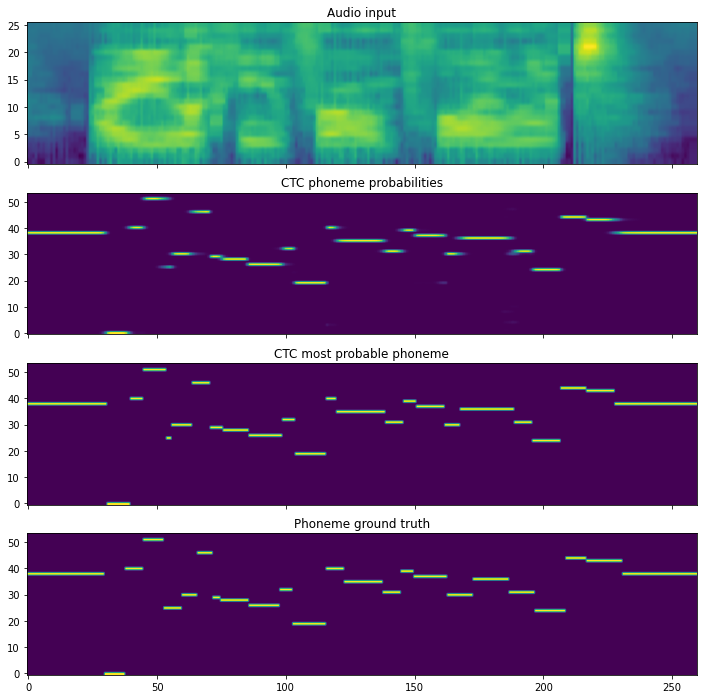

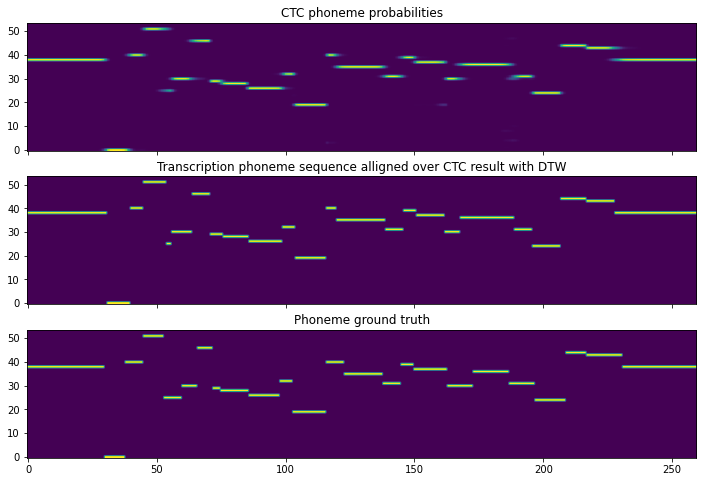

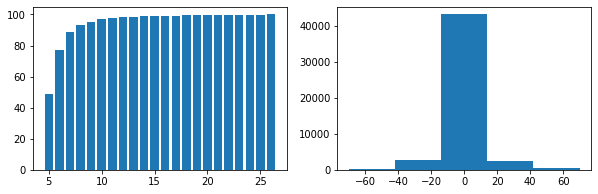

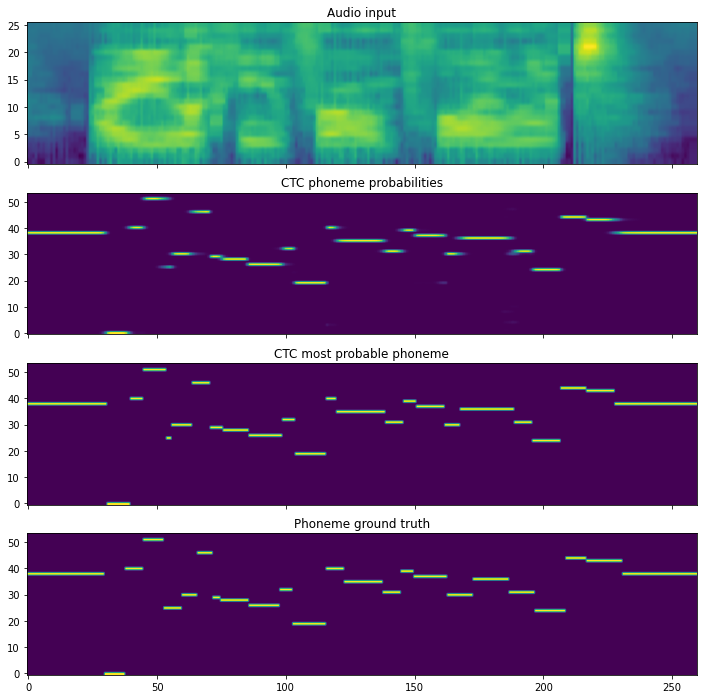

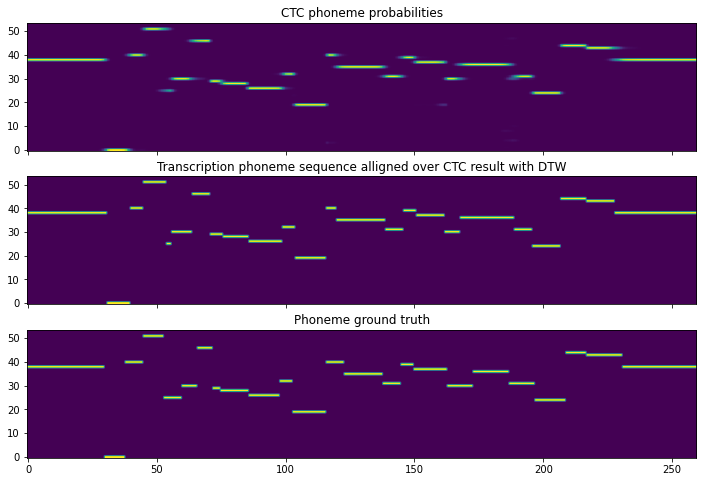

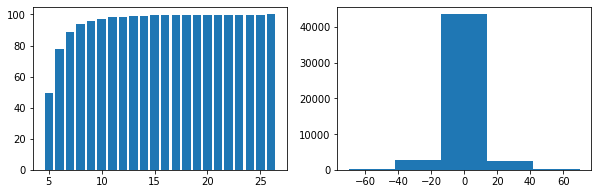

In [0]:
# for inp in train_dataset:
#     inp.features.detach()

# torch.cuda.empty_cache()

show_audio(multy_context_audio_model, test_dataset, "test")
show_audio(multy_context_audio_model, test_dataset, "test", duration_model=duration_combined_model)

# [DETECTION+DTW]AVERAGE ERROR: 8.37% COUNT:1344
# [DETECTION]AVERAGE ERROR: 8.73% COUNT:1344
# [test] DIFF abs mean: 7.50ms (-0.18) min:0.00ms max:758.12ms
# 	48.9%	 < 5ms		77.4%	 < 10ms	
# 	88.5%	 < 15ms		93.0%	 < 20ms	
# 	95.4%	 < 25ms		96.8%	 < 30ms	
# 	97.7%	 < 35ms		98.3%	 < 40ms	
# 	98.7%	 < 45ms		98.9%	 < 50ms	
# 	99.1%	 < 55ms		99.2%	 < 60ms	
# 	99.3%	 < 65ms		99.4%	 < 70ms	
# 	99.4%	 < 75ms		99.5%	 < 80ms	
# 	99.5%	 < 85ms		99.6%	 < 90ms	
# 	99.6%	 < 95ms		99.7%	 < 100ms	
# 	99.7%	 < 105ms		100.0%	 < 9999ms	
# 48.89% 77.36% 88.52% 93.05% 95.41% 96.81% 97.71% 98.27% 98.67% 98.89% 99.07% 99.20% 99.31% 99.39% 99.44% 99.48% 99.53% 99.58% 99.62% 99.65% 

# [test]
# [duration model]
# danger: dtw_error 31.4% wrong idx:69
# - warped_result: (376, 54)
# - truth:(376, 54)
# danger: dtw_error 31.3% wrong idx:933
# - warped_result: (643, 54)
# - truth:(643, 54)
# [(233.0, 944), (251.75, 371), (340.0, 497), (390.0, 665), (715.0, 933)]
# cache_hits: 0
# [DETECTION+DTW]AVERAGE ERROR: 8.12% COUNT:1344
# [DETECTION]AVERAGE ERROR: 8.73% COUNT:1344
# [test] DIFF abs mean: 6.98ms (0.07) min:0.00ms max:715.00ms
# 	49.3%	 < 5ms		77.9%	 < 10ms	
# 	89.0%	 < 15ms		93.6%	 < 20ms	
# 	95.9%	 < 25ms		97.3%	 < 30ms	
# 	98.1%	 < 35ms		98.7%	 < 40ms	
# 	99.0%	 < 45ms		99.2%	 < 50ms	
# 	99.4%	 < 55ms		99.5%	 < 60ms	
# 	99.6%	 < 65ms		99.7%	 < 70ms	
# 	99.7%	 < 75ms		99.8%	 < 80ms	
# 	99.8%	 < 85ms		99.8%	 < 90ms	
# 	99.8%	 < 95ms		99.9%	 < 100ms	
# 	99.9%	 < 105ms		100.0%	 < 9999ms	
# 49.30% 77.92% 89.03% 93.57% 95.87% 97.27% 98.11% 98.66% 99.03% 99.24% 99.41% 99.53% 99.60% 99.67% 99.71% 99.75% 99.78% 99.81% 99.83% 99.86% 

In [0]:
# export_model(multy_context_audio_model, "/content/drive/My Drive/dataset/CTC-audio-final-5ms.pth") 

# Frontier

torch.Size([351, 32]) tensor(3019.1074)


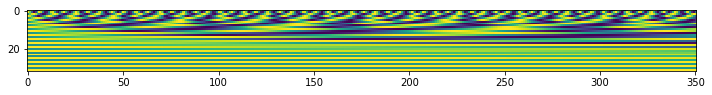

torch.Size([32, 32]) tensor(255.8792)


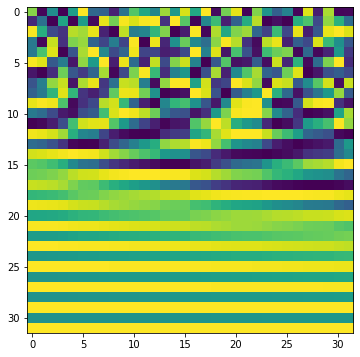

torch.Size([351, 26]) tensor(86502.3906)


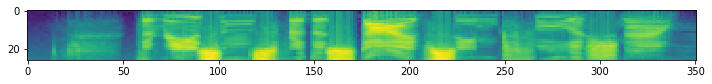

torch.Size([1, 351, 32]) tensor(32.)


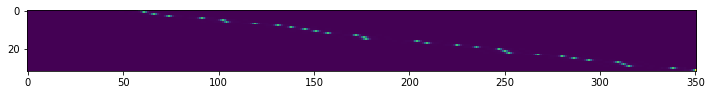

torch.Size([351, 54]) tensor(351.)


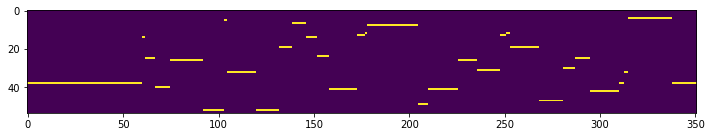

In [0]:
def showTensor(aTensor):
    print(aTensor.shape, aTensor.sum())
    if len(aTensor.shape) > 2:
        aTensor = aTensor[0]

    plt.figure(figsize=(12, 6))
    plt.imshow(aTensor.numpy().T)
    plt.show()

def duration_to_encoding(durations, pos_map):
    return pos_map[durations.long()]

ms_per_step = WIN_STEP * 1000

pos = PositionalEncoding(POS_DIM, 0.0, scale=1)
pos_map = pos.pe.transpose(0, 1)[0]
inp: Utterance = test_dataset[1]

audio = inp.features
label_vec = inp.label_vec
length = audio.shape[0]
durations = torch.cumsum(inp.out_duration, dim=0) * DURATION_SCALER / ms_per_step

pos_feature = pos_map[:length,:]
target = pos_map[durations.long()]
showTensor(pos_feature)
showTensor(target)
showTensor(audio.cpu())

att = Attention(POS_DIM)
new_map, weights = att(target.unsqueeze(0), pos_feature.unsqueeze(0))
showTensor(weights.transpose(1, 2))
showTensor(label_vec.cpu())

tensor([1.0000, 1.0500, 1.1025, 1.1576, 1.2155, 1.2763, 1.3401, 1.4071, 1.4775,
        1.5513, 1.6289, 1.7103, 1.7959, 1.8856, 1.9799, 2.0789, 2.1829, 2.2920,
        2.4066, 2.5270, 2.6533, 2.7860, 2.9253, 3.0715, 3.2251, 3.3864, 3.5557,
        3.7335, 3.9201, 4.1161, 4.3219, 4.5380])
Almost the same
torch.Size([32, 32]) tensor(872.1631)


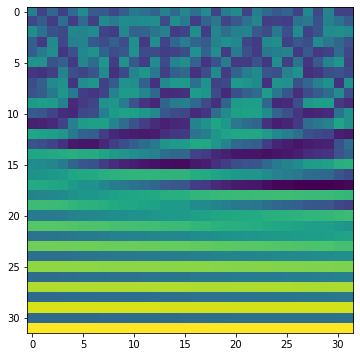

Mostly wrong
torch.Size([32, 32]) tensor(1128.3221)


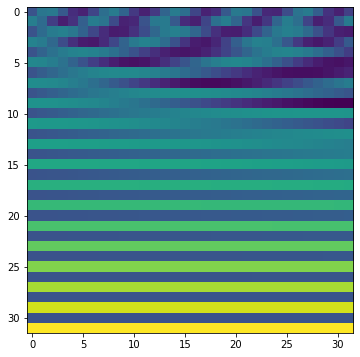

= = = = 
Almost the same
torch.Size([1, 32, 32]) tensor(25039.2422)


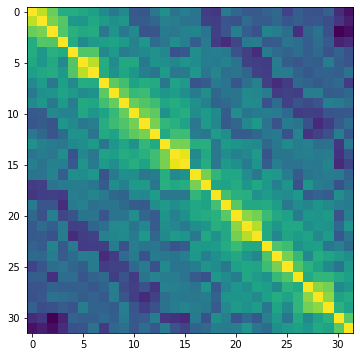

Mostly wrong
torch.Size([1, 32, 32]) tensor(21199.6094)


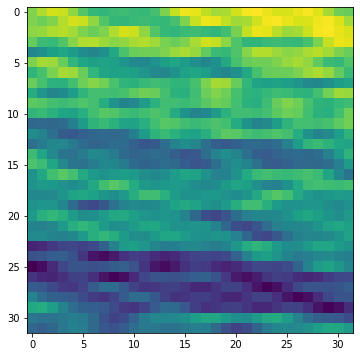

 - - - -- -- - -- 
DOT PRODUCT
torch.Size([1, 32]) tensor([[38.2177, 38.2188, 38.2166, 38.0741, 38.2102, 38.1396, 38.1483, 38.1758,
         38.0120, 38.0346, 38.0081, 38.0730, 38.1837, 38.0695, 38.1046, 38.1052,
         37.9595, 38.0448, 38.0171, 37.9391, 37.9588, 37.9350, 37.9259, 37.9983,
         38.1326, 38.1234, 37.9171, 37.9862, 38.0019, 38.0318, 38.0399, 37.9821]])
torch.Size([1, 32]) tensor([[25.6374, 25.1130, 26.8153, 24.2612, 21.2099, 21.8412, 23.0611, 25.2582,
         23.6135, 19.5029, 23.3923, 22.4962, 22.8810, 17.8954, 16.9465, 16.9125,
         21.6483, 19.7566, 20.9098, 20.9921, 17.9604, 15.4246, 15.8576, 22.3815,
         20.6702, 15.7122, 14.0266, 16.2801, 13.9693, 11.9293, 16.4425, 20.9814]])

SIMILARITY
tensor([[0.9117, 0.9117, 0.9119, 0.9102, 0.9122, 0.9112, 0.9114, 0.9121, 0.9102,
         0.9108, 0.9106, 0.9114, 0.9127, 0.9112, 0.9116, 0.9116, 0.9101, 0.9112,
         0.9111, 0.9106, 0.9110, 0.9107, 0.9107, 0.9116, 0.9130, 0.9129, 0.9101,
         0.9111, 0.911

In [0]:
w = torch.FloatTensor([min(1.05 ** i, 10) for i in range(POS_DIM)])
print(w)
values, indices = weights.max(2)
target_similar = pos_map[indices].squeeze(0)  * w
print("Almost the same")
showTensor(target_similar)

print("Mostly wrong")
target_random = pos_map[0:POS_DIM]  * w
showTensor(target_random)

print("= = = = ")

print("Almost the same")
attn = torch.bmm(target_similar.unsqueeze(0), target.unsqueeze(0).transpose(1, 2))
showTensor(attn)

print("Mostly wrong")
attn = torch.bmm(target_random.unsqueeze(0), target.unsqueeze(0).transpose(1, 2))
showTensor(attn)

print(" - - - -- -- - -- ")
print("DOT PRODUCT")
dot = (target_similar.unsqueeze(0) * target.unsqueeze(0)).sum(2)
print(dot.shape, dot)
dot = ((target_random.unsqueeze(0) * target.unsqueeze(0)).sum(2))
print(dot.shape, dot)

cos = nn.CosineSimilarity(dim=2, eps=1e-6)
print("\nSIMILARITY")
print(cos(target_similar.unsqueeze(0), target.unsqueeze(0)))
print(cos(target_random.unsqueeze(0), target.unsqueeze(0)))

def d(pred, target):
    return -((pred * target).pow(2)).mean()

print(d(target_similar.unsqueeze(0), target.unsqueeze(0)), d(target_random.unsqueeze(0), target.unsqueeze(0)))

torch.Size([1, 32, 54]) tensor(38.2000)


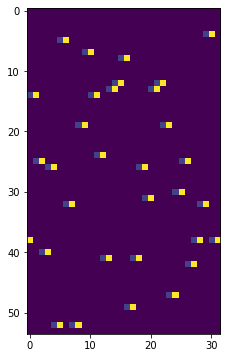

torch.Size([32, 54]) tensor(38.2000)


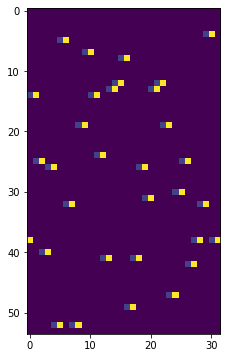

In [0]:
inp: Utterance = test_dataset[1]
in_transcription = inp.in_transcription.unsqueeze(0)
in_transcription[:,:-1] += in_transcription[:,1:] * 0.2
showTensor(in_transcription.cpu())
showTensor(inp.in_transcription.cpu())

# Pos old

tensor(-1.) tensor(1.) torch.Size([2048, 32]) POS MAP
3196 DS size


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instea

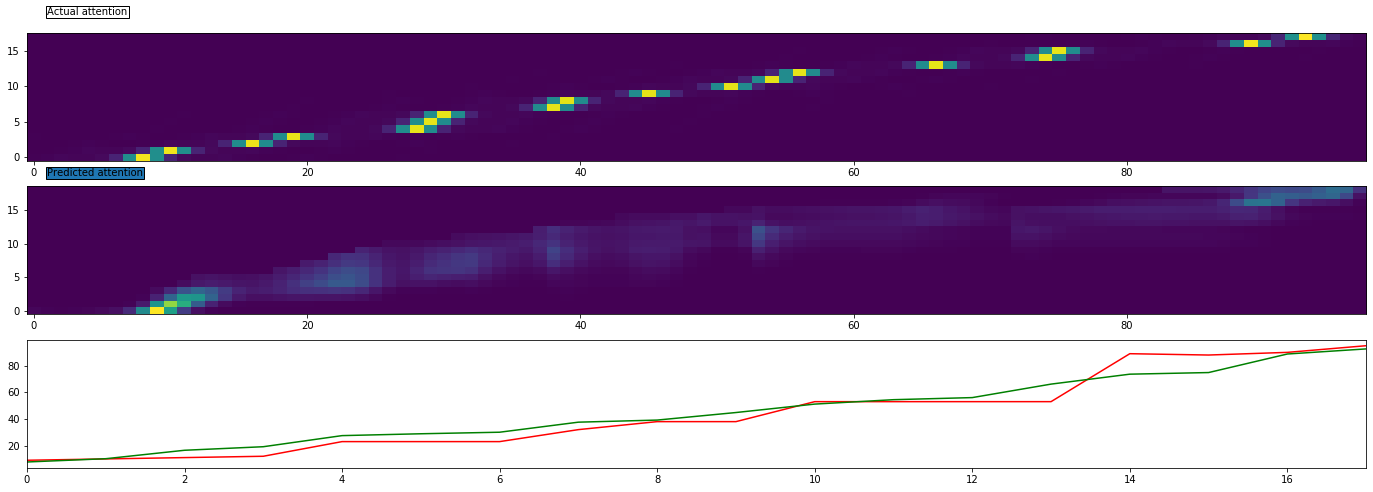

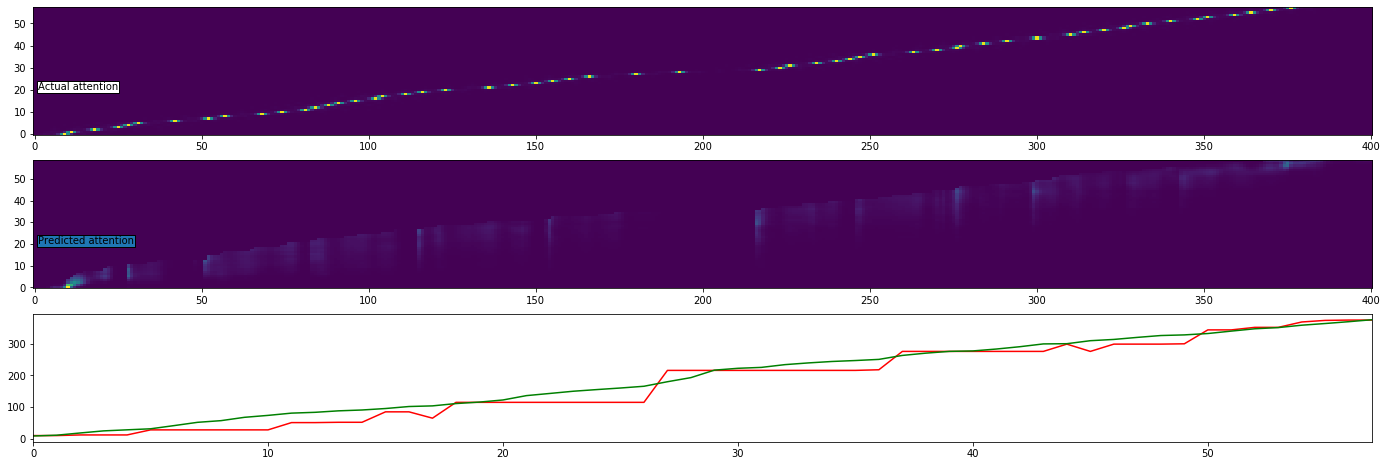

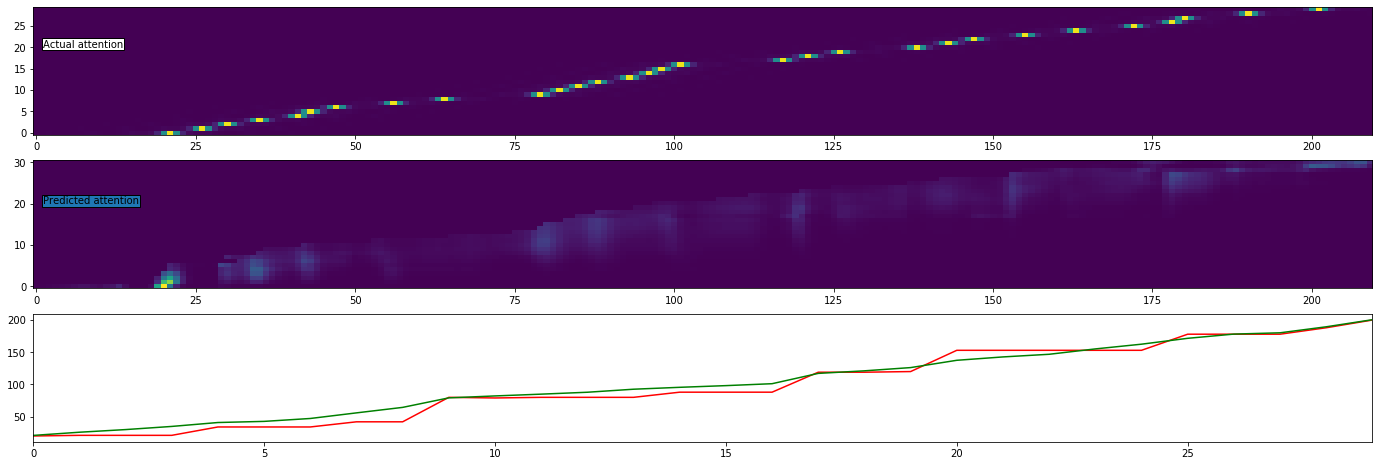

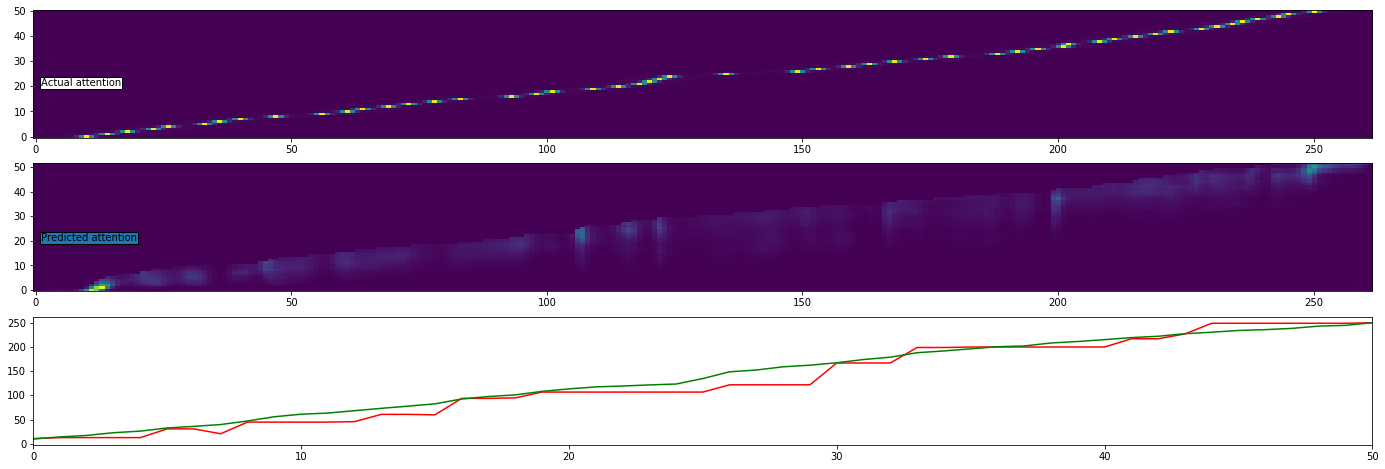

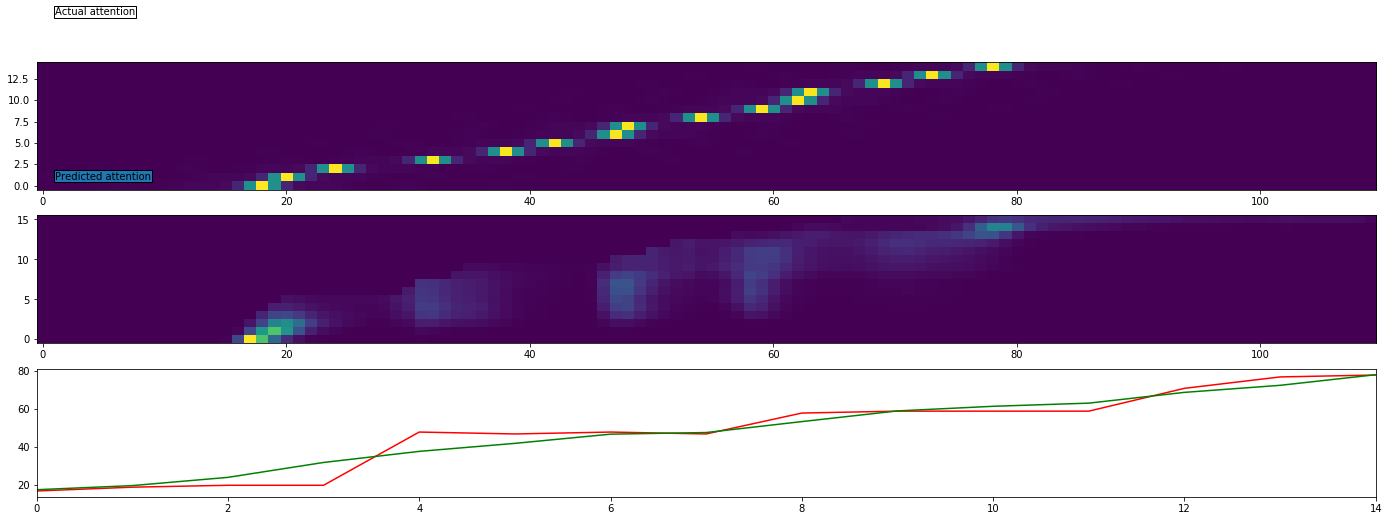

In [0]:
def adjust(weights_predicted, position, debug=False):
    weights = weights_predicted.clone().cpu()[0,:-1]
    
    position =  torch.round(position).int()
    _scores = sum(weights[i, pos] for i, pos in enumerate(position))

    if debug:
        print(_scores.sum(), "->")

    m = len(position) - 1

    prev = 0
    switch = 0
    copy = position.clone()

    for i, pos in enumerate(position):
        next_pos = max(position[min(i+1, m)], prev)
        if pos < prev:
            pos = (prev + next_pos) /  2
            switch += 1

            current, pos = 0, pos
            for p in range(prev + 1, next_pos):
                value = weights[i, p]
                if value >= current:
                    pos = p

        copy[i] = pos
        prev = position[i]

    position = copy
    
    if debug:
        print("->", sum(weights[i, pos] for i, pos in enumerate(position)))

    return position, switch

def show_position_shake(model, dataset, sample_size=2000):
    model.eval()
    pos_map = pos_prep.pe
    c = torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1
    print("dataset len", len(dataset))
    
    diffs = []
    att = Attention(POS_DIM)

    for idx in sample(range(len(dataset)), min(len(dataset), sample_size)):
        inp: Utterance = dataset[idx]

        audio = inp.features
        transcription = inp.in_transcription
        border = inp.border

        length = audio.shape[0] + 0
        pos_feature = pos_map[:length,:]

        weights_predicted = model.forward(transcription.unsqueeze(0), None, audio.unsqueeze(0), None)
        borders_predicted = model.weights_to_positions(weights_predicted)[0]
        borders_predicted, switch = adjust(weights_predicted, borders_predicted)

        b = borders_predicted.detach().cpu().numpy() * ms_per_step
        diff = (border.detach().cpu().numpy() * ms_per_step - b)

        if np.abs(diff).max() > 750:
            print(f"[id:{idx:3d}]  [{diff.min():5.0f} {diff.max():5.0f}]  {length:4d} {switch}")

        diffs.append(diff)

    diff = np.concatenate(diffs)
    display_diff(diff, "position", plotting=True)


def draw_attention_things(model, dataset):
    sm = nn.Softmax(dim=2)
    pos_map = pos_prep.pe

    print(pos_map.min(), pos_map.max(), pos_map.shape, "POS MAP")
    print(len(dataset), "DS size")
    model.eval()

    for i in sample(range(len(dataset)), 5):
        inp: Utterance = dataset[i]

        audio = inp.features
        transcription = inp.in_transcription
        target = inp.position
        label_vec = inp.label_vec
        att = Attention(POS_DIM).to(device)

        length = audio.shape[0]
        pos_feature = pos_map[:length,:]
        
        weights_predicted = model.forward(transcription.unsqueeze(0), None, audio.unsqueeze(0), None)
        batch_size, audio_size, input_size = weights_predicted.shape
        
        borders_predicted = model.weights_to_positions(weights_predicted.clone(), argmax=True)[0]
        A, B = inp.border.detach().cpu().numpy(), borders_predicted.detach().cpu().numpy()
        
        f, axarr = plt.subplots(3, figsize=(24, 8))
        new_map, weights = att(target.cuda().unsqueeze(0), pos_feature.cuda().unsqueeze(0))
        axarr[0].imshow(weights.transpose(1, 2)[0].detach().cpu().numpy().T, origin="lower", aspect='auto')
        axarr[0].text(1, 20, 'Actual attention', bbox={'facecolor': 'white', 'pad': 1})
        axarr[1].imshow(weights_predicted[0].detach().cpu().numpy(), origin="lower", aspect='auto')
        axarr[1].text(1, 20, 'Predicted attention', bbox={'pad': 1})
        axarr[2].plot(B, 'r')
        axarr[2].plot(A, 'g')
        axarr[2].set_xlim(left=0, right=len(A)-1)

draw_attention_things(position_model.with_weights, train_dataset)
# show_position_shake(position_model.with_weights, test_dataset, sample_size=1400)

torch.Size([40, 54])
torch.Size([253, 32]) tensor(2397.6287)


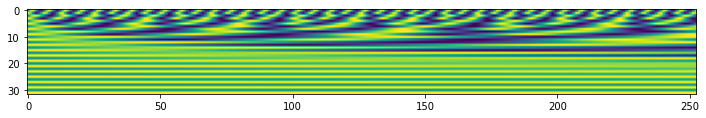

 = = = = 
PRECALC target:
torch.Size([39, 32]) tensor(374.1137)


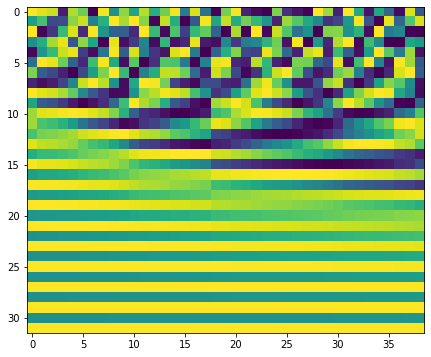

NameError: ignored

In [0]:
def showTensor(aTensor):
    print(aTensor.shape, aTensor.sum())
    if len(aTensor.shape) > 2:
        aTensor = aTensor[0]

    plt.figure(figsize=(12, 6))
    plt.imshow(aTensor.numpy().T)
    plt.show()

inp: Utterance = toy_dataset[4]

audio = inp.features
transcription = inp.in_transcription
print(transcription.shape)
target = inp.position
label_vec = inp.label_vec

length = audio.shape[0]
pos_map = pos_prep.pe
pos_feature = pos_map[:length,:]

# print(" = = = = = = = = =", "visual:", sep='\n')
# showTensor(pos_feature)
# showTensor(audio.cpu())
# showTensor(label_vec.cpu())

showTensor(pos_feature)

print(" = = = = ", "PRECALC target:", sep='\n')
showTensor(target)

position_model = PositionModelTest(KNOWN_LABELS_COUNT, INPUT_SIZE, 256, POS_DIM, device).to(device)

print(" = = = = ", "PREDICTED:", sep='\n')
res = position_model.forward(transcription.unsqueeze(0), None, audio.unsqueeze(0), None)[0]
showTensor(res.detach().cpu())

print(" = = = = ", "att:", sep='\n')


att = Attention(POS_DIM)

print(" = = = = ", "ACTUAL ATT:", sep='\n')
new_map, weights = att(target.unsqueeze(0), pos_feature.unsqueeze(0))
showTensor(weights.transpose(1, 2))

print(" = = = = ", "PREDICTED ATT:", sep='\n')
new_map, weights = att(res.cpu().unsqueeze(0), pos_feature.unsqueeze(0))
showTensor(weights.detach().cpu().transpose(1, 2))

w = weights.detach().cpu().transpose(1, 2)
c = torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1
c = c[:length]
showTensor(w)
showTensor(c)

showTensor(c * w)
borders_predicted = weights.max(2)[1][0]

x, y, z = (c * w).sum(1), borders_predicted, inp.border.detach().cpu()
print(x, (x-z).abs().sum())
print(y, (y-z).abs().sum())
print(z)

# asd

In [0]:
from dtw import dtw, accelerated_dtw as adtw
from fastdtw import fastdtw, dtw as slowdtw
from dtaidistance import dtw as dtaidtw
from dtaidistance.dtw_ndim import warping_paths
from collections import defaultdict

(367, 54)
(395, 54) torch.Size([395, 26]) (395, 54)
[(395, 54), (395, 54)]
(395, 54) (395, 54) (395, 54) wrongs
9.113924050632912 9.753125
32.91139240506329 35.61875
0.0 2.40625


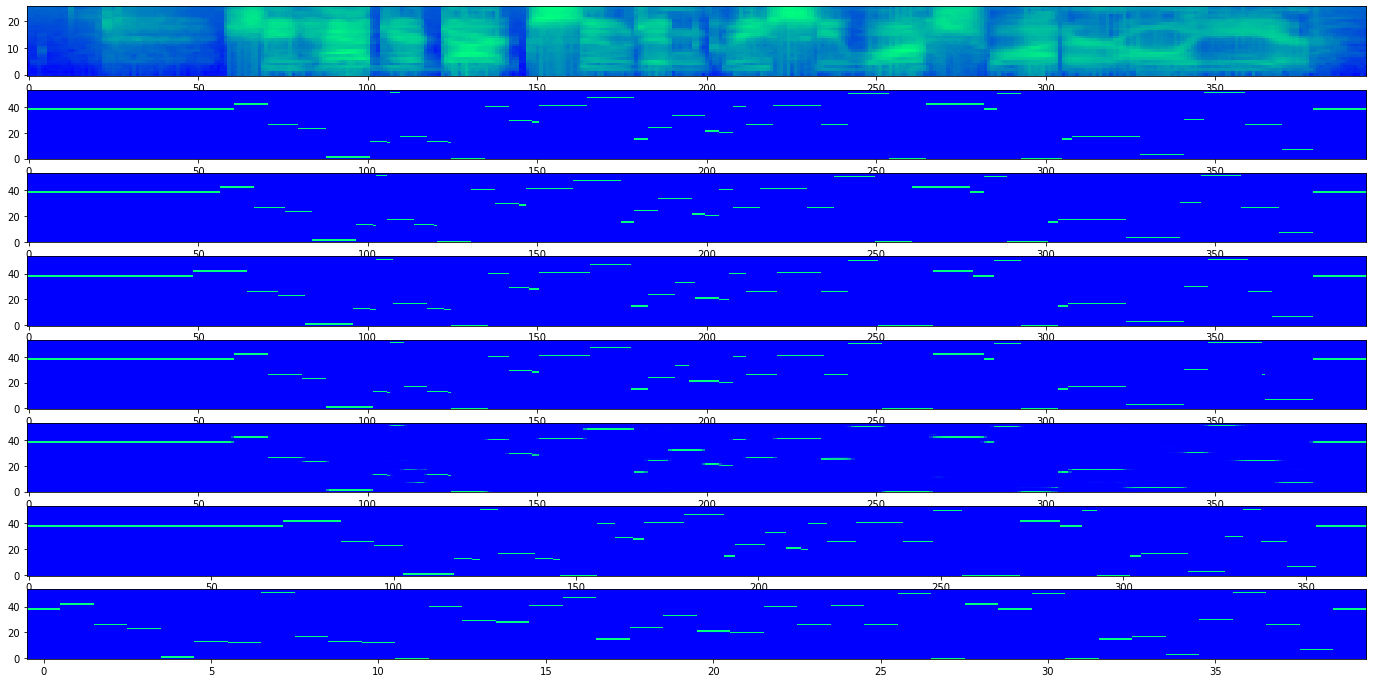

In [0]:
def generate_position_encoding(transcriptions: np.ndarray, durations: np.ndarray) -> np.ndarray:
    """Durations be scaled"""
    # durations *= DURATION_SCALER
    # return transcriptions
    ms_per_step = WIN_STEP * 1000
    stack = []
    for feature, duration in zip(transcriptions, durations):
        # duration *= 0.5
        steps = max((duration / ms_per_step).round().item(), 1)
        for i in range(int(steps)):
            stack.append(feature)

    transcription_with_duration = np.vstack(stack)
    return transcription_with_duration

def dur_trans(duration_model, trans, audio):
    res_batch = duration_model.forward(trans.unsqueeze(0), None, audio.unsqueeze(0), None)
    prediction = (res_batch).squeeze(0).detach().cpu().numpy() * DURATION_SCALER
    t = generate_position_encoding(trans.detach().cpu().numpy(), prediction)
    return t


### show one
i = 0
inp = test_dataset[i].features
transcription_truth = test_dataset.out_vec[i].cpu().numpy()
transcription = test_dataset.in_transcription[i]
out_map = test_dataset.out_map[i]
labels_cls = test_dataset.out_int[i].cpu().detach().numpy()

_res = model.forward(transcription.unsqueeze(0), None, inp.unsqueeze(0), None)
_res = F.softmax(_res, dim=2)

result = _res[0,:,:].detach().cpu().numpy()

transcription_scaled = dur_trans(duration_combined_model, transcription, inp)
print(transcription_scaled.shape)

transcription = transcription.detach().cpu().numpy()


warped = get_aligned_result(result, transcription)
warped_truth = get_aligned_result(result, transcription_truth)
warped_scaled = get_aligned_result(result, transcription_scaled)
# w = get_aligned_result(transcription_truth, transcription_truth)
# w = get_aligned_result(transcription, transcription_truth)

# d, paths = warping_paths(result, transcription_truth)
# print(d, paths.shape, dtaidtw.best_path2(paths))

print(transcription_truth.shape, inp.shape, result.shape)
print([warped.shape, warped_truth.shape])

f, axarr = plt.subplots(8, figsize=(24, 12))
i_range, index = iter(range(10)), lambda: next(i_range)

axarr[index()].imshow(inp.cpu().numpy().T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(transcription_truth.T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(warped_truth.T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(warped_scaled.T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(warped.T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(result.T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(transcription_scaled.T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[index()].imshow(transcription.T, origin="lower", aspect='auto', cmap=cm.winter)


0

# Notes

https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data/data  
https://python-speech-features.readthedocs.io/en/latest/  
https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html


-  convulutionid lisada, learning rate proovida tuunida

- convulution with padding

https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

https://github.com/KinWaiCheuk/nnAudio

https://www.analyticsvidhya.com/blog/2018/01/10-audio-processing-projects-applications/

https://github.com/bharathgs/Awesome-pytorch-list


millisekunditeks converteerida

adam lr ka vaiksemaks siis 0.003
proovi diaationit
mis millisek vahemikku jaavad 10, 20, 30, 50

https://colab.research.google.com/drive/1Rx1daNBFxxFH6_kb5IoCTgv7c02glZL0

https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53


 self.spec_layer = Spectrogram.STFT(sr=44100, n_fft=n_fft, freq_bins=freq_bins, fmin=50, fmax=6000, freq_scale='log', pad_mode='constant', center=True)
 https://colab.research.google.com/drive/1GFPR6aTBTad5BzOT1dV4WXiTCQFHf8TO#scrollTo=lBdOQ93iQLs9
 https://colab.research.google.com/drive/1u_gK3FVsLxemp7ufmVIVDLVlbVktlear#scrollTo=miIHWgaKbZvZ


- ln(1 / 61) -> 4.0 -> avg loss when random  
softmax -> [0.1, 0.3, 0.6] -> onehot:[0, 1, 0] -> loss = -ln(0*0.1 +  0.3*1 + 0.6*0)


 cProfile.run('train(model, 2, train_iter, device=device, label_smoothing=0.20, lr_decay=0.985, lr=0.3)', sort='cumtime')


 Credits: https://raw.githubusercontent.com/Sleepwalking/pytorch-softdtw/master/soft_dtw.py


https://github.com/mblondel/soft-dtw.git

IS THE 200 bug related to batch size 1 :O


------

DTW - groundtruth makes worse?

Positional encoding makes worse?

Pointer networks?

Pretrained audio model? (encoder?)

Quietness, special context? augmentation?

Attention, is it ok?

https://github.com/breakfastquay/rubberband





# Old


In [0]:
class PositionSimple(nn.Module):
    class Mode:
        weights = "weights"
        position = "position"
        gradient = "gradient"
        argmax = "argmax"

        repeat_weights = "repeat_weights"
        repeat_gradient = "repeat_gradient"
        repeat_argmax = "repeat_argmax"

    def __getattr__(self, item):
        cleaned = item.replace("is_", "").replace("with_", "")
        if hasattr(self.Mode, cleaned):
            mode = getattr(self.Mode, cleaned)
            if "is_" in item:
                return self.mode == mode
            elif "with_" in item:
                self.mode = mode
                return self
        return super().__getattr__(item)

    def __dir__(self):
        return super().__dir__() + [f"is_{k}" for k in self.Mode.keys] + [f"with_{k}" for k in self.Mode.keys]

    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, attention_size=None, dropout=0.03):
        super().__init__()
        out_dim = hidden_size # vocab_size
        self.encoder_transcription = Encoder(hidden_size, embedding_size, out_dim=out_dim, num_layers=2, dropout=dropout, time_scale=POS_TRANSCRIPTION_SCALE)

        self.encoder_audio = Encoder(hidden_size, embedding_audio_size, out_dim=out_dim, num_layers=2, dropout=dropout, time_scale=POS_SCALE)

        self.encoder_transcription_2 = Encoder(hidden_size, out_dim, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=None)
        self.encoder_audio_2 = Encoder(hidden_size, out_dim, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)

        self.attn = Attention(None)
        self.gradient = (torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1).cuda()
        self.zero = torch.zeros(256, 2048, vocab_size).to(device)
        self.pos_encode = PositionalEncoding(vocab_size, dropout, scale=POS_SCALE)

        self.f = nn.Linear(hidden_size, vocab_size)

        print("scale:", POS_TRANSCRIPTION_SCALE)
        self.vocab_size = vocab_size
        self.device = device
        self.to(device)
        self.mode = self.Mode.gradient
        self.flags = {}
        
    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
        features_transcription = features_transcription.clone()
        features_transcription[:,:-1] += features_transcription[:,1:] * 0.25

        encoder_transcription_outputs, _ = self.encoder_transcription(features_transcription, skip_pos_encode=True) # # # #

        encoder_audio_outputs, _ = self.encoder_audio(features_audio, skip_pos_encode=True)

        if "iter":
            encoder_transcription_outputs = F.tanh(encoder_transcription_outputs)
            encoder_audio_outputs = F.tanh(encoder_audio_outputs)
            # tensor to store decoder outputs
            batch_size, out_seq_len, _ = features_transcription.shape
            w = torch.zeros(batch_size, out_seq_len, features_audio.shape[1]).to(self.device)
            
            w_masks, w_mask, iter_mask_audio = [], None, mask_audio
            for t in range(out_seq_len):
                iter_input = encoder_transcription_outputs[:,t:(t+1),:]
                iter_memory = encoder_audio_outputs

                if len(w_masks) > 1:
                    w_mask = w_masks[0]
                    w_mask_b = w_masks[1]

                #     # w_mask = torch.clamp(w_mask, min=0.0, max=1)
                #     # w_mask[w_mask < 0.1] = 0
                    w_mask[w_mask > 0.5] = 1

                #     # w_mask_b = torch.clamp(w_mask_b, min=0.0, max=1)
                #     # w_mask_b[w_mask_b < 0.1] = 0
                #     # w_mask[w_mask > 0.3] = 1

                    pad = 0.00
                #     a, b = torch.split(iter_memory, 128, dim=2)
                #     a = a * (w_mask.unsqueeze(2) * (1 - pad) + pad)
                #     b = b * (w_mask_b.unsqueeze(2) * (1 - pad) + pad)
                #     iter_memory = torch.cat([a, b], dim=2)
                    # iter_mask_audio = mask_audio * ( w_mask > 0.3) if mask_audio is not None else w_mask > 0.3

                    iter_memory = iter_memory * (w_mask.unsqueeze(2) * (1 - pad) + pad)

                w_slice = self.attn(iter_input, mask_transcription[:,t:(t+1)], (iter_memory), iter_mask_audio)

                # if w_mask is not None:
                #     w[:,t:(t+1), :] = w_slice * w_mask.unsqueeze(1)
                # else:
                #     w[:,t:(t+1), :] = w_slice
                w[:,t:(t+1), :] = w_slice

                w_mask = w_slice.squeeze(1).clone()
                w_mask = torch.cumsum(w_mask, dim=1).detach()
                w_masks.append(w_mask)
                w_masks = w_masks[-2:]

        else:
            print("?? ? ? ? ? ? ")
            w = self.attn(F.tanh(encoder_transcription_outputs), F.tanh(encoder_audio_outputs), mask_audio)

        if self.is_weights:
            return w

        if self.is_gradient or self.is_argmax:
            return self.weights_to_positions(w, argmax=self.is_argmax)

        batch, seq_len, dimensions = encoder_audio_outputs.shape
        processsed_audio = self.zero[:batch,:seq_len,:self.vocab_size]
        pos = self.pos_encode(processsed_audio)
        position_encodes = torch.bmm(w, self.f(encoder_audio_outputs.clone()))

        if self.is_position:
            return position_encodes[:,:-1]

        encoder_transcription_outputs = self.encoder_transcription_2(encoder_transcription_outputs, skip_pos_encode=True)[0] + position_encodes
        encoder_audio_outputs, _ = self.encoder_audio_2(encoder_audio_outputs, skip_pos_encode=True)

        if "iter":
            encoder_transcription_outputs = F.tanh(encoder_transcription_outputs)
            encoder_audio_outputs = F.tanh(encoder_audio_outputs)
            # tensor to store decoder outputs
            batch_size, out_seq_len, _ = features_transcription.shape
            w = torch.zeros(batch_size, out_seq_len, features_audio.shape[1]).to(self.device)
            
            w_masks = []
            for t in range(out_seq_len):
                iter_input = encoder_transcription_outputs[:,t:(t+1),:]
                iter_memory = encoder_audio_outputs

                if len(w_masks) > 1:
                    w_mask = w_masks[0]
                    w_mask[w_mask < 0.1] = 0
                    pad = 0.00

                    iter_memory = iter_memory * (w_mask.unsqueeze(2) * (1 - pad) + pad)

                w_slice = self.attn(iter_input, mask_transcription[:,t:(t+1)], (iter_memory), mask_audio)
                # if w_mask is not None:
                #     w[:,t:(t+1), :] = w_slice * w_mask.unsqueeze(1)
                # else:
                #     w[:,t:(t+1), :] = w_slice
                w[:,t:(t+1), :] = w_slice
                w_mask = w_slice.squeeze(1).clone()
                w_mask = torch.cumsum(w_mask, dim=1).detach()
                w_masks.append(w_mask)
                w_masks = w_masks[-2:]

        else:
            print("?? ? ? ? ? ? ")
            w = self.attn(F.tanh(encoder_transcription_outputs), F.tanh(encoder_audio_outputs), mask_audio)

        if self.is_repeat_weights:
            return w

        if self.is_repeat_gradient or self.is_repeat_argmax:
            return self.weights_to_positions(w, argmax=self.is_repeat_argmax)

    def weights_to_positions(self, weights, argmax=False):
        batch_size, audio_size, input_size = weights.shape

        batch, trans_len, seq_len = weights.shape
        if argmax:
            return weights.max(2)[1][:,:-1]
        positions = (self.gradient[:seq_len] * weights.transpose(1, 2)).sum(1)[:,:-1]
        return positions

position_model_old = PositionSimple(KNOWN_LABELS_COUNT, INPUT_SIZE, 256, POS_DIM, device).to(device)
load(position_model_old, "/content/drive/My Drive/dataset/position_model-reforged-repeat-12.pth") # 7 is ok, 8, 10 is cool, 
position_model_old.with_gradient;
# evaluate(position_model_old, train_dataset.batch(64), loss_function=MaskedMSE(), train_function=position_gradient_trainer) # 0.15
# evaluate(position_model_old, test_dataset.batch(64), loss_function=MaskedMSE(), train_function=position_gradient_trainer) # 2.1

In [0]:
# evaluation = [test_dataset.batch(64), train_eval_dataset.batch(64), train_dataset.batch(64)]
evaluation = [test_dataset.batch(128), train_eval_dataset.batch(128)]
# evaluation = [toy_dataset.batch(128)]
# evaluation = [train_dataset.batch(128)]
position_model_old.with_gradient
loss_function=MaskedMSE()
# loss_function=DivMaskedMSE(17)

train(position_model_old, 5, train_dataset.batch(64), [test_dataset.batch(128), train_eval_dataset.batch(128)], loss_function=loss_function, train_function=position_gradient_trainer, lr_decay=0.98, lr=0.000161 * 0.131 * 3.1, weight_decay=1e-05)

In [0]:
show_position_batched(position_model_old.with_gradient, test_dataset)
show_position_batched(position_model_old.with_gradient, test_dataset, duration_combined_model=duration_combined_model)

dataset len 1344


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[id:173]  [  -17  2300]    32 True
[id:933]  [  -37   754]    33 False
[position] DIFF abs mean: 8.57ms (1.62) min:0.00ms max:2299.98ms
	49.8%	 < 5ms		75.5%	 < 10ms	
	86.8%	 < 15ms		91.9%	 < 20ms	
	94.6%	 < 25ms		96.2%	 < 30ms	
	97.3%	 < 35ms		97.9%	 < 40ms	
	98.4%	 < 45ms		98.7%	 < 50ms	
	98.9%	 < 55ms		99.1%	 < 60ms	
	99.2%	 < 65ms		99.3%	 < 70ms	
	99.4%	 < 75ms		99.4%	 < 80ms	
	99.4%	 < 85ms		99.4%	 < 90ms	
	99.4%	 < 95ms		99.4%	 < 100ms	
	99.4%	 < 105ms		99.7%	 < 9999ms	
dataset len 1344
[id:933]  [  -37   754]    33 False
[position] DIFF abs mean: 8.54ms (0.49) min:0.00ms max:754.19ms
	49.8%	 < 5ms		75.5%	 < 10ms	
	86.8%	 < 15ms		91.9%	 < 20ms	
	94.6%	 < 25ms		96.2%	 < 30ms	
	97.3%	 < 35ms		97.9%	 < 40ms	
	98.4%	 < 45ms		98.7%	 < 50ms	
	98.9%	 < 55ms		99.1%	 < 60ms	
	99.2%	 < 65ms		99.3%	 < 70ms	
	99.4%	 < 75ms		99.5%	 < 80ms	
	99.5%	 < 85ms		99.5%	 < 90ms	
	99.5%	 < 95ms		99.5%	 < 100ms	
	99.5%	 < 105ms		99.9%	 < 9999ms	


# dsds


In [0]:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.00201
    weight_decay: 1e-05
)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  Evaluation[] - avg_loss: 4274.6148 count:21 Total loss:89766.9117
  Evaluation[] - avg_loss: 4061.0702 count:8 Total loss:32488.5614
  Evaluation[] - avg_loss: 4230.3124 count:50 Total loss:211515.6175
Starting epoch 1, learning rate is 0.002010
  Evaluation[] - avg_loss: 1362.1643 count:21 Total loss:28605.4498
  Evaluation[] - avg_loss: 1084.9541 count:8 Total loss:8679.6331
  Evaluation[] - avg_loss: 1233.7523 count:50 Total loss:61687.6174
Starting epoch 2, learning rate is 0.001970
  Evaluation[] - avg_loss: 643.9082 count:21 Total loss:13522.0723
  Evaluation[] - avg_loss: 603.3906 count:8 Total loss:4827.1245
  Evaluation[] - avg_loss: 620.4992 count:50 Total loss:31024.9597
Starting epoch 3, learning rate is 0.001950
  Evaluation[] - avg_loss: 538.9532 count:21 Total loss:11318.0182
  Evaluation[] - avg_loss: 442.9651 count:8 Total loss:3543.7206
  Evaluation[] - avg_loss: 510.6602 count:50 Total loss:25533.0087
Starting epoch 4, learning rate is 0.001931
  Evaluation[] - avg_loss: 603.7872 count:21 Total loss:12679.5310
  Evaluation[] - avg_loss: 565.7920 count:8 Total loss:4526.3357
  Evaluation[] - avg_loss: 592.2695 count:50 Total loss:29613.4740
Starting epoch 5, learning rate is 0.001911
  Evaluation[] - avg_loss: 167.9022 count:21 Total loss:3525.9471
  Evaluation[] - avg_loss: 155.1721 count:8 Total loss:1241.3771
  Evaluation[] - avg_loss: 158.8188 count:50 Total loss:7940.9424
Starting epoch 6, learning rate is 0.001892
  Evaluation[] - avg_loss: 247.8659 count:21 Total loss:5205.1842
  Evaluation[] - avg_loss: 259.8944 count:8 Total loss:2079.1551
  Evaluation[] - avg_loss: 251.2546 count:50 Total loss:12562.7305
Starting epoch 7, learning rate is 0.001873
  Evaluation[] - avg_loss: 82.8675 count:21 Total loss:1740.2169
  Evaluation[] - avg_loss: 78.2233 count:8 Total loss:625.7864
  Evaluation[] - avg_loss: 83.5861 count:50 Total loss:4179.3066
Starting epoch 8, learning rate is 0.001855
  Evaluation[] - avg_loss: 60.6521 count:21 Total loss:1273.6940
  Evaluation[] - avg_loss: 54.2648 count:8 Total loss:434.1185
  Evaluation[] - avg_loss: 50.3805 count:50 Total loss:2519.0225
Starting epoch 9, learning rate is 0.001836
  Evaluation[] - avg_loss: 50.4447 count:21 Total loss:1059.3382
  Evaluation[] - avg_loss: 44.2007 count:8 Total loss:353.6056
  Evaluation[] - avg_loss: 46.4132 count:50 Total loss:2320.6596
Starting epoch 10, learning rate is 0.001818
  Evaluation[] - avg_loss: 73.1764 count:21 Total loss:1536.7045
  Evaluation[] - avg_loss: 65.3176 count:8 Total loss:522.5412
  Evaluation[] - avg_loss: 65.6227 count:50 Total loss:3281.1349
Starting epoch 11, learning rate is 0.001800
  Evaluation[] - avg_loss: 59.8729 count:21 Total loss:1257.3303
  Evaluation[] - avg_loss: 54.9133 count:8 Total loss:439.3061
  Evaluation[] - avg_loss: 53.8749 count:50 Total loss:2693.7447
Starting epoch 12, learning rate is 0.001782
  Evaluation[] - avg_loss: 60.8190 count:21 Total loss:1277.1984
  Evaluation[] - avg_loss: 47.9098 count:8 Total loss:383.2785
  Evaluation[] - avg_loss: 49.0146 count:50 Total loss:2450.7305
Starting epoch 13, learning rate is 0.001764
  Evaluation[] - avg_loss: 82.7749 count:21 Total loss:1738.2733
  Evaluation[] - avg_loss: 72.6460 count:8 Total loss:581.1681
  Evaluation[] - avg_loss: 75.8177 count:50 Total loss:3790.8844
Starting epoch 14, learning rate is 0.001746
  Evaluation[] - avg_loss: 54.6787 count:21 Total loss:1148.2531
  Evaluation[] - avg_loss: 46.7357 count:8 Total loss:373.8860
  Evaluation[] - avg_loss: 45.8702 count:50 Total loss:2293.5123
Starting epoch 15, learning rate is 0.001729
  Evaluation[] - avg_loss: 89.8169 count:21 Total loss:1886.1558
  Evaluation[] - avg_loss: 84.3154 count:8 Total loss:674.5230
  Evaluation[] - avg_loss: 85.2064 count:50 Total loss:4260.3206
Starting epoch 16, learning rate is 0.001711
  Evaluation[] - avg_loss: 85.8628 count:21 Total loss:1803.1191
  Evaluation[] - avg_loss: 76.2736 count:8 Total loss:610.1886
  Evaluation[] - avg_loss: 74.9943 count:50 Total loss:3749.7161
Starting epoch 17, learning rate is 0.001694
  Evaluation[] - avg_loss: 43.3001 count:21 Total loss:909.3015
  Evaluation[] - avg_loss: 38.3147 count:8 Total loss:306.5177
  Evaluation[] - avg_loss: 38.3687 count:50 Total loss:1918.4373
Starting epoch 18, learning rate is 0.001677
  Evaluation[] - avg_loss: 38.6422 count:21 Total loss:811.4858
  Evaluation[] - avg_loss: 34.3426 count:8 Total loss:274.7409
  Evaluation[] - avg_loss: 35.9228 count:50 Total loss:1796.1399
Starting epoch 19, learning rate is 0.001661
  Evaluation[] - avg_loss: 37.3187 count:21 Total loss:783.6920
  Evaluation[] - avg_loss: 32.7110 count:8 Total loss:261.6882
  Evaluation[] - avg_loss: 31.7645 count:50 Total loss:1588.2225
Starting epoch 20, learning rate is 0.001644
  Evaluation[] - avg_loss: 36.6598 count:21 Total loss:769.8559
  Evaluation[] - avg_loss: 34.1924 count:8 Total loss:273.5388
  Evaluation[] - avg_loss: 33.2659 count:50 Total loss:1663.2937
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000408
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 36.7144 count:21 Total loss:771.0029
  Evaluation[] - avg_loss: 34.1176 count:8 Total loss:272.9405
  Evaluation[] - avg_loss: 32.8707 count:50 Total loss:1643.5349
Starting epoch 1, learning rate is 0.000408
  Evaluation[] - avg_loss: 8.9065 count:21 Total loss:187.0359
  Evaluation[] - avg_loss: 7.0635 count:8 Total loss:56.5077
  Evaluation[] - avg_loss: 6.8840 count:50 Total loss:344.2006
Starting epoch 2, learning rate is 0.000384
  Evaluation[] - avg_loss: 7.7829 count:21 Total loss:163.4408
  Evaluation[] - avg_loss: 5.3442 count:8 Total loss:42.7536
  Evaluation[] - avg_loss: 5.3890 count:50 Total loss:269.4509
Starting epoch 3, learning rate is 0.000372
  Evaluation[] - avg_loss: 5.4951 count:21 Total loss:115.3981
  Evaluation[] - avg_loss: 3.9721 count:8 Total loss:31.7770
  Evaluation[] - avg_loss: 3.8240 count:50 Total loss:191.2005
Starting epoch 4, learning rate is 0.000361
  Evaluation[] - avg_loss: 3.7751 count:21 Total loss:79.2775
  Evaluation[] - avg_loss: 3.1296 count:8 Total loss:25.0369
  Evaluation[] - avg_loss: 3.1340 count:50 Total loss:156.7018
Starting epoch 5, learning rate is 0.000350
  Evaluation[] - avg_loss: 2.9128 count:21 Total loss:61.1697
  Evaluation[] - avg_loss: 2.2862 count:8 Total loss:18.2894
  Evaluation[] - avg_loss: 2.1687 count:50 Total loss:108.4370
Starting epoch 6, learning rate is 0.000340
  Evaluation[] - avg_loss: 2.5709 count:21 Total loss:53.9890
  Evaluation[] - avg_loss: 1.9366 count:8 Total loss:15.4927
  Evaluation[] - avg_loss: 2.8422 count:50 Total loss:142.1112
Starting epoch 7, learning rate is 0.000330
  Evaluation[] - avg_loss: 2.6131 count:21 Total loss:54.8749
  Evaluation[] - avg_loss: 1.8686 count:8 Total loss:14.9486
  Evaluation[] - avg_loss: 2.1939 count:50 Total loss:109.6938
Starting epoch 8, learning rate is 0.000320
  Evaluation[] - avg_loss: 2.2317 count:21 Total loss:46.8647
  Evaluation[] - avg_loss: 1.5257 count:8 Total loss:12.2053
  Evaluation[] - avg_loss: 1.9634 count:50 Total loss:98.1709
Starting epoch 9, learning rate is 0.000310
  Evaluation[] - avg_loss: 1.8115 count:21 Total loss:38.0423
  Evaluation[] - avg_loss: 1.4310 count:8 Total loss:11.4478
  Evaluation[] - avg_loss: 1.9584 count:50 Total loss:97.9186
Starting epoch 10, learning rate is 0.000301
  Evaluation[] - avg_loss: 1.8038 count:21 Total loss:37.8795
  Evaluation[] - avg_loss: 1.3848 count:8 Total loss:11.0788
  Evaluation[] - avg_loss: 1.4197 count:50 Total loss:70.9839
Starting epoch 11, learning rate is 0.000292
  Evaluation[] - avg_loss: 1.5585 count:21 Total loss:32.7286
  Evaluation[] - avg_loss: 1.2960 count:8 Total loss:10.3682
  Evaluation[] - avg_loss: 2.1188 count:50 Total loss:105.9388
Starting epoch 12, learning rate is 0.000283
  Evaluation[] - avg_loss: 2.1589 count:21 Total loss:45.3377
  Evaluation[] - avg_loss: 1.2627 count:8 Total loss:10.1018
  Evaluation[] - avg_loss: 3.3230 count:50 Total loss:166.1505
Starting epoch 13, learning rate is 0.000275
  Evaluation[] - avg_loss: 1.9447 count:21 Total loss:40.8392
  Evaluation[] - avg_loss: 1.9197 count:8 Total loss:15.3577
  Evaluation[] - avg_loss: 1.8334 count:50 Total loss:91.6713
Starting epoch 14, learning rate is 0.000266
  Evaluation[] - avg_loss: 1.3896 count:21 Total loss:29.1820
  Evaluation[] - avg_loss: 1.2374 count:8 Total loss:9.8993
  Evaluation[] - avg_loss: 1.5247 count:50 Total loss:76.2334
Starting epoch 15, learning rate is 0.000258
  Evaluation[] - avg_loss: 1.3607 count:21 Total loss:28.5737
  Evaluation[] - avg_loss: 1.1412 count:8 Total loss:9.1297
  Evaluation[] - avg_loss: 1.0852 count:50 Total loss:54.2599
Starting epoch 16, learning rate is 0.000251
  Evaluation[] - avg_loss: 2.6275 count:21 Total loss:55.1777
  Evaluation[] - avg_loss: 1.4019 count:8 Total loss:11.2150
  Evaluation[] - avg_loss: 4.7185 count:50 Total loss:235.9236
Starting epoch 17, learning rate is 0.000243
  Evaluation[] - avg_loss: 1.7583 count:21 Total loss:36.9241
  Evaluation[] - avg_loss: 1.5414 count:8 Total loss:12.3315
  Evaluation[] - avg_loss: 3.2318 count:50 Total loss:161.5885
Starting epoch 18, learning rate is 0.000236
  Evaluation[] - avg_loss: 1.5769 count:21 Total loss:33.1159
  Evaluation[] - avg_loss: 1.1695 count:8 Total loss:9.3560
  Evaluation[] - avg_loss: 1.3560 count:50 Total loss:67.8019
Starting epoch 19, learning rate is 0.000229
  Evaluation[] - avg_loss: 2.0058 count:21 Total loss:42.1216
  Evaluation[] - avg_loss: 2.4356 count:8 Total loss:19.4848
  Evaluation[] - avg_loss: 3.0487 count:50 Total loss:152.4364
Starting epoch 20, learning rate is 0.000222
  Evaluation[] - avg_loss: 1.1627 count:21 Total loss:24.4159
  Evaluation[] - avg_loss: 1.1167 count:8 Total loss:8.9335
  Evaluation[] - avg_loss: 1.0413 count:50 Total loss:52.0656
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 8.925e-05
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 1.1605 count:21 Total loss:24.3710
  Evaluation[] - avg_loss: 1.1105 count:8 Total loss:8.8838
  Evaluation[] - avg_loss: 1.0452 count:50 Total loss:52.2596
Starting epoch 1, learning rate is 0.000089
  Evaluation[] - avg_loss: 2.5019 count:21 Total loss:52.5392
  Evaluation[] - avg_loss: 2.5309 count:8 Total loss:20.2473
  Evaluation[] - avg_loss: 5.0721 count:50 Total loss:253.6035
Starting epoch 2, learning rate is 0.000086
  Evaluation[] - avg_loss: 1.1964 count:21 Total loss:25.1243
  Evaluation[] - avg_loss: 0.8639 count:8 Total loss:6.9113
  Evaluation[] - avg_loss: 1.1692 count:50 Total loss:58.4624
Starting epoch 3, learning rate is 0.000084
  Evaluation[] - avg_loss: 1.3428 count:21 Total loss:28.1994
  Evaluation[] - avg_loss: 1.0531 count:8 Total loss:8.4248
  Evaluation[] - avg_loss: 1.4185 count:50 Total loss:70.9237
Starting epoch 4, learning rate is 0.000082
  Evaluation[] - avg_loss: 1.1643 count:21 Total loss:24.4509
  Evaluation[] - avg_loss: 0.8361 count:8 Total loss:6.6886
  Evaluation[] - avg_loss: 1.0493 count:50 Total loss:52.4667
Starting epoch 5, learning rate is 0.000081
  Evaluation[] - avg_loss: 1.2909 count:21 Total loss:27.1095
  Evaluation[] - avg_loss: 0.9986 count:8 Total loss:7.9890
  Evaluation[] - avg_loss: 1.6144 count:50 Total loss:80.7178
Starting epoch 6, learning rate is 0.000079
  Evaluation[] - avg_loss: 1.1734 count:21 Total loss:24.6408
  Evaluation[] - avg_loss: 0.8115 count:8 Total loss:6.4919
  Evaluation[] - avg_loss: 0.9656 count:50 Total loss:48.2821
Starting epoch 7, learning rate is 0.000077
  Evaluation[] - avg_loss: 1.3255 count:21 Total loss:27.8357
  Evaluation[] - avg_loss: 0.9810 count:8 Total loss:7.8477
  Evaluation[] - avg_loss: 1.1325 count:50 Total loss:56.6249
Starting epoch 8, learning rate is 0.000076
  Evaluation[] - avg_loss: 1.2054 count:21 Total loss:25.3140
  Evaluation[] - avg_loss: 0.8151 count:8 Total loss:6.5207
  Evaluation[] - avg_loss: 1.0551 count:50 Total loss:52.7544
Starting epoch 9, learning rate is 0.000074
  Evaluation[] - avg_loss: 1.2341 count:21 Total loss:25.9151
  Evaluation[] - avg_loss: 0.9834 count:8 Total loss:7.8673
  Evaluation[] - avg_loss: 1.0780 count:50 Total loss:53.8999
Starting epoch 10, learning rate is 0.000073
  Evaluation[] - avg_loss: 1.7043 count:21 Total loss:35.7893
  Evaluation[] - avg_loss: 1.0294 count:8 Total loss:8.2351
  Evaluation[] - avg_loss: 1.6153 count:50 Total loss:80.7636
Starting epoch 11, learning rate is 0.000071
  Evaluation[] - avg_loss: 1.2319 count:21 Total loss:25.8706
  Evaluation[] - avg_loss: 0.8202 count:8 Total loss:6.5617
  Evaluation[] - avg_loss: 0.9960 count:50 Total loss:49.8019
Starting epoch 12, learning rate is 0.000070
  Evaluation[] - avg_loss: 1.3473 count:21 Total loss:28.2933
  Evaluation[] - avg_loss: 0.9557 count:8 Total loss:7.6455
  Evaluation[] - avg_loss: 1.4473 count:50 Total loss:72.3641
Starting epoch 13, learning rate is 0.000069
  Evaluation[] - avg_loss: 1.2089 count:21 Total loss:25.3872
  Evaluation[] - avg_loss: 0.8169 count:8 Total loss:6.5352
  Evaluation[] - avg_loss: 1.0439 count:50 Total loss:52.1935
Starting epoch 14, learning rate is 0.000067
  Evaluation[] - avg_loss: 1.2650 count:21 Total loss:26.5660
  Evaluation[] - avg_loss: 0.9850 count:8 Total loss:7.8797
  Evaluation[] - avg_loss: 1.2434 count:50 Total loss:62.1680
Starting epoch 15, learning rate is 0.000066
  Evaluation[] - avg_loss: 1.1383 count:21 Total loss:23.9042
  Evaluation[] - avg_loss: 0.8562 count:8 Total loss:6.8495
  Evaluation[] - avg_loss: 0.9972 count:50 Total loss:49.8611
Starting epoch 16, learning rate is 0.000065
  Evaluation[] - avg_loss: 1.2431 count:21 Total loss:26.1047
  Evaluation[] - avg_loss: 0.8990 count:8 Total loss:7.1923
  Evaluation[] - avg_loss: 1.1358 count:50 Total loss:56.7897
Starting epoch 17, learning rate is 0.000063
  Evaluation[] - avg_loss: 1.1785 count:21 Total loss:24.7477
  Evaluation[] - avg_loss: 0.8399 count:8 Total loss:6.7191
  Evaluation[] - avg_loss: 1.2386 count:50 Total loss:61.9316
Starting epoch 18, learning rate is 0.000062
  Evaluation[] - avg_loss: 1.6100 count:21 Total loss:33.8097
  Evaluation[] - avg_loss: 0.9409 count:8 Total loss:7.5275
  Evaluation[] - avg_loss: 1.3687 count:50 Total loss:68.4365
Starting epoch 19, learning rate is 0.000061
  Evaluation[] - avg_loss: 1.2053 count:21 Total loss:25.3118
  Evaluation[] - avg_loss: 0.8423 count:8 Total loss:6.7380
  Evaluation[] - avg_loss: 1.1998 count:50 Total loss:59.9908
Starting epoch 20, learning rate is 0.000060
  Evaluation[] - avg_loss: 1.1024 count:21 Total loss:23.1500
  Evaluation[] - avg_loss: 0.9694 count:8 Total loss:7.7552
  Evaluation[] - avg_loss: 1.1338 count:50 Total loss:56.6893
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5.1e-05
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 1.1032 count:21 Total loss:23.1664
  Evaluation[] - avg_loss: 0.9629 count:8 Total loss:7.7032
  Evaluation[] - avg_loss: 1.2174 count:50 Total loss:60.8717
Starting epoch 1, learning rate is 0.000051
  Evaluation[] - avg_loss: 1.2580 count:21 Total loss:26.4181
  Evaluation[] - avg_loss: 0.8659 count:8 Total loss:6.9269
  Evaluation[] - avg_loss: 1.0643 count:50 Total loss:53.2133
Starting epoch 2, learning rate is 0.000050
  Evaluation[] - avg_loss: 1.0879 count:21 Total loss:22.8462
  Evaluation[] - avg_loss: 0.7764 count:8 Total loss:6.2112
  Evaluation[] - avg_loss: 1.0096 count:50 Total loss:50.4816
Starting epoch 3, learning rate is 0.000049
  Evaluation[] - avg_loss: 1.1252 count:21 Total loss:23.6301
  Evaluation[] - avg_loss: 0.8318 count:8 Total loss:6.6544
  Evaluation[] - avg_loss: 1.2107 count:50 Total loss:60.5343
Starting epoch 4, learning rate is 0.000049
  Evaluation[] - avg_loss: 1.1203 count:21 Total loss:23.5272
  Evaluation[] - avg_loss: 0.7851 count:8 Total loss:6.2808
  Evaluation[] - avg_loss: 1.1159 count:50 Total loss:55.7972
Starting epoch 5, learning rate is 0.000049
  Evaluation[] - avg_loss: 1.0916 count:21 Total loss:22.9242
  Evaluation[] - avg_loss: 0.8770 count:8 Total loss:7.0158
  Evaluation[] - avg_loss: 1.1399 count:50 Total loss:56.9955
Starting epoch 6, learning rate is 0.000048
  Evaluation[] - avg_loss: 1.1184 count:21 Total loss:23.4857
  Evaluation[] - avg_loss: 0.8639 count:8 Total loss:6.9114
  Evaluation[] - avg_loss: 1.2022 count:50 Total loss:60.1082
Starting epoch 7, learning rate is 0.000048
  Evaluation[] - avg_loss: 1.1842 count:21 Total loss:24.8681
  Evaluation[] - avg_loss: 0.9234 count:8 Total loss:7.3870
  Evaluation[] - avg_loss: 1.1555 count:50 Total loss:57.7770
Starting epoch 8, learning rate is 0.000047
  Evaluation[] - avg_loss: 1.1342 count:21 Total loss:23.8184
  Evaluation[] - avg_loss: 0.7773 count:8 Total loss:6.2185
  Evaluation[] - avg_loss: 1.1336 count:50 Total loss:56.6799
Starting epoch 9, learning rate is 0.000047
  Evaluation[] - avg_loss: 1.1932 count:21 Total loss:25.0575
  Evaluation[] - avg_loss: 0.8935 count:8 Total loss:7.1479
  Evaluation[] - avg_loss: 1.0493 count:50 Total loss:52.4645
Starting epoch 10, learning rate is 0.000046
  Evaluation[] - avg_loss: 1.9014 count:21 Total loss:39.9288
  Evaluation[] - avg_loss: 0.8860 count:8 Total loss:7.0878
  Evaluation[] - avg_loss: 1.3641 count:50 Total loss:68.2065
Starting epoch 11, learning rate is 0.000046
  Evaluation[] - avg_loss: 1.1481 count:21 Total loss:24.1103
  Evaluation[] - avg_loss: 0.7768 count:8 Total loss:6.2142
  Evaluation[] - avg_loss: 1.0041 count:50 Total loss:50.2048
Starting epoch 12, learning rate is 0.000045
  Evaluation[] - avg_loss: 1.6438 count:21 Total loss:34.5207
  Evaluation[] - avg_loss: 0.8777 count:8 Total loss:7.0219
  Evaluation[] - avg_loss: 1.2002 count:50 Total loss:60.0087
Starting epoch 13, learning rate is 0.000045
  Evaluation[] - avg_loss: 1.0851 count:21 Total loss:22.7880
  Evaluation[] - avg_loss: 0.8384 count:8 Total loss:6.7072
  Evaluation[] - avg_loss: 1.2099 count:50 Total loss:60.4942
Starting epoch 14, learning rate is 0.000044
  Evaluation[] - avg_loss: 1.5571 count:21 Total loss:32.6982
  Evaluation[] - avg_loss: 0.8591 count:8 Total loss:6.8725
  Evaluation[] - avg_loss: 1.1655 count:50 Total loss:58.2733
Starting epoch 15, learning rate is 0.000044
  Evaluation[] - avg_loss: 1.5594 count:21 Total loss:32.7474
  Evaluation[] - avg_loss: 0.8897 count:8 Total loss:7.1173
  Evaluation[] - avg_loss: 1.2701 count:50 Total loss:63.5034
Starting epoch 16, learning rate is 0.000043
  Evaluation[] - avg_loss: 1.6067 count:21 Total loss:33.7403
  Evaluation[] - avg_loss: 0.8688 count:8 Total loss:6.9500
  Evaluation[] - avg_loss: 1.1231 count:50 Total loss:56.1526
Starting epoch 17, learning rate is 0.000043
  Evaluation[] - avg_loss: 1.6049 count:21 Total loss:33.7033
  Evaluation[] - avg_loss: 0.8729 count:8 Total loss:6.9834
  Evaluation[] - avg_loss: 1.4256 count:50 Total loss:71.2789
Starting epoch 18, learning rate is 0.000043
  Evaluation[] - avg_loss: 1.5454 count:21 Total loss:32.4526
  Evaluation[] - avg_loss: 0.8547 count:8 Total loss:6.8377
  Evaluation[] - avg_loss: 1.0967 count:50 Total loss:54.8331
Starting epoch 19, learning rate is 0.000042
  Evaluation[] - avg_loss: 1.6412 count:21 Total loss:34.4644
  Evaluation[] - avg_loss: 0.8759 count:8 Total loss:7.0073
  Evaluation[] - avg_loss: 1.0879 count:50 Total loss:54.3947
Starting epoch 20, learning rate is 0.000042
  Evaluation[] - avg_loss: 1.0804 count:21 Total loss:22.6881
  Evaluation[] - avg_loss: 0.8004 count:8 Total loss:6.4033
  Evaluation[] - avg_loss: 1.2252 count:50 Total loss:61.2587
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000102
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 1.0745 count:21 Total loss:22.5642
  Evaluation[] - avg_loss: 0.7956 count:8 Total loss:6.3644
  Evaluation[] - avg_loss: 1.2209 count:50 Total loss:61.0464
Starting epoch 1, learning rate is 0.000102
  Evaluation[] - avg_loss: 2.5287 count:21 Total loss:53.1031
  Evaluation[] - avg_loss: 0.6880 count:8 Total loss:5.5043
  Evaluation[] - avg_loss: 0.8728 count:50 Total loss:43.6401
Starting epoch 2, learning rate is 0.000096
  Evaluation[] - avg_loss: 1.1733 count:21 Total loss:24.6392
  Evaluation[] - avg_loss: 0.6019 count:8 Total loss:4.8151
  Evaluation[] - avg_loss: 0.4667 count:50 Total loss:23.3335
Starting epoch 3, learning rate is 0.000093
  Evaluation[] - avg_loss: 0.8429 count:21 Total loss:17.7006
  Evaluation[] - avg_loss: 0.5558 count:8 Total loss:4.4462
  Evaluation[] - avg_loss: 0.3949 count:50 Total loss:19.7455
Starting epoch 4, learning rate is 0.000090
  Evaluation[] - avg_loss: 2.0670 count:21 Total loss:43.4065
  Evaluation[] - avg_loss: 0.5419 count:8 Total loss:4.3356
  Evaluation[] - avg_loss: 0.3685 count:50 Total loss:18.4252
Starting epoch 5, learning rate is 0.000088
  Evaluation[] - avg_loss: 0.7994 count:21 Total loss:16.7882
  Evaluation[] - avg_loss: 0.5218 count:8 Total loss:4.1747
  Evaluation[] - avg_loss: 0.3421 count:50 Total loss:17.1051
Starting epoch 6, learning rate is 0.000085
  Evaluation[] - avg_loss: 1.8540 count:21 Total loss:38.9335
  Evaluation[] - avg_loss: 0.5175 count:8 Total loss:4.1404
  Evaluation[] - avg_loss: 0.3323 count:50 Total loss:16.6138
Starting epoch 7, learning rate is 0.000082
  Evaluation[] - avg_loss: 1.9009 count:21 Total loss:39.9184
  Evaluation[] - avg_loss: 0.5199 count:8 Total loss:4.1593
  Evaluation[] - avg_loss: 0.3216 count:50 Total loss:16.0780
Starting epoch 8, learning rate is 0.000080
  Evaluation[] - avg_loss: 1.9101 count:21 Total loss:40.1114
  Evaluation[] - avg_loss: 0.5024 count:8 Total loss:4.0194
  Evaluation[] - avg_loss: 0.3140 count:50 Total loss:15.7025
Starting epoch 9, learning rate is 0.000078
  Evaluation[] - avg_loss: 1.9445 count:21 Total loss:40.8340
  Evaluation[] - avg_loss: 0.5033 count:8 Total loss:4.0267
  Evaluation[] - avg_loss: 0.3076 count:50 Total loss:15.3798
Starting epoch 10, learning rate is 0.000075
  Evaluation[] - avg_loss: 1.9970 count:21 Total loss:41.9363
  Evaluation[] - avg_loss: 0.5170 count:8 Total loss:4.1360
  Evaluation[] - avg_loss: 0.2972 count:50 Total loss:14.8622
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000153
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 2.0239 count:21 Total loss:42.5014
  Evaluation[] - avg_loss: 0.5058 count:8 Total loss:4.0462
  Evaluation[] - avg_loss: 0.2953 count:50 Total loss:14.7650
Starting epoch 1, learning rate is 0.000153
  Evaluation[] - avg_loss: 1.4263 count:21 Total loss:29.9520
  Evaluation[] - avg_loss: 1.7783 count:8 Total loss:14.2261
  Evaluation[] - avg_loss: 1.3581 count:50 Total loss:67.9039
Starting epoch 2, learning rate is 0.000144
  Evaluation[] - avg_loss: 1.0039 count:21 Total loss:21.0827
  Evaluation[] - avg_loss: 0.6085 count:8 Total loss:4.8678
  Evaluation[] - avg_loss: 0.3118 count:50 Total loss:15.5903
Starting epoch 3, learning rate is 0.000140
  Evaluation[] - avg_loss: 1.2002 count:21 Total loss:25.2041
  Evaluation[] - avg_loss: 0.5931 count:8 Total loss:4.7450
  Evaluation[] - avg_loss: 0.2810 count:50 Total loss:14.0495
Starting epoch 4, learning rate is 0.000135
  Evaluation[] - avg_loss: 1.2018 count:21 Total loss:25.2383
  Evaluation[] - avg_loss: 0.5291 count:8 Total loss:4.2327
  Evaluation[] - avg_loss: 0.2672 count:50 Total loss:13.3616
Starting epoch 5, learning rate is 0.000131
  Evaluation[] - avg_loss: 0.9749 count:21 Total loss:20.4722
  Evaluation[] - avg_loss: 0.4935 count:8 Total loss:3.9482
  Evaluation[] - avg_loss: 0.2585 count:50 Total loss:12.9258
Starting epoch 6, learning rate is 0.000127
  Evaluation[] - avg_loss: 1.7911 count:21 Total loss:37.6133
  Evaluation[] - avg_loss: 0.4833 count:8 Total loss:3.8665
  Evaluation[] - avg_loss: 0.2793 count:50 Total loss:13.9626
Starting epoch 7, learning rate is 0.000124
  Evaluation[] - avg_loss: 1.2940 count:21 Total loss:27.1737
  Evaluation[] - avg_loss: 0.5127 count:8 Total loss:4.1015
  Evaluation[] - avg_loss: 0.2477 count:50 Total loss:12.3835
Starting epoch 8, learning rate is 0.000120
  Evaluation[] - avg_loss: 2.2857 count:21 Total loss:48.0006
  Evaluation[] - avg_loss: 0.5550 count:8 Total loss:4.4401
  Evaluation[] - avg_loss: 0.2460 count:50 Total loss:12.3016
Starting epoch 9, learning rate is 0.000116
  Evaluation[] - avg_loss: 2.1912 count:21 Total loss:46.0160
  Evaluation[] - avg_loss: 0.5334 count:8 Total loss:4.2671
  Evaluation[] - avg_loss: 0.2387 count:50 Total loss:11.9368
Starting epoch 10, learning rate is 0.000113
  Evaluation[] - avg_loss: 2.2319 count:21 Total loss:46.8697
  Evaluation[] - avg_loss: 0.7312 count:8 Total loss:5.8494
  Evaluation[] - avg_loss: 0.2374 count:50 Total loss:11.8692
Starting epoch 11, learning rate is 0.000109
  Evaluation[] - avg_loss: 2.7266 count:21 Total loss:57.2584
  Evaluation[] - avg_loss: 0.6479 count:8 Total loss:5.1830
  Evaluation[] - avg_loss: 0.2293 count:50 Total loss:11.4627
Starting epoch 12, learning rate is 0.000106
  Evaluation[] - avg_loss: 2.2285 count:21 Total loss:46.7983
  Evaluation[] - avg_loss: 0.5282 count:8 Total loss:4.2258
  Evaluation[] - avg_loss: 0.2417 count:50 Total loss:12.0848
Starting epoch 13, learning rate is 0.000103
  Evaluation[] - avg_loss: 2.0447 count:21 Total loss:42.9389
  Evaluation[] - avg_loss: 0.5058 count:8 Total loss:4.0463
  Evaluation[] - avg_loss: 0.2224 count:50 Total loss:11.1225
Starting epoch 14, learning rate is 0.000100
  Evaluation[] - avg_loss: 1.1218 count:21 Total loss:23.5587
  Evaluation[] - avg_loss: 0.5511 count:8 Total loss:4.4087
  Evaluation[] - avg_loss: 0.2165 count:50 Total loss:10.8229
Starting epoch 15, learning rate is 0.000097
  Evaluation[] - avg_loss: 1.2242 count:21 Total loss:25.7073
  Evaluation[] - avg_loss: 0.5479 count:8 Total loss:4.3830
  Evaluation[] - avg_loss: 0.2098 count:50 Total loss:10.4912
Starting epoch 16, learning rate is 0.000094
  Evaluation[] - avg_loss: 2.1482 count:21 Total loss:45.1117
  Evaluation[] - avg_loss: 0.5407 count:8 Total loss:4.3258
  Evaluation[] - avg_loss: 0.2095 count:50 Total loss:10.4727
Starting epoch 17, learning rate is 0.000091
  Evaluation[] - avg_loss: 2.1520 count:21 Total loss:45.1911
  Evaluation[] - avg_loss: 0.5225 count:8 Total loss:4.1801
  Evaluation[] - avg_loss: 0.2082 count:50 Total loss:10.4084
Starting epoch 18, learning rate is 0.000088
  Evaluation[] - avg_loss: 0.8761 count:21 Total loss:18.3982
  Evaluation[] - avg_loss: 0.5121 count:8 Total loss:4.0972
  Evaluation[] - avg_loss: 0.2049 count:50 Total loss:10.2463
Starting epoch 19, learning rate is 0.000086
  Evaluation[] - avg_loss: 2.7225 count:21 Total loss:57.1716
  Evaluation[] - avg_loss: 2.0359 count:8 Total loss:16.2874
  Evaluation[] - avg_loss: 0.2068 count:50 Total loss:10.3378
Starting epoch 20, learning rate is 0.000083
  Evaluation[] - avg_loss: 2.2124 count:21 Total loss:46.4606
  Evaluation[] - avg_loss: 0.5017 count:8 Total loss:4.0134
  Evaluation[] - avg_loss: 0.1997 count:50 Total loss:9.9857
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5.1e-05
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 2.2132 count:21 Total loss:46.4780
  Evaluation[] - avg_loss: 0.5016 count:8 Total loss:4.0131
  Evaluation[] - avg_loss: 0.1995 count:50 Total loss:9.9757
Starting epoch 1, learning rate is 0.000051
  Evaluation[] - avg_loss: 2.1311 count:21 Total loss:44.7538
  Evaluation[] - avg_loss: 0.5155 count:8 Total loss:4.1243
  Evaluation[] - avg_loss: 0.1955 count:50 Total loss:9.7769
Starting epoch 2, learning rate is 0.000048
  Evaluation[] - avg_loss: 2.1032 count:21 Total loss:44.1678
  Evaluation[] - avg_loss: 0.5372 count:8 Total loss:4.2972
  Evaluation[] - avg_loss: 0.1915 count:50 Total loss:9.5751
Starting epoch 3, learning rate is 0.000047
  Evaluation[] - avg_loss: 1.1426 count:21 Total loss:23.9941
  Evaluation[] - avg_loss: 0.5200 count:8 Total loss:4.1601
  Evaluation[] - avg_loss: 0.1934 count:50 Total loss:9.6698
Starting epoch 4, learning rate is 0.000045
  Evaluation[] - avg_loss: 2.1579 count:21 Total loss:45.3169
  Evaluation[] - avg_loss: 0.5460 count:8 Total loss:4.3679
  Evaluation[] - avg_loss: 0.1880 count:50 Total loss:9.3976
Starting epoch 5, learning rate is 0.000044
  Evaluation[] - avg_loss: 1.0838 count:21 Total loss:22.7592
  Evaluation[] - avg_loss: 0.5240 count:8 Total loss:4.1918
  Evaluation[] - avg_loss: 0.1868 count:50 Total loss:9.3387
Starting epoch 6, learning rate is 0.000042
  Evaluation[] - avg_loss: 2.1668 count:21 Total loss:45.5034
  Evaluation[] - avg_loss: 0.5484 count:8 Total loss:4.3876
  Evaluation[] - avg_loss: 0.1863 count:50 Total loss:9.3131
Starting epoch 7, learning rate is 0.000041
  Evaluation[] - avg_loss: 2.1591 count:21 Total loss:45.3405
  Evaluation[] - avg_loss: 0.5518 count:8 Total loss:4.4147
  Evaluation[] - avg_loss: 0.1832 count:50 Total loss:9.1591
Starting epoch 8, learning rate is 0.000040
  Evaluation[] - avg_loss: 2.1881 count:21 Total loss:45.9498
  Evaluation[] - avg_loss: 0.5559 count:8 Total loss:4.4472
  Evaluation[] - avg_loss: 0.1819 count:50 Total loss:9.0930
Starting epoch 9, learning rate is 0.000039
  Evaluation[] - avg_loss: 2.1496 count:21 Total loss:45.1419
  Evaluation[] - avg_loss: 0.5320 count:8 Total loss:4.2562
  Evaluation[] - avg_loss: 0.1814 count:50 Total loss:9.0715
Starting epoch 10, learning rate is 0.000038
  Evaluation[] - avg_loss: 1.1921 count:21 Total loss:25.0339
  Evaluation[] - avg_loss: 0.5324 count:8 Total loss:4.2589
  Evaluation[] - avg_loss: 0.1805 count:50 Total loss:9.0264
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 2.1091000000000003e-06
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 0.8954 count:21 Total loss:18.8039
  Evaluation[] - avg_loss: 0.2689 count:8 Total loss:2.1513
  Evaluation[] - avg_loss: 0.0106 count:50 Total loss:0.5298
Starting epoch 1, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.8472 count:21 Total loss:38.7920
  Evaluation[] - avg_loss: 0.2895 count:8 Total loss:2.3158
  Evaluation[] - avg_loss: 0.0113 count:50 Total loss:0.5633
Starting epoch 2, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5743 count:21 Total loss:33.0606
  Evaluation[] - avg_loss: 0.2908 count:8 Total loss:2.3262
  Evaluation[] - avg_loss: 0.0110 count:50 Total loss:0.5513
Starting epoch 3, learning rate is 0.000002
  Evaluation[] - avg_loss: 0.5924 count:21 Total loss:12.4394
  Evaluation[] - avg_loss: 0.2785 count:8 Total loss:2.2277
  Evaluation[] - avg_loss: 0.0117 count:50 Total loss:0.5872
Starting epoch 4, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5795 count:21 Total loss:33.1692
  Evaluation[] - avg_loss: 0.2787 count:8 Total loss:2.2295
  Evaluation[] - avg_loss: 0.0119 count:50 Total loss:0.5952
Starting epoch 5, learning rate is 0.000002
  Evaluation[] - avg_loss: 0.5112 count:21 Total loss:10.7352
  Evaluation[] - avg_loss: 0.2617 count:8 Total loss:2.0935
  Evaluation[] - avg_loss: 0.0123 count:50 Total loss:0.6145
Starting epoch 6, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5833 count:21 Total loss:33.2488
  Evaluation[] - avg_loss: 0.2704 count:8 Total loss:2.1633
  Evaluation[] - avg_loss: 0.0129 count:50 Total loss:0.6449
Starting epoch 7, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5909 count:21 Total loss:33.4086
  Evaluation[] - avg_loss: 0.2701 count:8 Total loss:2.1604
  Evaluation[] - avg_loss: 0.0124 count:50 Total loss:0.6205
Starting epoch 8, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5928 count:21 Total loss:33.4495
  Evaluation[] - avg_loss: 0.2769 count:8 Total loss:2.2150
  Evaluation[] - avg_loss: 0.0126 count:50 Total loss:0.6285
Starting epoch 9, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5748 count:21 Total loss:33.0707
  Evaluation[] - avg_loss: 0.2708 count:8 Total loss:2.1667
  Evaluation[] - avg_loss: 0.0122 count:50 Total loss:0.6117
Starting epoch 10, learning rate is 0.000002
  Evaluation[] - avg_loss: 0.7363 count:21 Total loss:15.4627
  Evaluation[] - avg_loss: 0.2654 count:8 Total loss:2.1234
  Evaluation[] - avg_loss: 0.0114 count:50 Total loss:0.5724
Starting epoch 11, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5908 count:21 Total loss:33.4075
  Evaluation[] - avg_loss: 0.2694 count:8 Total loss:2.1550
  Evaluation[] - avg_loss: 0.0118 count:50 Total loss:0.5902
Starting epoch 12, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.6341 count:21 Total loss:34.3169
  Evaluation[] - avg_loss: 0.2774 count:8 Total loss:2.2193
  Evaluation[] - avg_loss: 0.0120 count:50 Total loss:0.5982
Starting epoch 13, learning rate is 0.000002
  Evaluation[] - avg_loss: 1.5459 count:21 Total loss:32.4633
  Evaluation[] - avg_loss: 0.2688 count:8 Total loss:2.1501
  Evaluation[] - avg_loss: 0.0117 count:50 Total loss:0.5853
Starting epoch 14, learning rate is 0.000002
  Evaluation[] - avg_loss: 0.4339 count:21 Total loss:9.1118
  Evaluation[] - avg_loss: 0.2627 count:8 Total loss:2.1017
  Evaluation[] - avg_loss: 0.0110 count:50 Total loss:0.5480
Starting epoch 15, learning rate is 0.000002
  Evaluation[] - avg_loss: 0.6068 count:21 Total loss:12.7432
  Evaluation[] - avg_loss: 0.2644 count:8 Total loss:2.1152
  Evaluation[] - avg_loss: 0.0109 count:50 Total loss:0.5470
dataset len 1344
[id:933]  [  -16   785]   215 False
[id:173]  [  -61  2300]   504 True
[id:696]  [ -956    17]   332 True
[position] DIFF abs mean: 8.06ms (0.05) min:0.00ms max:2299.62ms
	79.9%	 < 10ms
	93.0%	 < 20ms
	96.6%	 < 30ms
	98.1%	 < 40ms
	98.8%	 < 50ms
	99.3%	 < 65ms
	99.6%	 < 85ms
	99.7%	 < 110ms
	99.8%	 < 140ms
	100.0%	 < 9999ms
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 3.16365e-05
    weight_decay: 1e-05
)
  Evaluation[] - avg_loss: 0.9042 count:21 Total loss:18.9879
  Evaluation[] - avg_loss: 0.5318 count:8 Total loss:4.2543
  Evaluation[] - avg_loss: 0.1912 count:50 Total loss:9.5619
Starting epoch 1, learning rate is 0.000032
  Evaluation[] - avg_loss: 1.0736 count:21 Total loss:22.5458
  Evaluation[] - avg_loss: 0.5232 count:8 Total loss:4.1856
  Evaluation[] - avg_loss: 0.1781 count:50 Total loss:8.9053
Starting epoch 2, learning rate is 0.000030
  Evaluation[] - avg_loss: 2.1642 count:21 Total loss:45.4491
  Evaluation[] - avg_loss: 0.9516 count:8 Total loss:7.6132
  Evaluation[] - avg_loss: 0.1768 count:50 Total loss:8.8409
Starting epoch 3, learning rate is 0.000030
  Evaluation[] - avg_loss: 1.0036 count:21 Total loss:21.0751
  Evaluation[] - avg_loss: 0.5193 count:8 Total loss:4.1547
  Evaluation[] - avg_loss: 0.1767 count:50 Total loss:8.8341
Starting epoch 4, learning rate is 0.000029
  Evaluation[] - avg_loss: 2.1441 count:21 Total loss:45.0266
  Evaluation[] - avg_loss: 0.5307 count:8 Total loss:4.2458
  Evaluation[] - avg_loss: 0.1745 count:50 Total loss:8.7264
Starting epoch 5, learning rate is 0.000029
  Evaluation[] - avg_loss: 2.0639 count:21 Total loss:43.3420
  Evaluation[] - avg_loss: 0.5277 count:8 Total loss:4.2220
  Evaluation[] - avg_loss: 0.1737 count:50 Total loss:8.6860
Starting epoch 6, learning rate is 0.000028
  Evaluation[] - avg_loss: 2.0792 count:21 Total loss:43.6632
  Evaluation[] - avg_loss: 0.5132 count:8 Total loss:4.1053
  Evaluation[] - avg_loss: 0.1719 count:50 Total loss:8.5963
Starting epoch 7, learning rate is 0.000027
  Evaluation[] - avg_loss: 2.0603 count:21 Total loss:43.2669
  Evaluation[] - avg_loss: 0.5233 count:8 Total loss:4.1866
  Evaluation[] - avg_loss: 0.1716 count:50 Total loss:8.5795
Starting epoch 8, learning rate is 0.000027
  Evaluation[] - avg_loss: 2.0450 count:21 Total loss:42.9448
  Evaluation[] - avg_loss: 0.5310 count:8 Total loss:4.2480
  Evaluation[] - avg_loss: 0.1710 count:50 Total loss:8.5502
Starting epoch 9, learning rate is 0.000026
  Evaluation[] - avg_loss: 1.7743 count:21 Total loss:37.2613
  Evaluation[] - avg_loss: 0.5147 count:8 Total loss:4.1177
  Evaluation[] - avg_loss: 0.1707 count:50 Total loss:8.5355
Starting epoch 10, learning rate is 0.000026
  Evaluation[] - avg_loss: 0.8875 count:21 Total loss:18.6385
  Evaluation[] - avg_loss: 0.5314 count:8 Total loss:4.2514
  Evaluation[] - avg_loss: 0.1700 count:50 Total loss:8.5005
Starting epoch 11, learning rate is 0.000025
  Evaluation[] - avg_loss: 1.0134 count:21 Total loss:21.2816
  Evaluation[] - avg_loss: 0.5074 count:8 Total loss:4.0594
  Evaluation[] - avg_loss: 0.1683 count:50 Total loss:8.4139
Starting epoch 12, learning rate is 0.000025
  Evaluation[] - avg_loss: 0.7462 count:21 Total loss:15.6694
  Evaluation[] - avg_loss: 0.5131 count:8 Total loss:4.1051
  Evaluation[] - avg_loss: 0.1682 count:50 Total loss:8.4121
Starting epoch 13, learning rate is 0.000024
  Evaluation[] - avg_loss: 0.8793 count:21 Total loss:18.4653
  Evaluation[] - avg_loss: 0.5246 count:8 Total loss:4.1968
  Evaluation[] - avg_loss: 0.1670 count:50 Total loss:8.3516
Starting epoch 14, learning rate is 0.000024
  Evaluation[] - avg_loss: 0.7476 count:21 Total loss:15.7002
  Evaluation[] - avg_loss: 0.5223 count:8 Total loss:4.1786
  Evaluation[] - avg_loss: 0.1668 count:50 Total loss:8.3387
Starting epoch 15, learning rate is 0.000023
  Evaluation[] - avg_loss: 0.7287 count:21 Total loss:15.3017
  Evaluation[] - avg_loss: 0.5277 count:8 Total loss:4.2215
  Evaluation[] - avg_loss: 0.1669 count:50 Total loss:8.3468
dataset len 1344
[id:696]  [ -857    16]   332 True
[id:173]  [  -27  2300]   504 True
[id:933]  [  -16   820]   215 False
[position] DIFF abs mean: 7.91ms (0.42) min:0.00ms max:2299.52ms
	80.0%	 < 10ms
	93.2%	 < 20ms
	96.7%	 < 30ms
	98.2%	 < 40ms
	98.9%	 < 50ms
	99.4%	 < 65ms
	99.7%	 < 85ms
	99.8%	 < 110ms
	99.9%	 < 140ms
	100.1%	 < 9999ms

# Extra

torch.Size([4, 8, 3]) torch.Size([4, 8, 1])
torch.Size([8, 3])


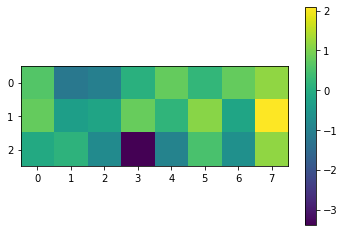

torch.Size([8, 3])


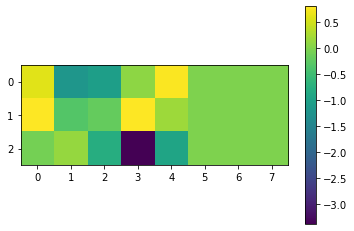

torch.Size([8, 3])


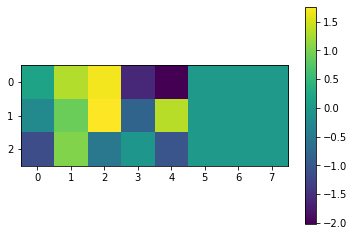

In [0]:
def showTensor(aTensor):
    print(aTensor.shape)
    # aTensor = F.softmax(aTensor, dim=1)
    # aTensor = F.softmax(aTensor.view(-1, 8), dim=1).view(1, -1, 8)[0,:,:]
    plt.figure()
    plt.imshow(aTensor.T.numpy())
    plt.colorbar()
    plt.show()

    # plt.figure()
    # plt.imshow(aTensor.sum(dim=0).unsqueeze(0).numpy())
    # plt.colorbar()
    # plt.show()

    # plt.figure()
    # plt.imshow(aTensor.sum(dim=1).unsqueeze(1).numpy())
    # plt.colorbar()
    # plt.show()

# batch, out_len, in_len
att = torch.randn(4, 8, 3)
mask = torch.FloatTensor([[1, 1, 1, 1, 1, 0, 0, 0]]*4).unsqueeze(2)
print(att.shape, mask.shape)

showTensor(att[0,:,:]);
att = torch.mul(att, mask)
# att.data.masked_fill_(mask.unsqueeze(1), -float('inf'))
showTensor(att[0,:,:]);
showTensor(att[1,:,:]);

torch.Size([512, 224, 32])


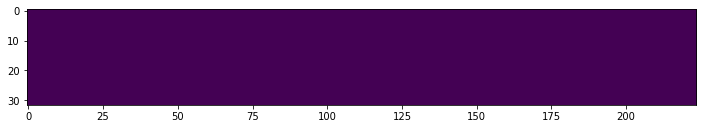

torch.Size([512, 224, 32])


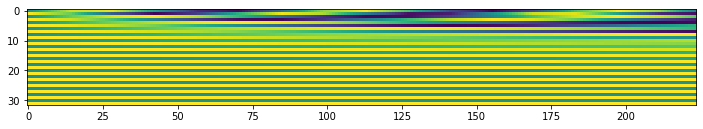

torch.Size([512, 16, 32]) torch.Size([512, 224, 32])
torch.Size([512, 224, 16])


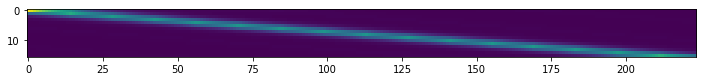

In [0]:
def showTensor(aTensor):
    print(aTensor.shape)
    plt.figure(figsize=(12, 12))
    plt.imshow(aTensor[0,:,:].numpy().T)
    plt.show()

dimension = 32
steps = 16 * 14

feature = torch.zeros(512, steps, dimension)
showTensor(feature)

pos = PositionalEncoding(dimension, 0.0, scale=1. / 14)
pos_feature  = pos(feature)
showTensor(pos_feature)

dimension = 32
steps = 16

pos = PositionalEncoding(dimension, 0.0, scale=1)
target = pos(torch.zeros(512, steps, dimension))

att = Attention(dimension)
print(target.shape, pos_feature.shape)
new_map, weights = att(target, pos_feature)
new_map.shape, weights.shape

showTensor(weights.transpose(1, 2))

In [0]:
torch.cuda.empty_cache()
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            # print(type(obj), obj.size())
            obj.detach()
            # obj.cpu().detach()
            del obj
    except:
        pass
torch.cuda.empty_cache()

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [0]:
x = torch.randn(10, 1) * 10
m = x.mean(0, keepdim=True)
s = x.std(0, unbiased=False, keepdim=True)
print(m, s)

tensor([[-2.3201]]) tensor([[10.2772]])


## Pre

In [0]:
class PositionDuration(nn.Module):
    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=0.03):
        super().__init__()
        self.vocab_size = vocab_size

        self.encoder_transcription = Encoder(hidden_size, embedding_size, num_layers=2, dropout=dropout, time_scale=POS_TRANSCRIPTION_SCALE) # 10.330924607165429)  # 5.49        * 8.28374714500745
        
        self.pos_encode = PositionalEncoding(self.vocab_size, dropout, scale=POS_SCALE)

        self.encoder_audio = Encoder(hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        self.decoder_audio = Decoder(hidden_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        
        self.encoder_audio_final = Encoder(hidden_size, embedding_audio_size, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        
        self.attn = Attention(hidden_size)
        self.pos_map = pos_prep.pe

        self.device = device
        self.to(device)
        # load(self, "/content/drive/My Drive/dataset/position_model-9-longest.pth", ignore=['pos_encode', 'encoder_audio_final.fc'])
        
    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
        batch_size, out_seq_len, *features = features_transcription.shape

        encoder_transcription_outputs, hidden_transcription = self.encoder_transcription(features_transcription)
        encoder_audio_outputs, hidden_audio = self.encoder_audio(features_audio)
        
        output, weights = self.attn(encoder_transcription_outputs, encoder_audio_outputs, mask_audio)
        
        pos, _ = self.encoder_audio_final(features_audio)
        pos = self.pos_encode(pos)  # * 0)

        mix = torch.bmm(weights, pos)  # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        return mix[:,:-1,:]  # fuck the last border, its at the very edge anyways


class PositionAttention(nn.Module):
    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, attention_size=None, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        print("scale:", POS_TRANSCRIPTION_SCALE)

        self.encoder_transcription = Encoder(hidden_size, embedding_size, num_layers=2, dropout=dropout, time_scale=POS_TRANSCRIPTION_SCALE)
        self.encoder_audio = Encoder(hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        
        self.encoder_audio_final = Encoder(hidden_size, hidden_size, out_dim=self.vocab_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        self.decoder_audio = Decoder(self.vocab_size, hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        
        self.pos_encode = PositionalEncoding(self.vocab_size, dropout, scale=POS_SCALE)
        
        self.attn = Attention(attention_size or hidden_size)
        self.pos_map = pos_prep.pe

        self.device = device
        self.to(device)

        self.zero = torch.zeros(256, 2048, self.vocab_size).to(device)
        # load(self, "/content/drive/My Drive/dataset/position_model-9-longest.pth", ignore=['pos_encode', 'encoder_audio_final.fc'])
        
    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio, express=True):
        encoder_transcription_outputs, hidden_transcription = self.encoder_transcription(features_transcription) # # # #
        position_encodes, *_  = self.transform(encoder_transcription_outputs, mask_transcription, features_audio, mask_audio, express=express)
        # fuck the last border, its literally the end of the file anyways
        return position_encodes[:,:-1,:]

    def transform(self, encoder_transcription_outputs, mask_transcription, features_audio, mask_audio, express=False, weights_only=False):
        encoder_audio_outputs, hidden_audio = self.encoder_audio(features_audio)
        
        transcription_audiofied, weights = self.attn(encoder_transcription_outputs, encoder_audio_outputs, mask_audio)
        if weights_only:
            return weights

        batch, seq_len, dimensions = encoder_audio_outputs.shape
        # processsed_audio, audio_hidden = self.encoder_audio_final(encoder_audio_outputs)
        processsed_audio = self.zero[:batch,:seq_len,:self.vocab_size]
        pos = self.pos_encode(processsed_audio)
        
        position_encodes = torch.bmm(weights, pos) # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        if express:
            return position_encodes, None, None

        # processsed_audio, _ = self.decoder_audio(processsed_audio, audio_hidden, transcription_audiofied, mask_transcription)
        return position_encodes, transcription_audiofied, encoder_audio_outputs   

class PositionModel(nn.Module):
    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=0.15):
        super().__init__()
        self.first = PositionAttention(embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=dropout)
        # load(self.first, "/content/drive/My Drive/dataset/position_model-9-longest.pth", ignore=['pos_encode', 'encoder_audio_final.fc', 'decoder_audio', 'encoder_audio_final'])

        self.second = PositionAttention(vocab_size, embedding_audio_size, vocab_size, vocab_size, device, dropout=dropout, attention_size=vocab_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.gradient = (torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1).cuda()
        self.gradient_attention = Attention(vocab_size)
        self.gradient_position_map = pos_prep
        self.pos_encode = PositionalEncoding(vocab_size, dropout, scale=POS_SCALE)

        self.to(device)
        load(self, "/content/drive/My Drive/dataset/position_model-gradient-z-6.pth")
        self.shift = False
    
    def transform(self, features_transcription, mask_transcription, features_audio, mask_audio):
        encoder_transcription_outputs, hidden_transcription = self.first.encoder_transcription(features_transcription)
        position_encodes, transcription_audiofied, processsed_audio = self.first.transform(encoder_transcription_outputs, mask_transcription, features_audio, mask_audio)

        features_transcription = self.fc(transcription_audiofied) + position_encodes

        position_encodes, transcription_audiofied, processsed_audio = self.second.transform(features_transcription, mask_transcription, features_audio, mask_audio)
        return position_encodes, transcription_audiofied, processsed_audio

    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
        position_encodes, transcription_audiofied, processsed_audio = self.transform(features_transcription, mask_transcription, features_audio, mask_audio)
        return position_encodes[:,:-1,:]
    
    def timestamps(self, features_transcription, mask_transcription, features_audio, mask_audio, argmax=False, weights_only=False):
        batch, seq_len, _ = features_audio.shape

        encoder_transcription_outputs, hidden_transcription = self.first.encoder_transcription(features_transcription)
        position_encodes, transcription_audiofied, processsed_audio = self.first.transform(encoder_transcription_outputs, mask_transcription, features_audio, mask_audio)

        features_transcription = self.fc(transcription_audiofied) + position_encodes

        weights = self.second.transform(features_transcription, mask_transcription, features_audio, mask_audio, weights_only=True)
        if weights_only:
            return weights
        return self.weights_to_positions(weights, argmax)
    
    def weights_to_positions(self, weights, argmax=False):
        batch_size, audio_size, input_size = weights.shape

        batch, trans_len, seq_len = weights.shape
        if argmax:
            return weights.max(2)[1][:,:-1]
        positions = (self.gradient[:seq_len] * weights.transpose(1, 2)).sum(1)[:,:-1]
        return positions


class TripleModel(nn.Module):
    class Mode:
        detection_chain = "detection_chain"

        position_weights = "position_weights"
        position_gradient = "position_gradient"
        position_argmax = "position_argmax"
        position = "position"
        position_eval = "position_eval"
        
        repeat = "repeat"
        repeat_weight = "repeat_weight"
        gradient = "gradient"
        argmax = "argmax"

        keys = [detection_chain,position,position_weights,repeat,repeat_weight,gradient,argmax,]

    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, position_size, device, dropout=0.02):
        super().__init__()
        self.vocab_size = vocab_size
        self.position_size = position_size

        # Audio model
        self.audio__encoder = Encoder(embedding_audio_size, embedding_audio_size, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=None)

        self.audio__encoder_transcription = Encoder(hidden_size, embedding_size, num_layers=2, dropout=dropout, time_scale=None)          
        self.audio__decoder_transcription = Decoder(vocab_size, hidden_size, vocab_size, num_layers=2, dropout=dropout, time_scale=None)
        
        self.audio__encoder_audio = Encoder(hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=None)
        self.audio__decoder_audio = Decoder(vocab_size, hidden_size, hidden_size, num_layers=2, dropout=dropout, time_scale=None)

        self.audio__out_chain = nn.Linear(hidden_size, vocab_size)

        # Encoding model
        self.audio__to_position__transcription = nn.Linear(hidden_size + embedding_size, embedding_size)
        self.audio__to_position__audio = nn.Linear(vocab_size + embedding_audio_size, embedding_audio_size)

        self.position__encoder_transcription = Encoder(hidden_size, vocab_size, num_layers=2, dropout=dropout, time_scale=POS_TRANSCRIPTION_SCALE)
        self.position__encoder_audio = Encoder(hidden_size, embedding_audio_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        
        # Attention and resize to vocab size
        self.position__vector_attention = Attention(hidden_size)
        self.pos_encode = PositionalEncoding(position_size, dropout, scale=POS_SCALE)
        self.position__encoder_audio_vector = Encoder(hidden_size, embedding_audio_size, out_dim=position_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)
        self.position__eval_attention = Attention(position_size)

        # Second pass
        self.position__to_repeat__transcription = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.repeat__transcription_shuffle = nn.Linear(hidden_size, position_size)

        self.position__to_repeat__audio = nn.Linear(hidden_size + embedding_audio_size, embedding_audio_size)
        self.repeat__encoder_audio = Encoder(hidden_size, embedding_audio_size, out_dim=position_size, num_layers=2, dropout=dropout, time_scale=POS_SCALE)         

        self.gradient__vector_attention = Attention(position_size)
        # Gradient
        self.gradient = (torch.cumsum(torch.ones(2 ** 14), 0).unsqueeze(1) - 1).cuda()

        # extra
        self.pos_map = pos_prep.pe

        self.device = device
        self.mode = self.Mode.detection_chain
        
        self.welcome = True
        pprint(OrderedDict(
            embedding_size=embedding_size,
            embedding_audio_size=embedding_audio_size,
            hidden_size=hidden_size,
            vocab_size=vocab_size,
        ))
        load(self, "/content/drive/My Drive/dataset/triple-256-5.pth")#, ignore="gradient__vector_attention position__to_repeat__transcription repeat__transcription_shuffle".split())
        # load(self, "/content/drive/My Drive/dataset/triple-128-detection_chain-1.pth")
    
    def __getattr__(self, item):
        cleaned = item.replace("is_", "").replace("with_", "")
        if hasattr(self.Mode, cleaned):
            mode = getattr(self.Mode, cleaned)
            if "is_" in item:
                return self.mode == mode
            elif "with_" in item:
                self.mode = mode
                return self
        return super().__getattr__(item)

    def __dir__(self):
        return super().__dir__() + [f"is_{k}" for k in self.Mode.keys] + [f"with_{k}" for k in self.Mode.keys]

    def needs_training(self, flag):
        context = nullcontext() if flag else torch.no_grad()
        # print(type(context).__name__, mode)
        return context

    def fuck(self):
        audio = [
            self.audio__encoder,
            self.audio__encoder_transcription,
            self.audio__encoder_audio,
            self.audio__decoder_transcription,
            self.audio__decoder_audio,
            self.audio__out_chain,
        ]
        for m in audio:
            m.requires_grad = False

        for param in m.parameters():
            param.requires_grad = False
    
    def weights_to_positions(self, weights, argmax=False):
        batch_size, audio_size, input_size = weights.shape

        batch, trans_len, seq_len = weights.shape
        if argmax:
            return weights.max(2)[1][:,:-1]
        positions = (self.gradient[:seq_len] * weights.transpose(1, 2)).sum(1)[:,:-1]
        return positions

    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio):
        batch, seq_len, _ = features_audio.shape

        mask_transcription = mask_transcription.clone().detach() if mask_transcription is not None else None
        mask_audio = mask_audio.clone().detach() if mask_audio is not None else None
        features_transcription = features_transcription.clone().detach()
        features_audio = features_audio.clone().detach()

        with self.needs_training(self.is_detection_chain):
            audio__encoded_inputs, hidden = self.audio__encoder(features_audio)
            
            audio__encoder_transcription_outputs, hidden_transcription = self.audio__encoder_transcription(features_transcription)
            audio__encoder_audio_outputs, hidden_audio = self.audio__encoder_audio(features_audio)
            
            audio__output_audio, _ = self.audio__decoder_transcription(audio__encoded_inputs, None, audio__encoder_transcription_outputs, mask_transcription)
            audio__output_audio, _ = self.audio__decoder_audio(audio__output_audio, hidden_audio, audio__encoder_audio_outputs, mask_audio)
            
            audio__chain_result = F.relu(self.audio__out_chain(audio__output_audio))

            self.welcome = self.welcome and pprint(OrderedDict(
                audio__encoded_inputs=audio__encoded_inputs.shape,
                audio__encoder_transcription_outputs=audio__encoder_transcription_outputs.shape,
                audio__encoder_audio_outputs=audio__encoder_audio_outputs.shape,
                audio__output_audio=audio__output_audio.shape,
                audio__chain_result=audio__chain_result.shape,
            ))

        if self.is_detection_chain:
            return audio__chain_result     

        audio__chain_result = audio__chain_result.clone().detach()
        audio__encoder_transcription_outputs = audio__encoder_transcription_outputs.clone().detach()

        # with self.needs_training(self.is_detection_chain):

        # TRANSCRIPTION
        # we detect transitions, so pairs of phonemes and don't care about the last one as it is the end of file anyway
        features_transcription = features_transcription.clone().detach()
        features_transcription[:,:-1] += features_transcription[:,1:] * 0.2
        # mask_transcription = mask_transcription if mask_transcription is None else mask_transcription[:,:-1]

        position__features_transcription = torch.cat((features_transcription, audio__encoder_transcription_outputs), dim=2)
        position__features_transcription = F.relu(self.audio__to_position__transcription(position__features_transcription))
        position__transcription_outputs, _ = self.position__encoder_transcription(features_transcription)

        # FEATURES_AUDIO
        position__features_audio = torch.cat((features_audio, audio__chain_result), dim=2)
        position__features_audio = F.relu(self.audio__to_position__audio(position__features_audio))
        position__encoder_audio_outputs, _ = self.position__encoder_audio(position__features_audio)

        # FIND ATTENTION
        position__transcription_audiofied, position__weights = self.position__vector_attention(position__transcription_outputs, position__encoder_audio_outputs, mask_audio)
        if self.is_position_weights:
            return position__weights  

        if self.is_position_gradient:
            self.weights_to_positions(position__weights)
        
        if self.is_position_argmax:
            self.weights_to_positions(position__weights, argmax=True)
                    
        position__processsed_audio, _ = self.position__encoder_audio_vector(features_audio)
        # self.position_size
        # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        position__position_vectors = torch.bmm(position__weights, self.pos_encode(position__processsed_audio)) 
        if self.is_position:
            return position__position_vectors[:,:-1]

        if self.is_position_eval:
            pos_features = self.pos_encode(torch.zeros_like(position__processsed_audio))
            _, weights = self.position__eval_attention(position__position_vectors, pos_features)
            return self.weights_to_positions(weights)

        # SECOND PASS
        # - prep calculated transcriptions to accept calculated pos encodes
        repeat__transcription = torch.cat((position__transcription_audiofied, features_transcription), dim=2)
        repeat__transcription = F.relu(self.position__to_repeat__transcription(repeat__transcription))
        repeat__transcription = self.repeat__transcription_shuffle(repeat__transcription) + position__position_vectors
        # - prep audio
        repeat__features_audio = torch.cat((position__encoder_audio_outputs, features_audio), dim=2)
        repeat__features_audio = F.relu(self.position__to_repeat__audio(repeat__features_audio))
        repeat__features_audio, _ = self.repeat__encoder_audio(repeat__features_audio)

        repeat__transcription_audiofied, repeat__weights = self.gradient__vector_attention(repeat__transcription, repeat__features_audio, mask_audio)
        
        if self.is_argmax:
            return repeat__weights.max(2)[1][:,:-1]
 
        positions = (self.gradient[:seq_len] * repeat__weights.transpose(1, 2)).sum(1)[:,:-1]
        return positions


class PositionModelTest(PositionModel):
    def __init__(self, embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout=0.05):
        super().__init__(embedding_size, embedding_audio_size, hidden_size, vocab_size, device, dropout)
        self.third = PositionAttention(vocab_size, embedding_audio_size, vocab_size, vocab_size, device, dropout=dropout, attention_size=vocab_size)
        self.encoder_transcription = Encoder(hidden_size, vocab_size, out_dim=vocab_size, num_layers=2, dropout=dropout, time_scale=None)

        self.combine_trans = nn.Linear(vocab_size + vocab_size, vocab_size)
        self.combine_audio = nn.Linear(vocab_size + embedding_audio_size, embedding_audio_size)

        print(vocab_size)
        
    def timestamps(self, features_transcription, mask_transcription, features_audio, mask_audio, argmax=False, weights_only=False):
        batch, seq_len, _ = features_audio.shape

        encoder_transcription_outputs, hidden_transcription = self.first.encoder_transcription(features_transcription)
        position_encodes, transcription_audiofied, processsed_audio = self.first.transform(encoder_transcription_outputs, mask_transcription, features_audio, mask_audio)

        features_transcription = self.fc(transcription_audiofied) + position_encodes

        position_encodes, transcription_audiofied, processsed_audio = self.second.transform(features_transcription, mask_transcription, features_audio, mask_audio)
        # print(transcription_audiofied.shape)
        transcription_audiofied = torch.cat((features_transcription, transcription_audiofied), dim=2)
        # print(transcription_audiofied.shape)

        transcription_audiofied = F.relu(self.combine_trans(transcription_audiofied))
        transcription_audiofied, _ = self.encoder_transcription(transcription_audiofied)
        features_transcription = transcription_audiofied + position_encodes

        features_audio = F.relu(self.combine_audio(torch.cat((features_audio, processsed_audio), dim=2)))
        
        # print(features_transcription.shape, processsed_audio.shape, features_audio.shape)
        weights = self.third.transform(features_transcription, mask_transcription, features_audio, mask_audio, weights_only=True)

        if weights_only:
            return weights
        return self.weights_to_positions(weights, argmax)

    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio, argmax=False, weights=False):
        features_transcription = features_transcription.clone()
        features_transcription[:,:-1] += features_transcription[:,1:] * 0.25
        # mask_transcription = mask_transcription if mask_transcription is None else mask_transcription[:,:-1]
        return self.timestamps(features_transcription, mask_transcription, features_audio, mask_audio, argmax, weights_only=weights)
    
    def weights_to_positions(self, weights, argmax=False):
        batch_size, audio_size, input_size = weights.shape

        if self.shift and 0:
            # totally failed attempt
            c = torch.cumsum(weights.clone(), 2)
            c[:,1:,:] = c[:,:-1,:].clone()
            c[:,0,:] = 1
            c = c.detach()
            weights = weights * ((1.50 - c)) * 10000
            weights = F.softmax(weights.view(-1, input_size), dim=1).view(batch_size, -1, input_size).clone()

        batch, trans_len, seq_len = weights.shape
        if argmax:
            return weights.max(2)[1][:,:-1]
        positions = (self.gradient[:seq_len] * weights.transpose(1, 2)).sum(1)[:,:-1]
        return positions

class PositionModelTestSingle(PositionModel):
    def timestamps(self, features_transcription, mask_transcription, features_audio, mask_audio, argmax=False, weights_only=False):
        batch, seq_len, _ = features_audio.shape

        encoder_transcription_outputs, hidden_transcription = self.first.encoder_transcription(features_transcription)
        weights = self.first.transform(encoder_transcription_outputs, mask_transcription, features_audio, mask_audio, weights_only=True)

        if weights_only:
            return weights
        return self.weights_to_positions(weights, argmax)
    
    def forward(self, features_transcription, mask_transcription, features_audio, mask_audio, argmax=False, weights=False):
        features_transcription = features_transcription.clone()
        features_transcription[:,:-1] += features_transcription[:,1:] * 0.25
        # mask_transcription = mask_transcription if mask_transcription is None else mask_transcription[:,:-1]
        return self.timestamps(features_transcription, mask_transcription, features_audio, mask_audio, argmax, weights_only=weights)
    


## Old results

In [0]:
def draw_durationXXX(model, dataset, index):
    print(f'\n{index} - - - -')
    model.eval()
    ds = dataset[index]
    features_audio = ds.features
    transcription_truth = dataset.out_vec[index].detach().cpu().numpy()
    inputs = ds.features.detach().cpu().numpy()

    trans = ds.in_transcription

    res_batch = model.forward(trans.unsqueeze(0), None, features_audio.unsqueeze(0), None) * ms_per_step
    duration = (duration_combined_model(trans.unsqueeze(0), None, features_audio.unsqueeze(0), None) * DURATION_SCALER).view(-1).detach().cpu().numpy()[:-1]

    prediction = (res_batch).squeeze(0).detach().cpu().numpy()
    prediction_position = prediction.copy()
    prediction[1:] -= prediction[:-1].copy()
    
    truth_position = torch.cumsum(ds.out_duration[:-1], dim=0).detach().cpu().numpy()  * DURATION_SCALER
    truth = ds.out_duration[:-1].detach().cpu().numpy()  * DURATION_SCALER


    print(prediction.shape, truth.shape)

    for i, (a, b, d) in enumerate(zip(prediction, truth, duration)):
        if abs(a-b) > 150:
            print(f'{i:3.0f} {a:5.0f} {b:5.0f}  diff:{a-b:5.0f}   - - - -  {d:5.0f}  d;{d-b:5.0f}')

    # for i, a in enumerate(prediction_position):
    #     print(f'{i:3.0f} {a:5.0f}')

    trans = trans.detach().cpu().numpy()

    
    transcription_with_duration = generate_duration_transcription(trans, prediction)

    index = 0
    f, axarr = plt.subplots(2, figsize=(40, 8))    

    # axarr[0].imshow(inputs.T, origin="lower", aspect='auto', cmap=cm.winter)

    # axarr[1].imshow(transcription_truth.T, origin="lower", aspect='auto', cmap=cm.winter)
    # axarr[1].text(0, -5, 'duration truth', bbox={'pad': 1})

    # axarr[2].plot(truth, 'g', label="Truth")
    # axarr[2].plot(prediction, 'r', label="Prediction")
    # axarr[2].plot(duration, 'b', label="Prediction")
    # axarr[2].legend(loc="upper left")

    # axarr[3].imshow(transcription_with_duration.T, origin="lower", aspect='auto', cmap=cm.winter)
    # axarr[3].text(0, -5, 'duration scaled prediction')

    distance, path = slowdtw(prediction_position, truth_position, dist=2)
    # new = np.array([0] * len(prediction_position))
    # for x, y in path:
    #     new[x] = truth_position[y]
    #     # print(x, y, [], prediction_position[x], truth_position[y], new[x])

    new = prediction_position.copy()
    prev = 0
    for i, v in enumerate(new):
        after = new[i+1] if i + 1 < len(new) else v
        if v < prev or v > after:
            # v = (prev + after) / 2
            v =  prev + duration[i-1]
            # v = ((prev + after) / 2 + (prev + duration[i - 1]) * 2 ) / 3

        new[i] = v                
        prev = v
        

    axarr[index].plot(prediction_position[1:] - prediction_position[:-1], 'r.', label="Prediction")
    axarr[index].plot(new[1:] - new[:-1], 'b', label="alligned")
    axarr[index].plot(truth_position[1:] - truth_position[:-1], 'g', label="Truth")
    axarr[index].legend(loc="upper left")
    
    index += 1
    axarr[index].plot(prediction_position, 'r.', label="Prediction")
    axarr[index].plot(new, 'b', label="alligned")
    axarr[index].plot(truth_position, 'g', label="Truth")
    axarr[index].legend(loc="upper left")


# [id:933,]  [  -35   685]   215 False
# [id:252,]  [ -362    17]   154 True
# [id:690,]  [ -311    34]   304 True
# [id:618,]  [ -335    24]   396 True
# [id:760,]  [ -461    35]   228 True

# 100 150 400 250 300 350 400
# 100 150 200 100 300 350 400
# draw_duration(position_model, test_dataset, 618)
# for i in [933, 252, 690, 618, 760,]:


for i in [202,142,544,564,618,1003, 76,720,960,981,311,761,938,195,702, 60,236,1010,570,1171,933,684,760,]:
    draw_duration(position_model, test_dataset, i)